# 01_PL_04_Combine_networks

The notebook __merges two different street networks into one.__ 
* Boeing is considered network 01, the base network. From the base network only what's necessary to modify is modified and added to the output network.
* * Created on Notebook __01_PL_02_Boeing_network.__
* Tessellations is considered the network 02, the complementary network. Parts of this network that are NOT covered by the base network are added to the output network.
* * Created on Notebook __01_PL_03_Tessellations_network. Use network without intersections consolidation.__

__IMPORTANT: Defining network 01 (Base) and network 02 (Complementary) has an effect on various steps of the process, from deciding what to join to how the final cleaning is performed.__

## __Import libraries__

In [1]:
first_folder_path = "../"

In [2]:
import os
import sys

import pandas as pd
import geopandas as gpd
import osmnx as ox
import numpy as np
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns

# To create Point from coordinates
from shapely import Point
# For calculate distance between points
import math
# To know if it is a LineString or a MultiLineString, and create them
from shapely.geometry import LineString, MultiLineString
# To split a line using a point in that line
from shapely.ops import split
# To force MultiLineStrings to LineStrings
from shapely import ops
# To reverse a line's geometry (Check for duplicated edges)
import shapely
# Time processes
import time

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join(first_folder_path))
if module_path not in sys.path:
    sys.path.append(module_path)
    import src

/home/observatorio/.cache/pypoetry/virtualenvs/vref-walkability-index-z1BTlbCQ-py3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## __Notebook config__ [Modify input and output dirs as required]

In [3]:
city = 'medellin'

# ----- ----- ----- Input (Accepts .zip files) ----- ----- -----
# Boeing input network - Specify nodes and edges files.
boeing_nodes_dir = first_folder_path + f"data/output/shape/network_boeing/{city}/{city}_nodes.shp"
boeing_edges_dir = first_folder_path + f"data/output/shape/network_boeing/{city}/{city}_edges.shp"
# Tessellations input network - Specify nodes and edges files.
tess_nodes_dir = first_folder_path+ f"data/output/shape/network_tessellations/{city}/{city}_tessellations_nodes_before_consolidation.shp"
tess_edges_dir = first_folder_path+ f"data/output/shape/network_tessellations/{city}/{city}_tessellations_edges_before_consolidation.shp"

# ----- ----- ----- Projection to be used when needed ----- ----- -----
if city == 'guadalajara':
    projected_crs = "EPSG:32613"
elif city == 'medellin':
    projected_crs = "EPSG:32618"
    
# ----- ----- ----- Output ----- ----- -----
# Output dir - Specify where outputs will be saved [Create folder path manually if creation fails]
output_dir = first_folder_path + f"data/output/shape/network_project/{city}/"
# Create folder if it doesn't exist
if os.path.exists(output_dir) == False:
    os.mkdir(output_dir)

# Outputs to be saved - Specify which steps will be saved (Final result is localsave_02_07)
# PART 01 STEP 01 - Saves pre-formated Boeing nodes and edges [Base network], and tessellation nodes and edges [Complementary network]
localsave_01_01 = True
# PART 01 STEP 02 - Saves the uncovered parts of the complementary network (nodes and edges) and the contact nodes that will be used to connect both networks.
localsave_01_02 = True
# PART 02 STEP 01 - Saves both networks (Base, complementary) nodes and edges after being intersected by themselves. Saves the intersection nodes.
localsave_02_01 = True
# PART 02 STEP 02 - Saves the Dataframe that has the connection's data between both networks (connected_nodes_df) and the intersections to be performed on the Base ntw (intersection_nodes_2)
localsave_02_02 = True
# PART 02 STEP 03 - Saves both networks joined (concatenated_nodes, concatenated_edges)
localsave_02_03 = True
# PART 02 STEP 04 - Saves both networks after being joined (joined_nodes_fix, joined_edges_fix)
localsave_02_04 = True
# PART 02 STEP 05 - Saves both networks after being cleaned (joined_nodes_clean, joined_edges_clean)
localsave_02_05 = True
# PART 02 STEP 06 - Saves both networks after being consolidated (Close nodes become one node, edges travel up to that consolidated node)
localsave_02_06 = True
# PART 02 STEP 07 - Saves both networks after being rebuilt (Consolidation creates osmid in the form of strings [osmid_1, osmid_2], this process
# restores network to coordinate-based IDs (osmid, u, v))
localsave_02_07 = True

# ----- ----- ----- Previous step data loading (Mainly for building and debugging the code) ----- ----- -----
# If there's a need to load previously saved outputs in order to start running from a specific step, turn to True

# Data for part01_step02_identifyuncovered (boeing_nodes, boeing_edges, tess_nodes, tess_edges)
load_datafor_part01_step02 = False
# Data for part02_step01_ntwsintersection (boeing_nodes, boeing_edges, complementary_uncovered_nodes_clean, complementary_uncovered_edges_clean, contact_nodes)
load_datafor_part02_step01 = False
# Data for part02_step02_connectidentif (contact_nodes, base_nodes_i, base_edges_i, comp_nodes_i, comp_edges_i)
load_datafor_part02_step02 = False
# Data for part02_step03_ntwsconcat (base_nodes_i, base_edges_i, comp_nodes_i, comp_edges_i, intersection_nodes_2)
load_datafor_part02_step03 = False
# Data for part02_step04_ntwsconcat (connected_nodes, concatenated_nodes, concatenated_edges) [Draw edges and identify consequential intersections]
load_datafor_part02_step04 = False
# Data for substep inside part02_step04_ntwsconcat. Substep that fixes consequential intersections. (concatenated nodes, joined_edges_concat, intersection_nodes_3)
load_datafor_substep_part02_step04 = False
# Data for part02_step05_ntwsclean (joined_nodes_fix, joined_edges_fix)
load_datafor_part02_step05 = False
# Data for part02_step06_ntwsconsolidation (project_nodes, project_edges)
load_datafor_part02_step06 = False
# Data for part02_step07_ntwsrebuild (cons_nodes, cons_edges)
load_datafor_part02_step07 = False

# Show dirs
print(boeing_nodes_dir)
print(boeing_edges_dir)
print(tess_nodes_dir)
print(tess_edges_dir)

../data/output/shape/network_boeing/medellin/medellin_nodes.shp
../data/output/shape/network_boeing/medellin/medellin_edges.shp
../data/output/shape/network_tessellations/medellin/medellin_tessellations_nodes_before_consolidation.shp
../data/output/shape/network_tessellations/medellin/medellin_tessellations_edges_before_consolidation.shp


#### __Unzip files if necessary -__ If any input_dir is '.zip', Unzips and extracts .shp, .gpkg or .geojson file.

In [4]:
input_directories = [boeing_nodes_dir,boeing_edges_dir,tess_nodes_dir,tess_edges_dir]
output_directories = []

for input_dir in input_directories:
    if input_dir.endswith('.zip'):
        # Extract .zip
        with zipfile.ZipFile(input_dir, "r") as zip_ref:
            zip_ref.extractall(output_dir)
        # Search for files with geospatial format inside extracted file
        shp_files = glob.glob(os.path.join(extract_path, "*.shp"))
        gpkg_files = glob.glob(os.path.join(extract_path, "*.gpkg"))
        geojson_files = glob.glob(os.path.join(extract_path, "*.geojson"))
        # Choose file (Priority: SHP>GPKG>GEOJSON)
        if shp_files:
            input_dir = shp_files[0]  # Usar el primer .shp encontrado
        elif gpkg_files:
            input_dir = gpkg_files[0]
        elif geojson_files:
            input_dir = geojson_files[0]
        else:
            raise FileNotFoundError(f"No geospatial files found on {extract_path}.")
            
    # Add directory as output dir
    output_directories.append(input_dir)  

# Re-assign variables the updated values
boeing_nodes_dir, boeing_edges_dir, tess_nodes_dir, tess_edges_dir = output_directories

# Show dirs
print(boeing_nodes_dir)
print(boeing_edges_dir)
print(tess_nodes_dir)
print(tess_edges_dir)

../data/output/shape/network_boeing/medellin/medellin_nodes.shp
../data/output/shape/network_boeing/medellin/medellin_edges.shp
../data/output/shape/network_tessellations/medellin/medellin_tessellations_nodes_before_consolidation.shp
../data/output/shape/network_tessellations/medellin/medellin_tessellations_edges_before_consolidation.shp


## __Functions__

### __Functions -__ Common functions

In [5]:
def produce_osmid(nodes_network_1, nodes_network_2, previously_produced):
    
    stop = False
    produced_osmid = previously_produced
    
    while stop == False:

        # Evaluate if fabricated_osmid exists in any network
        if (produced_osmid in list(nodes_network_1.osmid.unique())) or (produced_osmid in list(nodes_network_2.osmid.unique())):
            # Try the next one
            produced_osmid +=1
            
        else:
            # Reached an unique fabricated_osmid
            stop = True
            return produced_osmid

In [6]:
# Distance between two points
def distance_between_points(point1, point2):
    return round(math.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2), 2)

### __Functions -__ Identify_uncovered [Used in Part01_Step02]

In [7]:
def identify_uncovered(base_nodes, base_edges, complementary_nodes, complementary_edges, contact_analysis_dist, projected_crs="EPSG:6372"):
    """ This function identifies zones within a complementary network (nodes and edges) where currently there's no coverture in a base network.
	Args:
		base_nodes (geopandas.GeoDataFrame): GeoDataFrame containing nodes of the base network. 
        base_edges (geopandas.GeoDataFrame): GeoDataFrame containing edges of the base network. 
		complementary_nodes  (geopandas.GeoDataFrame): GeoDataFrame containing nodes of the complementary network.
		complementary_edges  (geopandas.GeoDataFrame): GeoDataFrame containing edges of the complementary network.
		contact_analysis_dist (float): Distance (meters) used when deciding which nodes from the complementary network should be added to the base network.
                                A buffer of {contact_analysis_dist} is created around all center points of each complementary_edge.
                                If the buffer touches any base_edges, the complementary_edge is considered as already covered by the base network. 
                                If the buffer does not touches any base_edge, the complementary_edge is considered uncovered.
		projected_crs (str, optional): string containing projected crs to be used depending on area of interest. Defaults to "EPSG:6372".

	Returns:
        complementary_uncovered_nodes (geopandas.GeoDataFrame): GeoDataFrame with nodes from the complementary network that are located 
                                                                in a zone not covered by the base network.
        complementary_uncovered_nodes (geopandas.GeoDataFrame): GeoDataFrame with edges from the complementary network that are located
                                                                in a zone not covered by the base network.
		contact_nodes (geopandas.GeoDataFrame): GeoDataFrame with nodes from the complementary network that could be used to 
                                                connect an uncovered zone to a covered zone.
	"""

    # Turn on or off function logs (General Logs)
    function_logs = True
    # Turn on or off debbugging logs (Lots of logs used for debugging)
    debugging_logs = False
    
    # 1.0 --------------- Extract mid_point of each complementary edge
    if function_logs:
        print("1.0 - Extracting mid_point point of each complementary edge.")
    # ------------------- INPUT USED - READ COMPLEMENTARY EDGES
    complementary_edges = complementary_edges.copy()
    complementary_edges = complementary_edges.to_crs(projected_crs)
    # ------------------- INPUT USED - READ COMPLEMENTARY EDGES

    # Create unique ID for each edge using u+v+key
    complementary_edges = src.create_unique_edge_id(complementary_edges)
    # Find mid_point of each edge
    complementary_edges['mid_point'] = complementary_edges.interpolate(complementary_edges.length / 2)
    # Assign mid_point to its own gdf and drop column 'mid_point' from complementary_edges
    mid_points = complementary_edges[['edge_id','mid_point']].copy()
    mid_points.rename(columns={'mid_point':'geometry'},inplace=True)
    complementary_edges.drop(columns=['mid_point'],inplace=True)
    
    # 2.0 --------------- Create contact-analysis buffer around mid_points using contact_analysis_dist 
    # ------------------- (keep edge-of-origin data)
    if function_logs:
        print("2.0 - Creating contact-analysis buffer around each mid_point.")
    
    # Reset mid_points's index (Keeps data ordered starting from 0)
    mid_points.reset_index(inplace=True,drop=True) #--> Resets index without saving col 'index'
    # Save each mid_point's reseted index in a column named 'index'
    points_to_buffer = mid_points.copy()
    points_to_buffer.reset_index(inplace=True) #--> Also creates a col 'index', same order since it is reseted
    # Create a gdf containing the contact-analysis buffer around mid_points
    mid_points_buffer = points_to_buffer.buffer(contact_analysis_dist)
    mid_points_buffer = gpd.GeoDataFrame(geometry=mid_points_buffer)
    mid_points_buffer.reset_index(inplace=True) #--> Also creates a col 'index', same order since it is reseted
    # Transfer data from mid_points to it's buffer using the previously reseted index as merge col
    points_to_buffer.drop(columns=['geometry'],inplace=True)
    mid_points_buffer = pd.merge(mid_points_buffer,points_to_buffer,on='index') #--> Merges using common reseted col 'index'
    mid_points_buffer.drop(columns=['index'],inplace=True)

    # Save disk space
    del points_to_buffer
    
    # 3.0 --------------- Find mid_points whose buffer does not intersect with any part of the base network (Considering base_edges).
    # ------------------- [This step creates function output COMPLEMENTARY_UNCOVERED_EDGES]
    if function_logs:
        print("3.0 - Extracting complementary_uncovered_edges.")
    
    # ------------------- INPUT USED - READ BASE EDGES
    base_edges = base_edges.copy()
    base_edges = base_edges.to_crs(projected_crs)
    # ------------------- INPUT USED - READ BASE EDGES
    
    # Buffers that touch any base edge
    buffer_touch = mid_points_buffer.sjoin(base_edges)
    # All unique complementary edge_ids whose mid_point's buffer touched any base_edge
    edge_id_touch_lst = list(buffer_touch.edge_id.unique())
    # Complementary edges that are NOT(~) near any base edge
    complementary_uncovered_edges = complementary_edges.loc[~complementary_edges.edge_id.isin(edge_id_touch_lst)].copy()
    complementary_uncovered_edges.reset_index(inplace=True,drop=True) #--> Resets index without saving col 'index'

    # 4.0 --------------- Select the complementary_nodes that connect to the complementary_uncovered_edges
    # ------------------- [This step creates function output COMPLEMENTARY_UNCOVERED_NODES]
    if function_logs:
        print("4.0 - Extracting complementary_uncovered_nodes.")
    
    # ------------------- INPUT USED - READ COMPLEMENTARY NODES
    complementary_nodes = complementary_nodes.copy()
    complementary_nodes = complementary_nodes.to_crs(projected_crs)
    # ------------------- INPUT USED - READ COMPLEMENTARY NODES 
    
    # List of unique 'u's and 'v's that are connected to the complementary_uncovered_edges 
    complementary_uncovered_osmid_lst = set(list(complementary_uncovered_edges.u.unique()) + list(complementary_uncovered_edges.v.unique()))
    # Select any node where its 'osmid' IS in complementary_uncovered_osmid_lst
    complementary_uncovered_nodes = complementary_nodes.loc[complementary_nodes.osmid.isin(complementary_uncovered_osmid_lst)].copy()
    # [Note: This nodes won't necessarily be in the uncovered zone since they could belong to 
    # an edge whose mid_point is far from the base network, but whose path extends into the base network.]

    # 5.0 --------------- Find the nodes that would be used to connect the uncovered part of the complementary network to the base network.
    # ------------------- [This step creates function output CONTACT_NODES]
    if function_logs:
        print("5.0 - Extracting contact_nodes.")

    # 5.1 --- Create a buffer around all complementary_uncovered_nodes 
    # Reset complementary_uncovered_nodes's index
    complementary_uncovered_nodes.reset_index(inplace=True,drop=True) #--> Resets index without saving col 'index'
    # Save each complementary_uncovered_nodes's reseted index in a column named 'index'
    nodes_to_buffer = complementary_uncovered_nodes.copy()
    nodes_to_buffer.reset_index(inplace=True) #--> Also creates a col 'index', same order since it is reseted
    # Create a gdf containing the buffer around complementary_uncovered_nodes
    complementary_uncovered_nodes_buffer = nodes_to_buffer.buffer(contact_analysis_dist)
    complementary_uncovered_nodes_buffer = gpd.GeoDataFrame(geometry=complementary_uncovered_nodes_buffer)
    complementary_uncovered_nodes_buffer.reset_index(inplace=True) #--> Also creates a col 'index', same order since it is reseted
    # Transfer data from complementary_uncovered_nodes to it's buffer using the index as merge col
    nodes_to_buffer.drop(columns=['geometry'],inplace=True)
    complementary_uncovered_nodes_buffer = pd.merge(complementary_uncovered_nodes_buffer,nodes_to_buffer,on='index') #--> Merges using common reseted col 'index'
    complementary_uncovered_nodes_buffer.drop(columns=['index'],inplace=True)

    # Save disk space
    del nodes_to_buffer
    
    # 5.2 --- Find complementary_uncovered_nodes whose buffer DOES intersect with any part of the base network (Considering base_edges).
    # Buffers that touch any base edge
    buffer_touch = complementary_uncovered_nodes_buffer.sjoin(base_edges)
    # All unique osmids that touched any base_edge
    contact_osmids = list(buffer_touch.osmid.unique())
    # Complementary nodes that ARE near any base_edge
    contact_nodes = complementary_uncovered_nodes.loc[complementary_uncovered_nodes.osmid.isin(contact_osmids)].copy()
    contact_nodes.reset_index(inplace=True,drop=True) #--> Resets index without saving col 'index'
    
    # 6.0 --------------- Identify and shorten edges that extend into the base network and would be usefull to create connections.
    # ------------------- (Up to this step, edges whose mid_points_buffer is in contact with the base network are not included in the
    # ------------------- function's output since they are considered to be in an already-covered zone. However, some edges (if shortened)
    # ------------------- could be usefull to connect the uncovered zone to the covered zone. This step takes the edge and shortens (Clips)
    # ------------------- the edge until it's mid_point_buffer is no longer in contact with the base network)
    # ------------------- [This step updates the uncovered network (nodes and edges) and the contact nodes]
    if function_logs:
        print("6.0 - Creating missing connections through complementary_edges that travel from the uncovered zone to the base network.")
    
    # LOG CODE - Progress logs
    # Will create progress logs when progress reaches these percentages:
    progress_logs = [0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100] # for log statistics
    osmid_count = 0
    # LOG CODE - Progress logs
    
    # 6.0 --- PREPARATION FOR ANALYSIS - Supporting elements
    # Keep track of the amount of edges that underwent a shortening process after finishing this section
    fabricated_count = 0
    # Keep track of which parts of the network where fabricated with the following code.
    # All nodes and edges that keep its original geometry will be assigned 'clipping_i' = 0.
    # All edges whose geometry was clipped will be assigned the amount of shortening (clipping) iterations used in them.
    complementary_uncovered_nodes['clipping_i'] = 0
    complementary_uncovered_edges['clipping_i'] = 0
    complementary_uncovered_edges['original_edge_id'] = ''
    contact_nodes['clipping_i'] = 0
    # Create empty GeoDataFrame to data used in the process (Used for GIS visualization purposes)
    original_diverging_nodes = gpd.GeoDataFrame()
    original_diverging_edges = gpd.GeoDataFrame()
    dropped_overlapping_edges = gpd.GeoDataFrame()

    # 6.0 --- PREPARATION FOR ANALYSIS - Nodes and osmids
    # Read base_nodes once (will be used to assess if the osmid being produced is unique to both input networks)
    # ------------------- INPUT USED - READ BASE EDGES
    base_nodes = base_nodes.copy()
    base_nodes = base_nodes.to_crs(projected_crs)
    # ------------------- INPUT USED - READ BASE EDGES
    # Previously produced osmid. Since will be creating non-existing nodes, function produce_osmid() will use a starting number for
    # trying to produce unique osmids. That function will check if that osmid already exists in either the base or complementary network.
    # Start with number 0.
    previously_produced = 0
    # Find all complementary_uncovered_osmids (from previously created complementary_uncovered_osmid_lst)
    # that are NOT a contact osmid (contact osmids are those that already serve as a connection to the base network)
    non_contact_osmids = [osmid for osmid in complementary_uncovered_osmid_lst if osmid not in contact_osmids]
    
    a="""
    # 6.0 --- PREPARATION FOR ANALYSIS - Dictionaries
    # Shortening dict
    # Sometimes an edge could get shortened from both sides. 
    # (Clipped with starting point 'u' and then, on another case, clipped with starting point 'u')
    # If an edge will be shortened from both sides exactly once (Shortened from 'u' to midpoint and from 'v' to midpoint),
    # there would be two different new nodes in the same place. The dict helps make sure that only one contact_node is created.
    # If not considered, this particular situation can create two different edges that coincide in two different contact_nodes exactly in the midpoint.
    # (This is the main reason why it is necessary to keep track of which edges where shortened and up to which point)
    shortening_dict = {}

    # diverging_osmid dict
    # Stores each shortened edge (original_edge_id) deriving from each nodes (osmid)
    # {osmid:[shortened_original_edge_id_1, shortened_original_edge_id_2, ...]}
    diverging_osmid_dict = {}
    """
    
    # Review each node in the uncovered zone of the complementary network that is not already a contact_node
    for osmid in non_contact_osmids:

        # Development checks -----------------------------------
        #dev_check = [39125252780557922]
        #if osmid not in dev_check:
        #    continue
        #else:
        #    print("--"*50)
        #    print(f"DEVELOPMENT CHECK FOR OSMID {osmid}.")
        # Development checks -----------------------------------
        
        # LOG CODE - Progress logs
        # Measures current progress, prints if passed a checkpoint of progress_logs list.
        current_progress = (osmid_count / len(non_contact_osmids))*100
        for checkpoint in progress_logs:
            if (current_progress >= checkpoint) and function_logs:
                print(f"6.0 - Exploring osmids. {checkpoint}% done.")
                progress_logs.remove(checkpoint)
                break
        # LOG CODE - Progress logs

        # Retrieve it's edges (Will be refered as diverging_edges). 
        # Must consider all edges (takes them from complementary_edges) and not only complementary_uncovered_edges since
        # we are looking to identify if any edge that comes out of that osmid goes towards base_network.
        diverging_edges = complementary_edges.loc[(complementary_edges.u==osmid) | (complementary_edges.v==osmid)].copy()
        diverging_edges_ids = list(diverging_edges.edge_id.unique())
        
        # For each edge diverging from current node:
        for diverging_edge_id in diverging_edges_ids:    
                
            # If the edge DOES touch the base network:
            if diverging_edge_id in edge_id_touch_lst: # (Previously created edge_id_touch_lst)
                # If an edge reaches this part of the code, it means that it is a complementary_edge that:
                # a) Comes out from an node that's located in the uncovered zone (complementary_uncovered_node).
                # b) The node it came out from is NOT a contact_node, it is far from the base network (According to contact_analysis_dist)
                # c) The edge's current mid_point is located in proximity to the base network (According to contact_analysis_dist)
                # --> Between the base_network and this edge itself, a connection point should be identified.
                # --> Objective: Identify that connection (new contact_node) between the complementary and base network.

                try:
                    # 6.1 --- Retrieve current diverging_osmid and diverging_node
                    # Save the osmid from the node which the current edge uses to come out from the uncovered zone into the base network.
                    diverging_osmid = osmid
                    if debugging_logs:
                        print("--"*30)
                        print(f"Entering analysis for:")
                        print(f"Diverging_osmid: {diverging_osmid}. Type: {type(diverging_osmid)}.")
                        print(f"Diverging_edge_id: {diverging_edge_id}. Type: {type(diverging_edge_id)}.")
                        
                    # Extract its node
                    if debugging_logs:
                        print(f"Looking for diverging_node in complementary_uncovered_nodes. Printing complementary_uncovered_nodes dtypes.")
                        print(complementary_uncovered_nodes.dtypes)
                    diverging_node = complementary_uncovered_nodes.loc[complementary_uncovered_nodes.osmid == diverging_osmid].copy()
                    if debugging_logs:
                        print(f"Diverging nodes found: {len(diverging_node)}.")
                    # Reset index (so that accessing its geometry is always .loc[0,'geometry'])
                    diverging_node.reset_index(inplace=True, drop=True)
                    if debugging_logs:
                        print(f"Diverging node's geometry: {diverging_node.loc[0,'geometry']}.")
                    # Add current diverging_node to original_diverging_nodes gdf (For GIS visualization purposes)
                    original_diverging_nodes = pd.concat([original_diverging_nodes, diverging_node])
    
                    # 6.2 --- Retrieve current diverging_edge as the connection_edge
                    # Select the edge that diverts from the diverging_node towards the base_network
                    connection_edge = complementary_edges.loc[complementary_edges.edge_id == diverging_edge_id].copy()
                    # Reset index (so that accessing its data is always .loc[0,'data'])
                    connection_edge.reset_index(inplace=True,drop=True)
                    # The connection_edge geometry will suffer modifications, save original
                    original_connection_edge = connection_edge.copy() 
                    # Add current connection_edge to original_diverging_edges gdf (For GIS visualization purposes)
                    original_diverging_edges = pd.concat([original_diverging_edges, connection_edge])
    
                    # 6.3 --- Clip connection_edge until it's mid_point is no longer in proximity to the base network.
                    # ------- When this point is reached, assign its ending_point (previous mid_point) as a new contact_node.
    
    
                    # 6.3.0 - Find the clipping orientation
                    # --------- It is unsure whether the diverging_node is located at the coordinate 0 or at the last coordinate of the connection_edge.
                    # --------- So it is necessary to identify which one is which.
                    # Extract the edge's coordinates list
                    connection_edge_coords = list(connection_edge['geometry'][0].coords)
                    # Extract the starting_point's coordinates (Known to be the diverging_node)
                    starting_point_coords = diverging_node.loc[0,'geometry'].coords[0]
                    # Obtain the ending_point's coordinates (It is the previous iteration edge's mid_point)
                    # (It is either the first or last coordinate of the connection_edge)
                    if starting_point_coords == connection_edge_coords[0]:
                        node_edge_relation = 'starting'
                    elif starting_point_coords == connection_edge_coords[-1]:
                        node_edge_relation = 'ending'
                    else:
                        print(f"Problem with osmid: {osmid}. Diverging edge_id: {diverging_edge_id}.")
                        print(starting_point_coords)
                        print(connection_edge_coords[0])
                        print(connection_edge_coords[-1])
                        intented_crash
                        node_edge_relation = 'missing'
                
                except:
                    print(f"Failed while preparing the data to analyse {diverging_edge_id} diverging from osmid {diverging_osmid}.")
                    intented_crash
            
                # Kickstart while loop for current connection_edge
                stop = False
                shorten_i = 0
                
                while (stop == False):

                    # Limit of attempts
                    limit_of_attempts =50
                    if shorten_i >= limit_of_attempts:
                        if debugging_logs:
                            print(f"Tried shortening {limit_of_attempts} times (To 0.5% its original size) edge. Stopped.")
                            print(f"Edge data: u {original_connection_edge.u.unique()[0]}, v {original_connection_edge.v.unique()[0]}.")
                        break
                        
                    # 6.3.1 --- Calculate the edge's mid_point.
                    # --------- [Will become the clipping_point in function edge_clipping()].

                    # Set clipping factor
                    if node_edge_relation == 'starting':
                        # This means that length will be measured starting from the diverging node.
                        # We're looking to reduce to 90% that length each loop.
                        interpolation_length = connection_edge.length * 0.90
                    elif node_edge_relation == 'ending':
                        # This means that length will be measured starting from the opposite node to the diverging node.
                        # We're looking to cut the first 10% of that length each loop.
                        interpolation_length = connection_edge.length * 0.10
                    elif node_edge_relation == 'back_to_original':
                        # Check "No-shortening test" for more information
                        interpolation_length = connection_edge.length * 0.50
                    else:
                        interpolation_length = 'missing'
                    
                    # Calculate the connection_edge's mid_point
                    connection_edge['mid_point'] = connection_edge.interpolate(interpolation_length)
                    # Assign mid_point to its own gdf and drop column 'mid_point' from connection_edge gdf
                    edge_mid_point = connection_edge[['edge_id','mid_point']].copy()
                    edge_mid_point.rename(columns={'mid_point':'geometry'},inplace=True)
                    connection_edge.drop(columns=['mid_point'],inplace=True)
                
                    # 6.3.2 --- Evaluate if the current mid_point is still in proximity to the base network
                    # 6.3.2.a - Create contact-analysis buffer around the edge_mid_point
                    # Reset edge_mid_point's index
                    edge_mid_point.reset_index(inplace=True,drop=True) #--> Resets index without saving col 'index'
                    # Save edge_mid_point's reseted index in a column named 'index'
                    point_to_buffer = edge_mid_point.copy()
                    point_to_buffer.reset_index(inplace=True) #--> Also creates a col 'index', same order since it is reseted
                    # Create a gdf containing the contact-analysis buffer around the edge_mid_point
                    mid_point_buffer = point_to_buffer.buffer(contact_analysis_dist)
                    mid_point_buffer = gpd.GeoDataFrame(geometry=mid_point_buffer)
                    mid_point_buffer.reset_index(inplace=True) #--> Also creates a col 'index', same order since it is reseted
                    # Transfer data from edge_mid_point to it's buffer using the previously reseted index as merge col
                    point_to_buffer.drop(columns=['geometry'],inplace=True)
                    mid_point_buffer = pd.merge(mid_point_buffer,point_to_buffer,on='index') #--> Merges using common reseted col 'index'
                    mid_point_buffer.drop(columns=['index'],inplace=True)
                    
                    # 6.3.2.b - Find if current mid_point it's still in proximity to base network
                    # Buffers that touch any base edge
                    buffer_touch = mid_point_buffer.sjoin(base_edges)
                    
                    if len(buffer_touch) > 0:
                        
                        # 6.3.3 --- If it still touches, reduce in size.
                        # If the mid_point_buffer still touches the base edges, the line is most likely still overlaping with the base network.
                        # Apply edge_clipping function to shorten the edge up until the current mid_point
                        connection_edge = edge_clipping(starting_point_gdf = diverging_node,
                                                        edge_gdf = connection_edge,
                                                        clipping_point_gdf = edge_mid_point,
                                                        projected_crs = projected_crs)
                        # Keep connection_edge format
                        connection_edge['edge_id'] = diverging_edge_id
                        # Count shortening iteration
                        shorten_i+=1
                    
                    else:

                        # 6.3.3 --- If the buffer no longer touches any part of the base network, shortening was a success.
                        # --------- However, before registering the shortened edge it it necessary to run various TESTS:

                        # ------------------------------ NO-SHORTENING TEST START ------------------------------
                        # ORIGIN OF PROBLEM:
                        # Originally, the whole test was performed using the mid_point (hence the various relations to the name "mid_point").
                        # However this meant that some edges were cut way too much and ended up far from the base_network, creating unnecesary long connections.
                        # Now the clipping is performed by keeping 90% of the original edge each iteration.
                        # CURRENT SITUATION:
                        # The part of the code where edge_id_touch_lst is created still runs using mid_points, meaning that each diverging_edge_id examined here has its midpoint in proximity to the base network.
                        # However, since the clipping and checking inside the loop is performed using not the midpoint, but the 90% length, there are cases where an edge is NOT shortened not even once.
                        # The edge came here using the mid_point check, then when the 90%length's proximity to the base network was used it indicated that the point was no longer in contact with the base network.
                        # However, the edge suffered no changes, its proximity to the base network was examined from different points.
                        # SOLUTION:
                        # If an edge ends here with shorten_i == 0, it has not been shortened.
                        # Set node_edge_relation to "original", which triggers a mid_point (50%length) clipping each loop.
                        if shorten_i == 0:
                            node_edge_relation = "back_to_original"
                            continue

                        a="""
                        # ------------------------------ NO-SHORTENING TEST END ------------------------------
                        
                        # Double-once-shortening test STARTS ### ### ### ### ### ### ### ### ### ### ### ### 
                        # EXPLANATION:
                        # A complementary_edge could be shortened twice, once from each starting_point. This is a "double shortening".
                        # It occurs when an edge was shortened from node 1 (e.g. from 'u') and now is being shortened from node 2 (e.g. from 'v').
                        # This process produces no problems, **unless both shortening processess undergo just 1 iteration**.
                        # In that specific case, both lines start in their nodes ('u' or 'v') and end at the original line's midpoint.
                        # This produces TWO different contact_nodes in a very similar location, that could result in TWO similar but different treatments and strange geometries.
                        # In order to avoid this, this double_shortening check is conduced in order to make sure that 
                        # at the end of both processes, just ONE contact node is produced and used by both edges ending on it.

                        # If this is NOT the first fabrication case and edge AND the current edge was shortened ONLY once:
                        if (fabricated_count > 0) and (shorten_i==1):
    
                            # Load all original edge_ids that have been shortened ONLY once
                            already_shortened_once = complementary_uncovered_edges.loc[complementary_uncovered_edges.clipping_i==1].copy()
                            already_shortened_once_lst = list(already_shortened_once.original_edge_id.unique())

                            # Check if current diverging_edge_id has already been shortened ONLY once
                            if diverging_edge_id in already_shortened_once_lst:
                                # If an edge reaches this part of the code, the edge was already shortened ONCE from one end, and was being shortened again ONCE from the other end.
                                # Next step --> Do NOT produce a new contact osmid and new point for current edge. Use the existing one. 
                                # ------------> Register the edge under the existing contact_node instead of creating a new one.

                                if debugging_logs:
                                    print(f"Edge {diverging_edge_id} was already shortened [once]. Shortening [once] again from osmid {diverging_osmid}.")

                                # 6.3.3.a1 - Identify the previously produced middle osmid.
                                # Retrieve the ORIGINAL (current original_connection_edge's) 'u' and 'v'
                                original_u = original_connection_edge.u.unique()[0]
                                original_v = original_connection_edge.v.unique()[0]
                                original_osmids = [original_u, original_v]
                                if debugging_logs:
                                    print(f"Edge's original osmids (u,v) were {original_osmids}.")
                                
                                # Retrieve the PREVIOUSLY PRODUCED (previously shortened edge) 'u' and 'v'
                                prev_produced_edge = complementary_uncovered_edges.loc[complementary_uncovered_edges.original_edge_id == diverging_edge_id].copy()
                                new_u = prev_produced_edge.u.unique()[0]
                                new_v = prev_produced_edge.v.unique()[0]
                                new_osmids = [new_u, new_v]
                                if debugging_logs:
                                    print(f"The first shortening is using osmids (u,v) {new_osmids}.")
                                
                                # Identify which osmid is in the new_osmids list but not in the original_osmids list.
                                # (Which osmid was produced here, in step 6.3.3)
                                for osmid_check in new_osmids:
                                    if osmid_check not in original_osmids:
                                        produced_osmid = osmid_check

                                # 6.3.3.a2 - Add the connection_edge as a new edge to complementary_uncovered_edges gdf (But not the node, the node is already there).
                                # Retrieve the diverging_osmid's position in the ORIGINAL connection_edge. (Whether 'u' or 'v')
                                # In order to keep that original diverging_node in its position and add the produced_osmid in the other position.
                                if diverging_osmid == original_u:
                                    connection_edge_u = diverging_osmid
                                    connection_edge_v = produced_osmid
                                    if debugging_logs:
                                        print(f"The new shortening will use osmids (u,v) = {[connection_edge_u,connection_edge_v]}.")
                                elif diverging_osmid == original_v:
                                    connection_edge_u = produced_osmid
                                    connection_edge_v = diverging_osmid
                                    if debugging_logs:
                                        print(f"The new shortening will use osmids (u,v) = {[connection_edge_u,connection_edge_v]}.")
                                else:
                                    print(f"ERROR while trying to set 'u' and 'v' for shortened connection edge {diverging_edge_id}.")
                                    print(f"The new shortening was trying to use osmids (u,v) = {[connection_edge_u,connection_edge_v]}.")
                                    intended_crash
                                # Use the same key that was used in the original_connection_edge
                                connection_edge_key = original_connection_edge.key.unique()[0]
                                # Retrieve the modified edge's (connection_edge's) geometry
                                connection_edge_geom = connection_edge['geometry'].unique()[0]
                                # Find current last position
                                iloc_edge = len(complementary_uncovered_edges)
                                # Register new edge
                                complementary_uncovered_edges.loc[iloc_edge+1,'u'] = connection_edge_u
                                complementary_uncovered_edges.loc[iloc_edge+1,'v'] = connection_edge_v
                                complementary_uncovered_edges.loc[iloc_edge+1,'key'] = connection_edge_key
                                complementary_uncovered_edges.loc[iloc_edge+1,'geometry'] = connection_edge_geom
                                complementary_uncovered_edges.loc[iloc_edge+1,'edge_id'] = str(connection_edge_u)+str(connection_edge_v)+str(connection_edge_key)
                                complementary_uncovered_edges.loc[iloc_edge+1,'original_edge_id'] = diverging_edge_id
                                complementary_uncovered_edges.loc[iloc_edge+1,'clipping_i'] = shorten_i

                                # 6.3.3.a3 - Finished registering. Stop while loop. Continue with the next diverging_edge_id of current osmid.
                                if function_logs:
                                    print(f"6.0 - Reused contact node {produced_osmid} for original edge {diverging_edge_id}.")
                                
                                fabricated_count += 1
                                stop = True
                                continue

                            # Else, this is the first time that the edge is shortened once. 
                            # Not relevant, continue as usual.
                            else:
                                pass
                                
                        # Else, either this is the first edge to be shortened or shorten_i is not equall to 1. 
                        # Not relevant, continue as usual.
                        else:
                            pass
                        # Double-once-shortening test ENDS ### ### ### ### ### ### ### ### ### ### ### ###
                        """

                        # Overlapping edges test STARTS ### ### ### ### ### ### ### ### ### ### ### ###
                        try:
                            # Overlapping checker
                            overlapping_exists = False
                            
                            # Retrieve the modified edge's (connection_edge's) geometry, create a VERY SMALL buffer and get its length
                            connection_edge_geom = connection_edge['geometry'].unique()[0]
                            connection_edge_buff = connection_edge_geom.buffer(0.10)
                            connection_edge_length = connection_edge_geom.length
                            
                            # Find all edges that come out of the current diverging_osmid
                            idx = (complementary_uncovered_edges["u"]==diverging_osmid)|(complementary_uncovered_edges["v"]==diverging_osmid)
                            potential_overlapping = complementary_uncovered_edges.loc[idx].copy()
                            # Remove itself (original_edge_id)
                            drop_idx = potential_overlapping.edge_id==diverging_edge_id
                            potential_overlapping = potential_overlapping.loc[~drop_idx].copy()
                            
                            if debugging_logs:
                                print(f"Reviewing overlapping with complementary edges found around small buffer: {potential_overlapping.edge_id.unique()}.")
                            
                            # Get a list of all geometries where overlapping is going to be analysed
                            potential_geoms = list(potential_overlapping.geometry.unique())
                            # Analyse each edge's overlapping percentage
                            for potential_geom in potential_geoms:                                    
                                # Create a VERY SMALL buffer around already shortened edge and get its length
                                potential_geom_buff = potential_geom.buffer(0.10)
                                potential_geom_length = potential_geom.length
                                # Calculate percentage of overlapping in shortest line
                                if connection_edge_length < potential_geom_length:
                                    overlapping_area_pct = (connection_edge_buff.intersection(potential_geom_buff).area) / (connection_edge_buff.area)
                                else:
                                    overlapping_area_pct = (potential_geom_buff.intersection(connection_edge_buff).area) / (potential_geom_buff.area)
                                # If overlapping is above 75%, we are practically duplicating a connection. Drop.
                                if overlapping_area_pct > 0.75:
                                    if debugging_logs:
                                        print(f"Overlapping. Broke from internal loop. ({overlapping_area_pct*100}%).")
                                    overlapping_exists=True
                                    break
                            # If the analysis found overlapping, do not proceed.    
                            if overlapping_exists:
                                if debugging_logs:
                                    print("Not adding shortened edge, exceeded overlap with existing path.")
                                # Find last position
                                iloc_edge = len(dropped_overlapping_edges)+1
                                # Add dropped connection to dropped_overlapping_edges gdf (For GIS visualization purposes)
                                dropped_overlapping_edges.loc[iloc_edge,'geometry'] = connection_edge_geom
                                dropped_overlapping_edges.loc[iloc_edge,'original_edge_id'] = diverging_edge_id
                                dropped_overlapping_edges.loc[iloc_edge,'clipping_i'] = shorten_i
                                stop = True
                                continue
                            else:
                                if debugging_logs:
                                    print("No overlapping. Continuing.")
                        except:
                            print(f"Overlapping failed on diverging_edge_id {diverging_edge_id}.")
                            print(f"connection_edge_length: {connection_edge_length}.")
                            print(f"connection_edge_buff area: {connection_edge_buff.area}.")    
                        # Overlapping shortened edges test ENDS ### ### ### ### ### ### ### ### ### ### ### ###
                                
                        # CONTINUATION OF NORMAL PROCESS:
                        
                        if debugging_logs:
                            print(f"New connection_edge passed all tests. Continuing creation process.")
                        
                        # The current mid_point is not in proximity to the base network.
                        # But the previous mid_point (The current connection_edge's endpoint) WAS KNOWN TO BE in proximity to the base network.
                        # Next step --> Transform the last mid_point (The currend endpoint) into a contact_node and update the edge.

                        # 6.3.3.b1 - Produce a unique osmid (That doesn't exist in either network) in order to add the edge and point
                        # Produce a unique osmid
                        produced_osmid = produce_osmid(base_nodes, complementary_nodes, previously_produced+1)
                        # Save produced osmid to avoid trying numbers unnecessarily
                        previously_produced = produced_osmid
                        if debugging_logs:
                            print(f"Produced new osmid: {produced_osmid} for current diverging edge.")
                
                        # 6.3.3.b2 - Find the connection_edge's ending_point. It will become a new node.
                        # --------- It is unsure whether the diverging_node is located at the coordinate 0 or at the last coordinate of the connection_edge.
                        # --------- So it is necessary to identify which one is which.
                        # Extract the edge's coordinates list
                        connection_edge_coords = list(connection_edge['geometry'][0].coords)
                        # Extract the starting_point's coordinates (Known to be the diverging_node)
                        starting_point_coords = diverging_node.loc[0,'geometry'].coords[0]
                        # Obtain the ending_point's coordinates (It is the previous iteration edge's mid_point)
                        # (It is either the first or last coordinate of the connection_edge)
                        if starting_point_coords == connection_edge_coords[0]:
                            ending_point_coords = connection_edge_coords[-1]
                        elif starting_point_coords == connection_edge_coords[-1]:
                            ending_point_coords = connection_edge_coords[0]
                        else:
                            print(f"ERROR while trying to find the starting and ending point of shortened connection edge {diverging_edge_id}.")
                            print(f"Diverging node osmid: {diverging_osmid}.")
                            print(f"Diverging node (starting point) coords: {starting_point_coords}.")
                            print(f"Connection edge's coords [0]: {connection_edge_coords[0]}.")
                            print(f"Connection edge's coords [-1]: {connection_edge_coords[-1]}.")
                            intended_crash
                        # -----
                        if debugging_logs:
                            print(f"Found the line's ending points (opposite to the starting_point_coords).")
                        # -----
                
                        # 6.3.3.b3 - Add the ending_point as a new node to complementary_uncovered_nodes gdf
                        # -----
                        if debugging_logs:
                            print(f"Printing complementary_uncovered_nodes dtypes before adding new node.")
                            print(complementary_uncovered_nodes.dtypes)
                        # ---
                        # Create temporary gdf with new node's data
                        new_point = Point(ending_point_coords)
                        df_temporal = pd.DataFrame({'osmid': [int(produced_osmid)],
                                                    'geometry': [new_point],
                                                    'clipping_i': [int(shorten_i)]
                                                   })
                        gdf_temporal = gpd.GeoDataFrame(df_temporal, geometry='geometry', crs=projected_crs)
                        # Force all datatypes to match the complementary_uncovered_nodes dtypes before merging
                        dtypes_dict = complementary_uncovered_nodes.dtypes.to_dict() #Dict with complementary_uncovered_nodes dtypes
                        filtered_dtypes = {col: dtypes_dict[col] for col in gdf_temporal.columns if col in dtypes_dict} # Filters for cols in gdf_temporal
                        gdf_temporal = gdf_temporal.astype(filtered_dtypes) # Assigns those types to df_temporal
                        # Concatenate to complementary_uncovered_nodes without altering original dtypes
                        complementary_uncovered_nodes = pd.concat([complementary_uncovered_nodes, gdf_temporal], ignore_index=True)
                        # Concatenate to contact_nodes
                        contact_nodes = pd.concat([contact_nodes, gdf_temporal], ignore_index=True)
                        # -----
                        if debugging_logs:
                            print(f"Printing complementary_uncovered_nodes dtypes after adding new node.")
                            print(complementary_uncovered_nodes.dtypes)
                        # ---
                        
                        # 6.3.3.b4 - Keep original 'u' / original 'v' in its position by checking the original_connection_edge. 
                        # Retrieve the diverging_osmid its position in the ORIGINAL connection_edge. (Whether 'u' or 'v')
                        # In order to keep that original diverging_node in its position and add the produced_osmid in the other position.
                        original_u = original_connection_edge.u.unique()[0]
                        original_v = original_connection_edge.v.unique()[0]
                        if diverging_osmid == original_u:
                            connection_edge_u = diverging_osmid
                            connection_edge_v = produced_osmid
                        elif diverging_osmid == original_v:
                            connection_edge_u = produced_osmid
                            connection_edge_v = diverging_osmid
                        else:
                            print(f"ERROR while trying to set 'u' and 'v' for shortened connection edge {diverging_edge_id}.")
                            intended_crash
                        # Use the same key that was used in the original connection_edge
                        connection_edge_key = original_connection_edge.key.unique()[0]
                        # Retrieve the modified edge's (connection_edge's) geometry
                        connection_edge_geom = connection_edge['geometry'].unique()[0]
                        
                        if debugging_logs:
                            print(f"Defined whether to assign new produced osmid to 'u' or 'v' based on the original connection edge.")
                            print(f"Assigning connection_edge_u: {connection_edge_u}.")
                            print(f"Assigning connection_edge_v: {connection_edge_v}.")
                            print(f"Assigning connection_edge_key: {connection_edge_key}.")
                                                    
                        # 6.3.3.b5 - Add the connection_edge as a new edge to complementary_uncovered_edges gdf
                        # -----
                        if debugging_logs:
                            print(f"Printing complementary_uncovered_edges dtypes before adding new edge.")
                            print(complementary_uncovered_edges.dtypes)
                        # -----
                        # Create temporary gdf with new edges's data
                        df_temporal = pd.DataFrame({'u': [int(connection_edge_u)],
                                                    'v': [int(connection_edge_v)],
                                                    'key': [int(connection_edge_key)],
                                                    'geometry': [connection_edge_geom],
                                                    'edge_id': [str(connection_edge_u) + str(connection_edge_v) + str(connection_edge_key)],
                                                    'original_edge_id': [str(diverging_edge_id)],
                                                    'clipping_i': [int(shorten_i)]
                                                   })
                        gdf_temporal = gpd.GeoDataFrame(df_temporal, geometry='geometry', crs=projected_crs)
                        # Force all datatypes to match the complementary_uncovered_edges dtypes before merging
                        dtypes_dict = complementary_uncovered_edges.dtypes.to_dict() #Dict with complementary_uncovered_edges dtypes
                        filtered_dtypes = {col: dtypes_dict[col] for col in gdf_temporal.columns if col in dtypes_dict} # Filters for cols in gdf_temporal
                        gdf_temporal = gdf_temporal.astype(filtered_dtypes) # Assigns those types to gdf_temporal
                        # Concatenate to complementary_uncovered_nodes without altering original dtypes
                        complementary_uncovered_edges = pd.concat([complementary_uncovered_edges, gdf_temporal], ignore_index=True)
                        # -----
                        if debugging_logs:
                            print(f"Printing complementary_uncovered_edges dtypes after adding new edge.")
                            print(complementary_uncovered_edges.dtypes)
                        # -----
                        
                        # Make sure the IDs remain integers throughout the process
                        #complementary_uncovered_nodes['osmid'] = complementary_uncovered_nodes.osmid.astype(int)
                        #contact_nodes['osmid'] = contact_nodes.osmid.astype(int)
                        #complementary_uncovered_edges['u'] = complementary_uncovered_edges.u.astype(int)
                        #complementary_uncovered_edges['v'] = complementary_uncovered_edges.v.astype(int)
                        #complementary_uncovered_edges['key'] = complementary_uncovered_edges.v.astype(int)
                        # -----
                        #if debugging_logs:
                        #    print(f"Printing fixed complementary_uncovered_nodes dtypes.")
                        #    print(complementary_uncovered_nodes.dtypes)
                        #    print(f"Printing fixed complementary_uncovered_edges dtypes.")
                        #    print(complementary_uncovered_edges.dtypes)
                        # -----

                        a="""
                        # 6.3.3.b5 - Register current process
                        # Registration - shortening_dict
                        if str(shorten_i) in shortening_dict.keys():
                            # If this is not the first time a shortening process with <shorten_i> iterations is registered, append.
                            current_lst = shortening_dict[str(shorten_i)]
                            shortening_dict[str(shorten_i)] = current_lst.append(diverging_edge_id)
                        else:
                            # If this is the first time a shortening process with <shorten_i> iterations is registered, create list
                            shortening_dict[str(shorten_i)] = [diverging_edge_id]
                            
                        # Registration - diverging_osmid_dict
                        if diverging_osmid in diverging_osmid_dict.keys():
                            # If this is not the first time an edge from this osmid is shortened, append
                            current_lst = diverging_osmid_dict[diverging_osmid]
                            current_lst.append(diverging_edge_id)
                            diverging_osmid_dict[diverging_osmid] = current_lst
                        else:
                            # If this is the first time an edge from this osmid is shortened, create list
                            diverging_osmid_dict[diverging_osmid] = [diverging_edge_id]"""

                        # Registration - Process count
                        fabricated_count += 1
                    
                        # 6.3.3.b6 - Finished registering. Stop while loop. Continue with the next diverging_edge_id of current osmid.
                        stop = True
        
        # LOG CODE - Progress logs
        # Finished reviewing current osmid. Continue with next osmid in non_contact_osmids.
        osmid_count+=1
        # LOG CODE - Progress logs

    if function_logs:
        print(f"Finished. Fabricated {fabricated_count}.")

    a="""
    if debugging_logs:
        print(f"Printing diverging_osmid_dict.")
        print(diverging_osmid_dict)
        """
    # Final format
    if len(dropped_overlapping_edges)>0:
        dropped_overlapping_edges = dropped_overlapping_edges.set_crs(projected_crs)
    
    return complementary_uncovered_nodes, complementary_uncovered_edges, contact_nodes, dropped_overlapping_edges

### __Functions -__ edge_clipping [Used in Part01_Step02, Part02_Step01, Part02_Step03, Part02_Step04]

In [8]:
def edge_clipping(starting_point_gdf, edge_gdf, clipping_point_gdf, projected_crs="EPSG:6372", return_all=False, function_logs=False):
    
    """ This function clips an edge by considering a starting point and a clipping point.
    
	Args:
		starting_point_gdf (geopandas.GeoDataFrame): GeoDataFrame containing the starting point of the LineString, helps identify each split part. 
                                                     Requires column 'geometry' with a Point.
        edge_gdf (geopandas.GeoDataFrame): GeoDataFrame containing the edge to be clipped. 
                                           Requires column 'geometry' with a LineString.
        clipping_point_gdf (geopandas.GeoDataFrame): GeoDataFrame containing the clipping point of the LineString.
                                                     Requires column 'geometry' with a Point.
        projected_crs (str, optional): string containing projected crs to be used depending on area of interest. Defaults to "EPSG:6372".
        return_all (bool,optional): Boolean that defines whether the clipped edge is returned from starting_point to clipping_point only (One line) (False)
                                    or returned from starting_point to clipping_point and then from clipping_point to ending_point (Two lines) (True). 
                                    Defaults to False.
        function_logs (bool,optional): Boolean that (if True) prints logs during the functions execution. Defaults to False.
                                                 
	Returns:
        split_edge_gdf (geopandas.GeoDataFrame): GeoDataFrame with either one (return_all=False) or two (return_all=True) edges.
	"""
    
    # 1.0 --------------- Split the edge using the clipping_point. Creates two separate edges.
    # Extract the edge's geometry (LineString)
    edge_geom = edge_gdf['geometry'].unique()[0]
    # Extract the clipping_point's geometry (Point)
    clipping_point_geom = clipping_point_gdf['geometry'][0]
    # Project the clipping_point onto the edge (In case it's not drawn exactly in the LineString)
    projected_point = edge_geom.interpolate(edge_geom.project(clipping_point_geom))
    
    # ----- ----- Added code since having trouble clipping with a point ----- -----
    # Create a VERY SMALL buffer around the projected_point
    projected_point = projected_point.buffer(1e-9)
    # ----- ----- Added code since having trouble clipping with a point ----- -----
    
    # Split the edge where the projected clipping_point is
    split_lines = split(edge_geom, projected_point)
    # Convert the split lines to a GeoDataFrame
    split_gdf = gpd.GeoDataFrame(geometry=list(split_lines.geoms), crs=projected_crs)
    
    # ----- ----- Added code since having trouble clipping with a point ----- -----
    # Drop the small split line located inside the VERY SMALL buffer in order to keep the two split lines outside it.
    if len(split_gdf) ==3 :
        split_gdf['length'] = split_gdf.length
        split_gdf = split_gdf.loc[split_gdf.length != split_gdf.length.min()]
    split_gdf.reset_index(inplace=True,drop=True)
    # ----- ----- Added code since having trouble clipping with a point ----- -----

    
    # 2.0 --------------- Find which split LineString in split_gdf contains the LineString where the starting_point (input arg) is located.
    # ------------------- This linestring is called "split_edge_geom_start", the other one is "split_edge_geom_end".

    # Extract the starting_point's coordinates (Function input)
    starting_point_coords = starting_point_gdf.loc[0,'geometry'].coords[0]
    if function_logs:
        print(f"edge_clipping(): Extracted starting_point_coords: {starting_point_coords}.")
        
    # Find which line from split_gdf has the starting_point_coords by...
    # ... checking if the starting_point_coords are in line 0
    if starting_point_coords in list(split_gdf.loc[0,'geometry'].coords):
        split_edge_geom_start = split_gdf.loc[0,'geometry'] # Line geometry related to starting_point
        split_edge_geom_end = split_gdf.loc[1,'geometry'] # Second line geometry
        if function_logs:
            print(f"edge_clipping(): Found line containing coords equal to starting_point_coords {starting_point_coords}.")
            print(f"edge_clipping(): Line found: {list(split_gdf.loc[0,'geometry'].coords)}.")
            
    # ... or, checking if the starting_point_coords are in line 1   
    elif starting_point_coords in list(split_gdf.loc[1,'geometry'].coords):
        split_edge_geom_start = split_gdf.loc[1,'geometry'] # Line geometry related to starting_point
        split_edge_geom_end = split_gdf.loc[0,'geometry'] # Second line geometry
        if function_logs:
            print(f"edge_clipping(): Found line containing coords equal to starting_point_coords {starting_point_coords}.")
            print(f"edge_clipping(): Line found: {list(split_gdf.loc[0,'geometry'].coords)}.")
            
    # ... or else, measure distances and assume the starting_point is the closest one.
    else:
        # Line 0 data
        line_0_coords = list(split_gdf.loc[0,'geometry'].coords)
        line_0_firstcoords_dist = distance_between_points(line_0_coords[0], starting_point_coords)
        line_0_lastcoords_dist = distance_between_points(line_0_coords[-1], starting_point_coords)
        # Line 1 data
        line_1_coords = list(split_gdf.loc[1,'geometry'].coords)
        line_1_firstcoords_dist = distance_between_points(line_1_coords[0], starting_point_coords)
        line_1_lastcoords_dist = distance_between_points(line_1_coords[-1], starting_point_coords)
        # Compare distances and find min distance
        distances_lst = [line_0_firstcoords_dist,line_0_lastcoords_dist,line_1_firstcoords_dist,line_1_lastcoords_dist]
        minimum_distance = min(distances_lst)
        minimum_distance_position = distances_lst.index(minimum_distance)
        # Find line related to the starting_point
        # First two distances in list correspond to line 0. If true, Line 0 is related to the starting_point.
        if (minimum_distance_position == 0) | (minimum_distance_position == 1):
            split_edge_geom_start = split_gdf.loc[0,'geometry'] # Line geometry related to starting_point
            split_edge_geom_end = split_gdf.loc[1,'geometry'] # Second line geometry
        # Second two distances in list correspond to line 1. If true, Line 1 is related to the starting_point.
        elif (minimum_distance_position == 2) | (minimum_distance_position == 3):
            split_edge_geom_start = split_gdf.loc[1,'geometry'] # Line geometry related to starting_point
            split_edge_geom_end = split_gdf.loc[0,'geometry'] # Second line geometry
        if function_logs:
            print(f"edge_clipping(): Found line containing coords close to starting_point_coords {starting_point_coords}. Distance: {minimum_distance}.")
            print(f"edge_clipping(): Line found: {list(split_gdf.loc[0,'geometry'].coords)}.")
        
    a=""" [SUBSTITUTED BY CHANGES ABOVE]
    # 2.0 --------------- Find which split LineString in split_gdf contains the LineString where the starting_point is located
    
    # Extract the edge's first and last coordinates
    edge_coords = list(edge_gdf['geometry'][0].coords)
    first_point_coords = edge_coords[0]
    last_point_coords = edge_coords[-1]

    if function_logs:
        print(f"edge_clipping(): Extracted first_point_coords: {first_point_coords}.")
        print(f"edge_clipping(): Extracted last_point_coords: {last_point_coords}.")
    
    # Extract the starting_point's coordinates (Function input)
    starting_point_coords = starting_point_gdf.loc[0,'geometry'].coords[0]
    if function_logs:
        print(f"edge_clipping(): Extracted starting_point_coords: {starting_point_coords}.")
        
    # Try identifying which (first or last) is the starting_point by checking equality in coordinates
    if starting_point_coords == first_point_coords:
        # Starting point is first_point
        starting_point_coords = first_point_coords
    elif starting_point_coords == last_point_coords:
        # Starting point is last_point
        starting_point_coords = last_point_coords
    # Else, measure distance and assume the starting_point is the closest one.
    # (this case applies when starting_point is not drawn exactly in the LineString)
    else:
        # Distance from starting_point to first point
        first_point_distance = distance_between_points(first_point_coords, starting_point_coords)
        # Distance from starting_point to last point
        last_point_distance = distance_between_points(last_point_coords, starting_point_coords)
        # Find which one is the starting_point
        if first_point_distance < last_point_distance:
            # Starting point is first_point
            starting_point_coords = first_point_coords
        else:
            # Starting point is last_point
            starting_point_coords = last_point_coords
    
    # 3.0 --------------- Select split LineString where the starting_point is.
    
    # Find which line from split_gdf has the starting_point_coords
    # Extract both lines (starting and ending line)
    if starting_point_coords in list(split_gdf.loc[0,'geometry'].coords):
        split_edge_geom_start = split_gdf.loc[0,'geometry'] # Extract first line geometry
        split_edge_geom_end = split_gdf.loc[1,'geometry'] # Second line geometry
        
    elif starting_point_coords in list(split_gdf.loc[1,'geometry'].coords):
        split_edge_geom_start = split_gdf.loc[1,'geometry'] # Extract second line geometry
        split_edge_geom_end = split_gdf.loc[0,'geometry'] # Second line geometry

    else:
        print(f"First line's coords:{list(split_gdf.loc[0,'geometry'].coords)}.")
        print(f"Second line: {list(split_gdf.loc[1,'geometry'].coords)}.")
        print(f"Starting point coords: {starting_point_coords}.")
    """
        
    # Convert to a GeoDataFrame
    split_edge_gdf = gpd.GeoDataFrame()
    split_edge_gdf.loc[0,'geometry'] = split_edge_geom_start
    
    # 4.0 --------------- (Optional) Include split other LineString.
    if return_all:
        split_edge_gdf.loc[1,'geometry'] = split_edge_geom_end
        split_edge_gdf.loc[0,'relation'] = 'starting'
        split_edge_gdf.loc[1,'relation'] = 'ending'

    # Final format
    split_edge_gdf = split_edge_gdf.set_crs(projected_crs)

    return split_edge_gdf

### __Functions -__ find_intersection_nodes [Used in Part02_Step01]

In [9]:
def find_intersection_nodes(ntw_01_nodes, ntw_01_edges, ntw_02_nodes, ntw_02_edges, projected_crs):

    """ This function finds the intersection points existing between two different networks, and turns them
        into nodes by assigning them a unique osmid.
    
	Args:
		ntw_01_nodes (geopandas.GeoDataFrame): GeoDataFrame containing the nodes from network 01.
                                                Requires a unique identifier 'osmid'.
        ntw_01_edges (geopandas.GeoDataFrame): GeoDataFrame containing the edges from network 01. 
                                                   Requires the unique identifiers 'u ,'v' and 'key'.
        ntw_02_nodes (geopandas.GeoDataFrame): GeoDataFrame containing the nodes from network 02.
                                                Requires a unique identifier 'osmid'.
        ntw_02_edges (geopandas.GeoDataFrame): GeoDataFrame containing the edges from network 02. 
                                                   Requires the unique identifiers 'u ,'v' and 'key'.
        projected_crs (str, optional): String containing projected crs to be used depending on area of interest. 
                                        Defaults to "EPSG:6372".
                                                 
	Returns:
        intersection_nodes (geopandas.GeoDataFrame): GeoDataFrame containing the new nodes where both networks intersect.
        
	"""
    
    # 1.0 --------------- Intersect both network's edges to create the intersection_points.
    # ------------------- These nodes contain data from the edges that were intersected.

    # ------------------- INPUT USED - READ AND FILTER EDGES
    ntw_01_edges = ntw_01_edges.copy()
    ntw_01_edges = ntw_01_edges.to_crs(projected_crs)
    ntw_01_edges = ntw_01_edges[['u','v','key','geometry']]

    ntw_02_edges = ntw_02_edges.copy()
    ntw_02_edges = ntw_02_edges.to_crs(projected_crs)
    ntw_02_edges = ntw_02_edges[['u','v','key','geometry']]
    # ------------------- INPUT USED - READ AND FILTER EDGES
    
    # Intersect ntw_01_edges and ntw_02_edges to create intersection_points
    # Each intersection_point contains data from the edges being intersected.
    # For ntw_01_edges, columns: u_1, v_1, key_1
    # For ntw_02_edges, columns: u_2, v_2, key_2
    intersection_points = ntw_01_edges.overlay(ntw_02_edges,how='intersection',keep_geom_type=False)
    # Explode multipoints
    # If an edge from network "x" cuts an edge from network "y" twice or more [e.g. a straight edge cutting a curved edge], 
    # the resulting geometry is a MultiPoint (One point in the first intersection, another for the second and so on).
    # In order to avoid assigning the same data to both points, exploding is neccesary.
    intersection_points = intersection_points.explode(index_parts=False)
    intersection_points.reset_index(inplace=True,drop=True)

    print("Intersected networks and created intersection_points.")

    # 2.0 --------------- Assign unique osmid to each new intersection_point to turn it into a intersection_node.

    # ------------------- INPUT USED - READ AND FILTER EDGES
    ntw_01_nodes = ntw_01_nodes.copy()
    ntw_01_nodes = ntw_01_nodes.to_crs(projected_crs)
    ntw_01_nodes = ntw_01_nodes[['osmid','geometry']]

    ntw_02_nodes = ntw_02_nodes.copy()
    ntw_02_nodes = ntw_02_nodes.to_crs(projected_crs)
    ntw_02_nodes = ntw_02_nodes[['osmid','geometry']]
    # ------------------- INPUT USED - READ AND FILTER EDGES

    intersection_nodes = intersection_points.copy()
    del intersection_points
    # Set all osmids to 0
    intersection_nodes['osmid'] = 0
    # Restart previously_produced
    previously_produced = 0
    # For each intersection between networks (new node)
    for index,row in intersection_nodes.iterrows():
        # Produce a unique osmsid (That doesn't exist in either network)
        produced_osmid = produce_osmid(ntw_01_nodes, ntw_02_nodes, previously_produced)
        # Assign osmid to current intersection_node
        intersection_nodes.loc[index,'osmid'] = produced_osmid
        # Since ntw_01_nodes and ntw_02_nodes are not being updated, next time try with next possible osmid
        previously_produced = produced_osmid+1

    print("Set unique osmids to all intersection_points. Turned into intersection_nodes.")

    # Set unique identifiers to int
    intersection_nodes['u_1'] = intersection_nodes['u_1'].astype('int')
    intersection_nodes['v_1'] = intersection_nodes['v_1'].astype('int')
    intersection_nodes['key_1'] = intersection_nodes['key_1'].astype('int')
    intersection_nodes['u_2'] = intersection_nodes['u_2'].astype('int')
    intersection_nodes['v_2'] = intersection_nodes['v_2'].astype('int')
    intersection_nodes['key_2'] = intersection_nodes['key_2'].astype('int')
    intersection_nodes['osmid'] = intersection_nodes['osmid'].astype('int')

    # 3.0 --------------- Unify geometry duplicates under the same osmid (MULTIPLE INTERSECTION ADAPTATION)
    # EXPLANATION
    # Function find_intersection_nodes() was originaly designed to create a dataframe that stablishes intersection points between
    # 1 (one) edge of a network and 1 (one) edge of another network. The dataframe stores the IDs of each intersected edge and the intersecting node.
    # However, cases were found where three or more edges intersect exactly at the same point (particularly due to the use of tessellations-generated networks).
    # The result is having two (or more) intersection_nodes located exactly at the same point.
    # e.g. one intersecting edge_1 from network "x" and edge_1 from network "y", 
    # and the other intersecting edge_2 from network "x" and edge_1 from network "y".

    # Following that example, in order to avoid duplicated nodes with different osmids,
    # this MULTIPLE INTERSECTION ADAPTATION unifies geometry duplicates under the same osmid.
    # (It shouldn't be done by just dropping duplicates since the dataframe has the intersected edges's data.)
    dup_geometries_lst = list(intersection_nodes.loc[intersection_nodes.duplicated(subset=['geometry'])].geometry.unique())
    for dup_geom in dup_geometries_lst:
        # Rows to change
        idx = intersection_nodes.geometry==dup_geom
        # Osmid to use in all intersection cases (Doesn't matter which)
        chosen_osmid = list(intersection_nodes.loc[idx].osmid.unique())[0]
        # Unify those rows's osmid
        intersection_nodes.loc[idx,'osmid'] = chosen_osmid

    return intersection_nodes

### __Functions -__ networks_intersections_update [Used in Part02_Step01, Part02_Step03, Part02_Step04]

In [10]:
def network_intersections_update(current_ntw_nodes, current_ntw_edges, intersection_nodes, projected_crs, consider_ntw_origin=False,
                                 intersection_logs=False, clipping_logs=False):

    """ This function takes points with osmid located over existing edges (intersection_nodes) and updates
        a network. The intersection_nodes become new nodes and each intersected edge get split 
        into two separate edges with new 'u', 'v' and 'key' data.
    
	Args:
		current_ntw_nodes (geopandas.GeoDataFrame): GeoDataFrame containing the nodes from the network to update.
                                                    Requires a unique identifier 'osmid'.
        current_ntw_edges (geopandas.GeoDataFrame): GeoDataFrame containing the edges from the network to update.
                                                    Requires the unique identifiers 'u ,'v' and 'key'.
        intersection_nodes (geopandas.GeoDataFrame): GeoDataFrame containing the points in where each split is performed.
                                                    Requires points with 'osmid', and the edge to split ('u','v' and 'key').
        projected_crs (str, optional): String containing projected crs to be used depending on area of interest. 
                                        Defaults to "EPSG:6372".
        consider_ntw_origin (bool,optional): Boolean that (if True) reads and keeps the network origin of both nodes and edges. 
                                         Requires column 'ntw_origin' in both nodes and edges gdf.Defaults to False.
        intersection_logs (bool,optional): Boolean that (if True) prints logs during the current function's execution. Defaults to False.
        clipping_logs (bool,optional): Boolean that (if True) prints logs during the edge_clipping() function's execution. Defaults to False.

                                                 
	Returns:
        updated_ntw_nodes (geopandas.GeoDataFrame): GeoDataFrame containing the updated nodes for the network.
        updated_ntw_edges (geopandas.GeoDataFrame): GeoDataFrame containing the updated edges for the network. 
        
	""" 
    
    print(f"network_intersections_update(): Updating network...")
    
    # ------------------- INPUT USED - READ NODES AND EDGES
    current_ntw_nodes = current_ntw_nodes.copy()
    current_ntw_nodes = current_ntw_nodes.to_crs(projected_crs)
    # Set an identifier to make it easier to locate nodes that resulted from an intersection between networks
    current_ntw_nodes['intersecting'] = 0
    # Make sure unique identifiers ('u','v', and 'key') are integers to avoid problems when creating edge_ids.
    # [ROUNDING CAUSES ISSUES WITH BIG OSMIDS, CHANGE TO STRING IDs WHEN TIME AVAILABLE]
    #current_ntw_nodes['osmid'] = current_ntw_nodes['osmid'].apply(lambda x: int(round(float(x),0)))

    current_ntw_edges = current_ntw_edges.copy()
    current_ntw_edges = current_ntw_edges.to_crs(projected_crs)
    # Set an identifier to make it easier to locate edges that were split
    current_ntw_edges['intersecting'] = 0
    # Make sure unique identifiers ('u','v', and 'key') are integers to avoid problems when creating edge_ids. 
    # [ROUNDING CAUSES ISSUES WITH BIG OSMIDS, CHANGE TO STRING IDs WHEN TIME AVAILABLE]
    #current_ntw_edges['u'] = current_ntw_edges['u'].apply(lambda x: int(round(float(x),0)))
    #current_ntw_edges['v'] = current_ntw_edges['v'].apply(lambda x: int(round(float(x),0)))
    #current_ntw_edges['key'] = current_ntw_edges['key'].apply(lambda x: int(round(float(x),0)))

    # Register all edge_ids by origin (if requested)
    if consider_ntw_origin:
        print(f"network_intersections_update(): Registering all edge_ids by origin...")
        # Create 'edge_id' column if not available
        created_edge_id = False
        if 'edge_id' not in current_ntw_edges.columns:
            created_edge_id = True
            current_ntw_edges = src.create_unique_edge_id(current_ntw_edges)
        # Register unique edge_ids by origin
        edge_origin_dct = {} # Dict. that stores all edge_ids for each network origin available
        for origin in current_ntw_edges.ntw_origin.unique():
            # Find unique edge_ids by origin
            origin_edge_ids = set(current_ntw_edges.loc[current_ntw_edges.ntw_origin==origin]['edge_id'].unique())
            # Register
            edge_origin_dct[origin]=origin_edge_ids
        # Delete 'edge_id' column if created here
        if created_edge_id:
            current_ntw_edges.drop(columns=['edge_id'],inplace=True)
    

    # ------------------- INPUT USED - READ NODES AND EDGES
    
    # MULTIPLE INTERSECTION ADAPTATION: (EXPLANATION behind 'performed_intersections' dictionary)
    # Explanation: Function find_intersection_nodes() was originaly designed to create a dataframe that stablishes intersection points between
    # 1 (one) edge of a network and 1 (one) edge of another network. 
    # The dataframe stores the IDs (u,v,key) of each intersected edge and the ID (osmid) of the intersecting node.
    
    # However, cases were found where three or more edges intersect exactly at the same point (particularly due to the use of tessellations-generated networks).
    # The result is having two (or more) intersection_nodes located exactly at the same point. e.g:
    # One intersecting edge_1 from network "x" crossing with edge_1 from network "y", 
    # and the other intersecting edge_2 from network "x" also crossing with edge_1 from network "y" (at the same point).

    # Following that example, in order to avoid intersecting edge_1 from network "y" twice with the same node,
    # the code labeled as "MULTIPLE INTERSECTION ADAPTATION" saves already performed intersections.
    # This way, already split edges are not attempted to be split again.
    performed_intersections = {}

    # LOG CODE - Progress logs
    # Will create progress logs when progress reaches these percentages:
    progress_logs = [0,10,20,30,40,50,60,70,80,90,100] # for log statistics
    progress_count = 0
    # LOG CODE - Progress logs

    # The whole process iterates over each intersection between both networks (input arg 'intersection_nodes' Dataframe):
    print(f"network_intersections_update(): Starting iterating over each intersection_node.")
    for idx, node in intersection_nodes.iterrows():

        # LOG CODE - Progress logs
        # Measures current progress, prints if passed a checkpoint of progress_logs list.
        current_progress = (progress_count / len(intersection_nodes))*100
        for checkpoint in progress_logs:
            if (current_progress >= checkpoint):
                print(f"network_intersections_update(): Iterating over intersection_nodes. {checkpoint}% done.")
                progress_logs.remove(checkpoint)
                break
        # LOG CODE - Progress logs
        
        # Current intersection_node's data
        intersection_node_osmid = node['osmid'] # Intersection point
        intersected_u = node['u'] # Edge that's being intersected
        intersected_v = node['v'] # Edge that's being intersected
        intersected_key = node['key'] # Edge that's being intersected
        intersected_retain_how = node['retain_how'] # Which parts of the edge will be kept

        # Helps debug:
        #check_lst = [1493,1490,1502,1498]
        #if intersection_node_osmid not in check_lst:
        #    continue

        if intersection_logs:
            print("--"*30)
            print(f"network_intersections_update(): Iterating over intersection_node_osmid {intersection_node_osmid}.")

        # 1.1 --------------- MULTIPLE INTERSECTION ADAPTATION CHECK
        # ------------------- This additional step reviews the performed_intersections dictionary to check if 
        # ------------------- the current intersection_node has already split the currently intersected edge.
        # ------------------- If it has, it avoids doing it again. If it hasn't, it registers the intersection to be performed.

        # Dictionary format explanation:
        # Each original_edge_id has a dictionary that stores which intersection_node (dict. key) created a split and the resulting edge_ids (dict. values).
        # {original_edge_id:{intersection_node_osmid:[new_edge_ids]}}

        # Find original unique edge_id of the edge being currently intersected
        original_edge_id = str(intersected_u)+str(intersected_v)+str(intersected_key)
                
        # Check and/or update dictionary
        if original_edge_id in performed_intersections.keys():
            # This original edge_id has already been intersected (by any given intersection_node), 
            # --> extract its dictionary to check if the intersection was performed with the current intersection_node.
            original_edge_dictionary = performed_intersections[original_edge_id]
            if intersection_node_osmid in original_edge_dictionary.keys():
                # Case A: This original edge_id has already been intersected BY THIS intersection_node.
                # --> Do not intersect again (continue)
                if intersection_logs:
                    print(f"network_intersections_update(): Skipping intersection between original edge {original_edge_id} and osmid {intersection_node_osmid}. It already happened.")
                continue
            else:
                # Case B: The current original_edge has already been intersected BY ANOTHER intersection node.
                # --> Save the current intersection_node as a new node intersecting this original edge_id.
                original_edge_dictionary[intersection_node_osmid] = [] #Inserting the new intersection with an empty list of resulting edge_ids (to be created)
                performed_intersections[original_edge_id] = original_edge_dictionary # Updating original_edge_dictionary inside the general dictionary
                if intersection_logs:
                    print(f"network_intersections_update(): Registering new intersection for original edge {original_edge_id} using osmid {intersection_node_osmid}.")
        else:
            # Case C: The current edge_id has NOT been intersected BY ANY intersection node (First time)            
            # --> Add to dictionary and create list
            performed_intersections[original_edge_id] = {intersection_node_osmid:[]} # Inserting new dict. key (original_edge_id), its dictionary with the node and an empty list.
            if intersection_logs:
                print(f"network_intersections_update(): First time registering intersection between edge {original_edge_id} and osmid {intersection_node_osmid}.")
        
        # 1.2 --------------- Split the current_ntw's intersected edge using the intersection_node as clipping_point. 
        # ------------------- This split (Using function edge_clipping()) creates two separate edges:
        # ------------------- The first edge will be related to the starting_point_gdf (We'll set intersected edge 'u')
        # ------------------- The second edge will be related to the opposite side (Will be intersected edge 'v')
    
            
        # 1.2.1 - Identify and extract current intersection node as a gdf (Becomes clipping_point_gdf in function edge_clipping)
        # ------- MULTIPLE INTERSECTION ADAPTATION:
        # ------- In cases where the intersection_nodes always intersect two edges only, osmid is only needed to identify the current node.
        # ------- Else, more data and dropping duplicates is required. [Filtering through idx should also work, but couldn't convert Series to GDF]
        intersection_node_idx = (intersection_nodes.u==intersected_u)&(intersection_nodes.v==intersected_v)&(intersection_nodes.key==intersected_key)&(intersection_nodes.osmid==intersection_node_osmid)
        intersection_node = intersection_nodes.loc[intersection_node_idx].copy()
        intersection_node.drop_duplicates(inplace=True)
        intersection_node.reset_index(inplace=True,drop=True)
        if intersection_logs:
            print(f"network_intersections_update(): Printing intersection node for osmid with original intersected edge data {intersection_node_osmid}.")
            print(intersection_node)
        
        # 1.2.2 - Extract current_ntw's intersected edge (Becomes edge_gdf in function edge_clipping)
        # ------- The 'try' section tries to extract it using 'u', 'v' and 'key'. But that data may have changed inside this function.
        # ------- The 'except' section finds the edge using a geometrical approach and the performed_intersections dictionary (if needed).
        try:
            # 1.2.2a TRY: Load the edge registered as intersected in the intersection_nodes gdf.
            # This works if this is the first time that the edge is being intersected since it looks for
            # the edge's original u('intersected_u'), v('intersected_v') and key('intersected_key')
            intersected_edge = current_ntw_edges.loc[(current_ntw_edges['u'] == intersected_u) & 
                                                     (current_ntw_edges['v'] == intersected_v) &
                                                     (current_ntw_edges['key'] == intersected_key)].copy()
            intersected_edge.reset_index(inplace=True,drop=True)
            if len(intersected_edge) == 0:
                # If it has len=0, it means that the edge no longer exists (deleted in following steps in this function).
                # This happens because that edge had another intersection along its lenght and that original unsplit edge was split and deleted.
                # ----- EXCEPTION. DOES NOT STOP EXECUTION -----
                if intersection_logs:
                    print(f"network_intersections_update(): Could not find the original intersected edge {original_edge_id}.")
                intended_crash
                # ----- EXCEPTION. DOES NOT STOP EXECUTION -----
                
        except:
            # 1.2.2b EXCEPT: Find the new (already split) edge by buffering the current intersection_node 
            # and (if necessary) looking for new_edges created from this original_edge_id in the performed_intersections dictionary.
            if intersection_logs:
                print(f"network_intersections_update(): Searching for already split edge originating from edge with u {intersected_u}, v {intersected_v} and key {intersected_key}.")
            # Create a VERY SMALL buffer around the intersection_node
            intersection_node_buffer = intersection_node.buffer(1e-9)
            intersection_node_buffer = gpd.GeoDataFrame(geometry=intersection_node_buffer)
            # Find which edges cross that VERY SMALL buffer to identify potential edges to split
            edge_data = intersection_node_buffer.sjoin(current_ntw_edges)
            if len(edge_data) == 0: #Not likely
                # CASE A: Found no edges touching the intersection_node_buffer. (Problem)
                # ----- ERROR. STOPS EXECUTION -----
                print(f"""
                network_intersections_update(): ERROR: Problem on intersection_node {intersection_node_osmid}. Found 0 edges.
                Check GIS for geometry inconsistencies.
                """)
                intended_crash
                # ----- ERROR. STOPS EXECUTION -----
            
            elif len(edge_data) == 1: #Desired case
                # CASE A: Found one edge touching the intersection_node_buffer.
                intersected_u = edge_data.u.unique()[0]
                intersected_v = edge_data.v.unique()[0]
                intersected_key = edge_data.key.unique()[0]
                if intersection_logs:
                    print(f"network_intersections_update(): Found one edge near the intersection_node.")
                
            else: #Multi intersection
                # CASE C: Found multiple edges touching the intersection_node_buffer.
                # ------- MULTIPLE INTERSECTION ADAPTATION
                # ------- It is possible that the node is intersecting two (or more) edges from the same network.
                # ------- Also, some of them (Appart from the current original_edge_id) may also have already been clipped.
                # ------- It is necessary to identify the edge that should be intersected.
                # ------- Approach: Use the data saved in the performed_intersections dictionary to identify which edge from edge_data
                # ----------------- derives from the original_edge_id.
                if intersection_logs:
                    print(f"network_intersections_update(): Found multiple edges near the intersection_node.")
                
                # Create a unique edge_id for all potential edges
                # [ROUNDING CAUSES ISSUES WITH BIG OSMIDS, CHANGE TO STRING IDs WHEN TIME AVAILABLE]
                #edge_data['u'] = edge_data['u'].apply(lambda x: int(round(float(x),0)))
                #edge_data['v'] = edge_data['v'].apply(lambda x: int(round(float(x),0)))
                #edge_data['key'] = edge_data['key'].apply(lambda x: int(round(float(x),0)))
                edge_data = src.create_unique_edge_id(edge_data)
                if intersection_logs:
                    print(f"network_intersections_update(): Edges found: {list(edge_data.edge_id.unique())}")

                # Retrieve all the new_edge_ids generated from the current original_edge_id.
                potential_edge_ids = []
                original_edge_dictionary = performed_intersections[original_edge_id] #Dictionary with all {node:[new_edge_ids]}
                for node in original_edge_dictionary.keys():
                    generated_lst = original_edge_dictionary[node]
                    for generated_edge_id in generated_lst:
                        potential_edge_ids.append(generated_edge_id)
                if intersection_logs:
                    print(f"network_intersections_update(): Previously created (split) edges from the current original_edge_id: {potential_edge_ids}.")
                
                # Filter the currently found edge_data
                edge_data = edge_data.loc[edge_data.edge_id.isin(potential_edge_ids)].copy()
                # Find the edge to be split
                if len(edge_data) == 1: # Expected result
                    intersected_u = edge_data.u.unique()[0]
                    intersected_v = edge_data.v.unique()[0]
                    intersected_key = edge_data.key.unique()[0]
                else: # Unlikely problem
                    # With the new MULTIPLE INTERSECTION ADAPTATION, if any intersection_node reaches this part of the code, it may be a problem.
                    # It means that there either 0 or +2 edges that derived from the original_edge_id and are located where the intersection_node is.
                    # --> Skip this posible conection.
                    # ----- EXCEPTION. DOES NOT STOP EXECUTION -----
                    print(f"""
                    Error on intersection_node {intersection_node_osmid}:
                    Could not select intersected_edge after looking at {len(edge_data)} edges while searching for substitute for original edge {original_edge_id}.
                    ERROR: Printing filtered edges found near intersection_node (edge_data={len(edge_data)}) and returning current_ntw_nodes and current_ntw_edges.
                    {edge_data}
                    """)
                    # ----- EXCEPTION. DOES NOT STOP EXECUTION -----
                    
                    # LOG CODE - Progress logs
                    # Finished reviewing current osmid. Continue with next osmid in non_contact_osmids.
                    progress_count+=1
                    # LOG CODE - Progress logs
                    continue  #Skip to next connection
            
            # Retrieve the found edge
            intersected_edge = current_ntw_edges.loc[(current_ntw_edges['u'] == intersected_u) & 
                                                     (current_ntw_edges['v'] == intersected_v) &
                                                     (current_ntw_edges['key'] == intersected_key)].copy()
            intersected_edge.reset_index(inplace=True,drop=True)
            if intersection_logs:
                print(f"network_intersections_update(): Intersection_node {intersection_node_osmid} found already intersected edge u {intersected_u}, v {intersected_v}, key {intersected_key}.")

        # 1.2.3 - Clip the intersected_edge with the intersection_node
        # ------- This creates a GeoDataFrame (split_edge_gdf) that will later be concatenated to current_ntw_edges

        if intersection_logs:
            print(f"network_intersections_update(): Clipping intersected_edge. ")
        
        # Extract current_ntw's intersected edge's u node as a point
        # (Always becomes starting_point_gdf in function edge_clipping when using 'return_all')
        u_node = current_ntw_nodes.loc[(current_ntw_nodes['osmid'] == intersected_u)].copy()
        u_node.reset_index(inplace=True,drop=True)
        # Extract current_ntw's intersected edge's v node as a point
        v_node = current_ntw_nodes.loc[(current_ntw_nodes['osmid'] == intersected_v)].copy()
        v_node.reset_index(inplace=True,drop=True)
        # Apply edge_clipping function and assign the corresponding 'u', 'v' or 'key' data.
        try:
            if intersected_retain_how == 'both':
                # Clip edge
                split_edge_gdf = edge_clipping(starting_point_gdf = u_node,
                                               edge_gdf = intersected_edge,
                                               clipping_point_gdf = intersection_node,
                                               projected_crs = projected_crs,
                                               return_all = True,
                                               function_logs = clipping_logs)
                if intersection_logs:
                    print(f"network_intersections_update(): Intersection_node {intersection_node_osmid} split the edge and created {len(split_edge_gdf)} new edges.")
                # Assign data
                # When return_all=True in function edge_clipping, 
                # assigns 'starting' to the edge related to the starting_point_gdf
                # and 'ending' to edge on the opposite side.
                
                # Create temporary gdf with new edges's data
                # (For each key, first element of list corresponds to the 'starting' edge, second element to the 'ending' edge)
                df_temporal = pd.DataFrame({'u': [int(intersected_u), 
                                                  int(intersection_node_osmid)],
                                            'v': [int(intersection_node_osmid),
                                                  int(intersected_v)],
                                            'key': [int(0),
                                                    int(0)],
                                            'geometry': [split_edge_gdf.loc[split_edge_gdf.relation=='starting']['geometry'].unique()[0],
                                                        split_edge_gdf.loc[split_edge_gdf.relation=='ending']['geometry'].unique()[0]],
                                           })
                gdf_temporal = gpd.GeoDataFrame(df_temporal, geometry='geometry', crs=projected_crs)
                # Force all datatypes to match the datatypes of the gdf to where the data will be merged
                dtypes_dict = current_ntw_edges.dtypes.to_dict() #Dict with current_ntw_edges dtypes
                filtered_dtypes = {col: dtypes_dict[col] for col in gdf_temporal.columns if col in dtypes_dict} # Filters for cols in gdf_temporal
                gdf_temporal = gdf_temporal.astype(filtered_dtypes) # Assigns those types to gdf_temporal           
                # Rename gdf
                split_edge_gdf = gdf_temporal.copy()
                
                a="""
                # Identify split edge 1
                u_idx = split_edge_gdf.relation=='starting'
                split_edge_gdf.loc[u_idx,'u'] = intersected_u # We assigned 'u' as starting_point_gdf
                split_edge_gdf.loc[u_idx,'v'] = intersection_node_osmid # Intersection
                split_edge_gdf.loc[u_idx,'key'] = 0 #Since this 'u' and 'v' relation is new, key=0
                # Identify split edge 2
                v_idx = split_edge_gdf.relation=='ending'
                split_edge_gdf.loc[v_idx,'u'] = intersection_node_osmid # Intersection
                split_edge_gdf.loc[v_idx,'v'] = intersected_v # Opposite side
                split_edge_gdf.loc[v_idx,'key'] = 0 #Since this 'u' and 'v' relation is new, key=0

                print(f"Printing split_edge_gdf dtypes after adding relations data.")
                print(split_edge_gdf.dtypes)
                
                # Make sure unique identifiers ('u','v', and 'key') are integers to avoid problems when creating edge_ids.
                split_edge_gdf['u'] = split_edge_gdf['u'].apply(lambda x: int(round(float(x),0)))
                split_edge_gdf['v'] = split_edge_gdf['v'].apply(lambda x: int(round(float(x),0)))
                split_edge_gdf['key'] = split_edge_gdf['key'].apply(lambda x: int(round(float(x),0)))
                if intersection_logs:
                    print(f"network_intersections_update(): Printing created edges.")
                    print(split_edge_gdf)

                print(f"Printing split_edge_gdf dtypes after fixing dtypes.")
                print(split_edge_gdf.dtypes)
                """
                
                # ------- MULTIPLE INTERSECTION ADAPTATION - Update performed_intersections dictionary with new edges.
                # Prepare new_edge_ids to register in dictionary
                new_edge_id_1 = str(intersected_u)+str(intersection_node_osmid)+str(0)
                new_edge_id_2 = str(intersection_node_osmid)+str(intersected_v)+str(0)
                if intersection_logs:
                    print(f"network_intersections_update(): Printing new edge_ids: {new_edge_id_1}, {new_edge_id_2}.")
                # Read from general dictionary the edge_ids previously created by this intersection_node in this original_edge
                already_created_edge_ids = performed_intersections[original_edge_id][intersection_node_osmid]
                # Add to the list the new generated edge_ids
                already_created_edge_ids.append(new_edge_id_1)
                already_created_edge_ids.append(new_edge_id_2)
                # Insert data to general dictionary
                performed_intersections[original_edge_id][intersection_node_osmid] = already_created_edge_ids
            
            elif intersected_retain_how == 'u':
                # Clip edge
                split_edge_gdf = edge_clipping(starting_point_gdf = u_node,
                                               edge_gdf = intersected_edge,
                                               clipping_point_gdf = intersection_node,
                                               projected_crs = projected_crs,
                                               return_all = False,
                                               function_logs = clipping_logs)
                if intersection_logs:
                    print(f"network_intersections_update(): Intersection_node {intersection_node_osmid} split the edge and created {len(split_edge_gdf)} new edges.")
                
                # Create temporary gdf with new edges's data
                df_temporal = pd.DataFrame({'u': [int(intersected_u)],
                                            'v': [int(intersection_node_osmid)],
                                            'key': [int(0)],
                                            'geometry': [split_edge_gdf['geometry'].unique()[0]],
                                           })
                gdf_temporal = gpd.GeoDataFrame(df_temporal, geometry='geometry', crs=projected_crs)
                # Force all datatypes to match the datatypes of the gdf to where the data will be merged
                dtypes_dict = current_ntw_edges.dtypes.to_dict() #Dict with current_ntw_edges dtypes
                filtered_dtypes = {col: dtypes_dict[col] for col in gdf_temporal.columns if col in dtypes_dict} # Filters for cols in gdf_temporal
                gdf_temporal = gdf_temporal.astype(filtered_dtypes) # Assigns those types to gdf_temporal            
                # Rename gdf
                split_edge_gdf = gdf_temporal.copy()
                
                a="""
                # Assign data
                split_edge_gdf.loc[0,'u'] = intersected_u
                split_edge_gdf.loc[0,'v'] = intersection_node_osmid # Intersection
                split_edge_gdf.loc[0,'key'] = 0 #Since this 'u' and 'v' relation is new, key=0
                # Make sure unique identifiers ('u','v', and 'key') are integers to avoid problems when creating edge_ids.
                split_edge_gdf['u'] = split_edge_gdf['u'].apply(lambda x: int(round(float(x),0)))
                split_edge_gdf['v'] = split_edge_gdf['v'].apply(lambda x: int(round(float(x),0)))
                split_edge_gdf['key'] = split_edge_gdf['key'].apply(lambda x: int(round(float(x),0)))
                """
                
                # ------- MULTIPLE INTERSECTION ADAPTATION - Update performed_intersections dictionary with new edges.
                # Prepare new_edge_ids to register in dictionary
                new_edge_id_1 = str(intersected_u)+str(intersection_node_osmid)+str(0)
                # Read from general dictionary the edge_ids previously created by this intersection_node in this original_edge
                already_created_edge_ids = performed_intersections[original_edge_id][intersection_node_osmid]
                # Add to the list the new generated edge_ids
                already_created_edge_ids.append(new_edge_id_1)
                # Insert data to general dictionary
                performed_intersections[original_edge_id][intersection_node_osmid] = already_created_edge_ids
                
            elif intersected_retain_how == 'v':
                # Clip edge
                split_edge_gdf = edge_clipping(starting_point_gdf = v_node,
                                               edge_gdf = intersected_edge,
                                               clipping_point_gdf = intersection_node,
                                               projected_crs = projected_crs,
                                               return_all = False,
                                               function_logs = clipping_logs)
                if intersection_logs:
                    print(f"network_intersections_update(): Intersection_node {intersection_node_osmid} split the edge and created {len(split_edge_gdf)} new edges.")
                    
                # Create temporary gdf with new edges's data
                df_temporal = pd.DataFrame({'u': [int(intersection_node_osmid)],
                                            'v': [int(intersected_v)],
                                            'key': [int(0)],
                                            'geometry': [split_edge_gdf['geometry'].unique()[0]],
                                           })
                gdf_temporal = gpd.GeoDataFrame(df_temporal, geometry='geometry', crs=projected_crs)
                # Force all datatypes to match the datatypes of the gdf to where the data will be merged
                dtypes_dict = current_ntw_edges.dtypes.to_dict() #Dict with current_ntw_edges dtypes
                filtered_dtypes = {col: dtypes_dict[col] for col in gdf_temporal.columns if col in dtypes_dict} # Filters for cols in gdf_temporal
                gdf_temporal = gdf_temporal.astype(filtered_dtypes) # Assigns those types to gdf_temporal
                # Rename gdf
                split_edge_gdf = gdf_temporal.copy()

                a="""
                # Assign data
                split_edge_gdf.loc[0,'u'] = intersection_node_osmid # Intersection
                split_edge_gdf.loc[0,'v'] = intersected_v
                split_edge_gdf.loc[0,'key'] = 0 #Since this 'u' and 'v' relation is new, key=0
                # Make sure unique identifiers ('u','v', and 'key') are integers to avoid problems when creating edge_ids.
                split_edge_gdf['u'] = split_edge_gdf['u'].apply(lambda x: int(round(float(x),0)))
                split_edge_gdf['v'] = split_edge_gdf['v'].apply(lambda x: int(round(float(x),0)))
                split_edge_gdf['key'] = split_edge_gdf['key'].apply(lambda x: int(round(float(x),0)))
                """
                # ------- MULTIPLE INTERSECTION ADAPTATION - Update performed_intersections dictionary with new edges.
                # Prepare new_edge_ids to register in dictionary
                new_edge_id_1 = str(intersection_node_osmid)+str(intersected_v)+str(0)
                # Read from general dictionary the edge_ids previously created by this intersection_node in this original_edge
                already_created_edge_ids = performed_intersections[original_edge_id][intersection_node_osmid]
                # Add to the list the new generated edge_ids
                already_created_edge_ids.append(new_edge_id_1)
                # Insert data to general dictionary
                performed_intersections[original_edge_id][intersection_node_osmid] = already_created_edge_ids
                
            else:
                print(f"ERROR splitting edge with u {intersected_u}, v {intersected_v} and key {intersected_key}.")
                print("Make sure to include in gdf intersection_nodes column 'retain_how' with either 'u','v' or 'both'.")
                intended_crash
        except:
            print(f"Failed edge_clipping on intersection_node {intersection_node_osmid}.")
            print(f"Failed intersected_u: {intersected_u}.")
            print(f"Failed intersected_v: {intersected_v}.")
            print(f"Failed intersected_key: {intersected_key}.")

            # LOG CODE - Progress logs
            # Finished reviewing current osmid. Continue with next osmid in non_contact_osmids.
            progress_count+=1
            # LOG CODE - Progress logs
            continue
    
        # 1.3 --------------- Update current_ntw
        # ------------------- The intersection_node is concatenated into current_ntw_nodes.
        # ------------------- The split edge(s) is(are) concatenated into current_ntw_edges, the old edge is deleted.

        # 1.3.1 - Register node
        # Set an identifier to make it easier to locate nodes that resulted from an intersection between networks
        intersection_node['intersecting'] = 1
        # Prepare node for concatenation
        intersection_node = intersection_node[['osmid','intersecting','geometry']]
        # Register network origin (if requested)
        if consider_ntw_origin:
            intersection_node['ntw_origin'] = 'ntw_join' #Intersecting node was created to join both networks.
        
        # Add new node
        current_ntw_nodes = pd.concat([current_ntw_nodes,intersection_node])
        # Reset index
        current_ntw_nodes.reset_index(inplace=True,drop=True)
        if intersection_logs:
                print(f"network_intersections_update(): Concatenated {len(intersection_node)} new nodes to output.")

        # 1.3.1 - Register edge(s)
        # Keep all edges except the edge that was split
        # (Must remove to avoid duplicating edge's geometries)
        current_ntw_edges = current_ntw_edges.loc[~((current_ntw_edges['u'] == int(intersected_u)) &
                                                    (current_ntw_edges['v'] == int(intersected_v)) &
                                                    (current_ntw_edges['key'] == int(intersected_key)))].copy()
        # Prepare edges for concatenation
        split_edge_gdf = split_edge_gdf[['u','v','key','geometry']]
        # Set an identifier to make it easier to locate edges that were split
        split_edge_gdf['intersecting'] = 1
        # Register network origin (if requested)
        if consider_ntw_origin:
            # Set origin to 'not_found'
            original_edge_id_origin = 'not_found'
            # Replace by data in dictionary
            for origin in edge_origin_dct:
                if original_edge_id in edge_origin_dct[origin]:
                    original_edge_id_origin = origin
            # Register in output
            split_edge_gdf['ntw_origin'] = original_edge_id_origin # Registered origin depends on edge_origin_dct    
            
        # Add new edge
        current_ntw_edges = pd.concat([current_ntw_edges,split_edge_gdf])
        # Reset index
        current_ntw_edges.reset_index(inplace=True,drop=True)
        if intersection_logs:
            print(f"network_intersections_update(): Concatenated {len(split_edge_gdf)} new edges to output.")

        # LOG CODE - Progress logs
        # Finished reviewing current osmid. Continue with next osmid in non_contact_osmids.
        progress_count+=1
        # LOG CODE - Progress logs

    # 1.4 --------------- Format final output
    # ------------------- Filters for columns of interest and sets column types
    if consider_ntw_origin:
        updated_ntw_nodes = current_ntw_nodes[['osmid','intersecting','ntw_origin','geometry']].copy()
    else:
        updated_ntw_nodes = current_ntw_nodes[['osmid','intersecting','geometry']].copy()
    # Set unique identifiers to int
    updated_ntw_nodes['osmid'] = updated_ntw_nodes['osmid'].astype('int')
    del current_ntw_nodes

    if consider_ntw_origin:
        updated_ntw_edges = current_ntw_edges[['u','v','key','intersecting','ntw_origin','geometry']].copy()
    else:
        updated_ntw_edges = current_ntw_edges[['u','v','key','intersecting','geometry']].copy()
    # Set unique identifiers to int
    updated_ntw_edges['u'] = updated_ntw_edges['u'].astype('int')
    updated_ntw_edges['v'] = updated_ntw_edges['v'].astype('int')
    updated_ntw_edges['key'] = updated_ntw_edges['key'].astype('int')
    del current_ntw_edges

    print(f"Finished updating network.")
    
    # After iterating over both networks, return result
    return updated_ntw_nodes, updated_ntw_edges

### __Functions -__ drop_intersection_network_duplicates [Used after networks_intersections_update in Part02_Step01 and Part02_Step04]

In [11]:
def drop_intersection_network_duplicates(nodes_gdf,edges_gdf,function_logs=False):

    """ This function was created as a complement to function network_intersections_update().
        Whenever three or more lines intersect exactly at the same point, function network_intersections_update() creates duplicated nodes and edges.
        Those duplicates cannot be easly dropped since lines can be mirrored. Example:
        Line 1: u=1, v=2, key=0, geom=((1,1),(2,1))
        Line 2: u=2, v=1, key=0, geom=((2,1),(1,1))
        
        This function solves for those duplicated network geometries.
    
	Args:
		nodes_gdf (geopandas.GeoDataFrame): GeoDataFrame containing the nodes from the recently updated network.
                                                    Requires a unique identifier 'osmid'.
        edges_gdf (geopandas.GeoDataFrame): GeoDataFrame containing the edges from the recently updated network.
                                                    Requires the unique identifiers 'u ,'v' and 'key'.
        function_logs (bool,optional): Boolean that (if True) prints logs during the current function's execution. Defaults to False.

	Returns:
        nodes_gdf (geopandas.GeoDataFrame): GeoDataFrame containing the updated nodes without duplicates.
        edges_gdf (geopandas.GeoDataFrame): GeoDataFrame containing the updated edges without duplicates.
        
	""" 
    ##### Time
    time_1 = time.time()
    ##### Time
    
    # Copy input to avoid rewritting
    nodes_gdf = nodes_gdf.copy()
    edges_gdf = edges_gdf.copy()

    # 1.0 --------------- Dropping duplicates on nodes
    # Dropping duplicates on nodes by using osmid and geometry
    dup_osmids_lst = list(nodes_gdf.loc[nodes_gdf.duplicated('osmid')].osmid.unique())
    if len(dup_osmids_lst) > 0:
        print(f"WARNING: Found the following duplicated osmids: {dup_osmids_lst}. NOT ALL WILL BE DELETED. Checking details is advised.")
        
    current_len = len(nodes_gdf)
    nodes_gdf.drop_duplicates(subset=['osmid','geometry'],inplace=True)
    updated_len = len(nodes_gdf)
    
    if (current_len-updated_len) > 0:
        print(f"DROPPED {current_len-updated_len} nodes that had the same osmid and geometry.")

    # 2.0 --------------- Dropping duplicates on edges
    
    # 2.1 --------------- Identify potential duplicates by comparing edge_id in a regular and inverted order
    # Unique edge id with regular order ('u','v','key')
    edges_gdf = src.create_unique_edge_id(edges_gdf)
    edges_gdf.rename(columns={'edge_id':'edge_id_1'},inplace=True)
    
    # Dropping duplicates on nodes by using edge_id_1 (normal 'u','v','key' order).
    dup_edgeids_lst = list(edges_gdf.loc[edges_gdf.duplicated('edge_id_1')].edge_id_1.unique())
    if len(dup_edgeids_lst) > 0:
        print(f"WARNING: Found the following duplicated edge_ids: {dup_edgeids_lst}. NOT ALL WILL BE DELETED. Checking details is advised.")
        
    current_len = len(edges_gdf)
    edges_gdf.drop_duplicates(subset=['edge_id_1','geometry'],inplace=True)
    updated_len = len(edges_gdf)

    if (current_len-updated_len) > 0:
        print(f"DROPPED {current_len-updated_len} edges that had the same edge_id and geometry.")

    ##### Time
    time_2 = time.time()
    if function_logs:
        print(f"drop_intersection_network_duplicates(): {time_2-time_1} seconds on dropping simple nodes (osmid, geometry) and edges (edge_id, geometry).")
    ##### Time
    
    # Unique edge id with inverted order ('v','u','key')
    edges_gdf = src.create_unique_edge_id(edges_gdf,order='vukey')
    edges_gdf.rename(columns={'edge_id':'edge_id_2'},inplace=True)
    dup_inverted_lst = []
    
    # Identify edges where edge_id is in both regular and inverted order
    edge_id_1_set = set(edges_gdf.edge_id_1.unique())
    edge_id_2_set = set(edges_gdf.edge_id_2.unique())
    dup_inverted_lst = list(edge_id_1_set & edge_id_2_set)

    ##### Time
    time_3 = time.time()
    if function_logs:
        print(f"drop_intersection_network_duplicates(): {time_3-time_2} seconds on identifying potential mirrored edges.")
    ##### Time

    # 2.2 --------------- Verify potential duplicates and register one of them to be dropped
    # Verify those edges are duplicated
    confirmed_dup_edge_lst = []
    already_dropped_dict = {}
    if function_logs:
        print(f"drop_intersection_network_duplicates(): Examination of {len(dup_inverted_lst)} edges that had the same edge_id in both regular and inverted order.")
    for edge_id in dup_inverted_lst:
        # Classify one as regular and the other as inverted
        regular_edge = edges_gdf.loc[edges_gdf.edge_id_1==edge_id]
        inverted_edge = edges_gdf.loc[edges_gdf.edge_id_2==edge_id]

        # Check if the mirror relation was already registered by searching its 'u' and 'v'
        value_1 = regular_edge.u.unique()[0]
        value_2 = regular_edge.v.unique()[0]
        # If value_1 is already registered in the dictionary and it contains value_2, continue.
        if (value_1 in already_dropped_dict.keys()) and (value_2 in already_dropped_dict[value_1]):
            if function_logs:
                print(f"drop_intersection_network_duplicates(): Relation {value_1}<-->{value_2} already registered.")
            continue
        # If value_2 is already registered in the dictionary and it contains value_1, continue.
        elif (value_2 in already_dropped_dict.keys()) and (value_1 in already_dropped_dict[value_2]):
            if function_logs:
                print(f"drop_intersection_network_duplicates(): Relation {value_1}<-->{value_2} already registered.")
            continue
        # If it has not been registered, check edge's comparison parameters
        else:
            # Half-loop roads
            # (Two roads may share start and end point if they each form half a circle.
            # When creating edge_id_1 and edge_id_2 the same edge_id may be found in both columns.
            # It is highly unlikely that both have the same length.)
            # --> Discard different roads by length
            regular_edge_length = regular_edge.length.unique()[0]
            inverted_edge_length = inverted_edge.length.unique()[0]
            if regular_edge_length != inverted_edge_length:
                continue
            
            # Full-loop roads 
            # (One road may have the same start-end and end-start if it is a loop. Also, it would have the same length)
            # --> Discard same road by looking for different indexes (If it is the same, it is being compared to itself)
            regular_edge_index = regular_edge.index[0]
            inverted_edge_index = inverted_edge.index[0]
            if regular_edge_index == inverted_edge_index:
                continue
            
            # If any given edge_id reaches this part, it has a duplicate and it has not been registered.
            # Confirm that one of the edges using this edge_id will be dropped
            confirmed_dup_edge_lst.append(edge_id)
            # Save the relation that's being dropped
            if value_1 not in already_dropped_dict.keys():
                already_dropped_dict[value_1] = list([value_2])
                if function_logs:
                    print(f"drop_intersection_network_duplicates(): Saved relationship {value_1}<-->{value_2} to be dropped.")
            else:
                already_dropped_dict[value_1] = already_dropped_dict[value_1].append(value_2)
                if function_logs:
                    print(f"drop_intersection_network_duplicates(): Saved relationship {value_1}<-->{value_2} to be dropped.")

    ##### Time
    time_4 = time.time()
    if function_logs:
        print(f"drop_intersection_network_duplicates(): {time_4-time_3} seconds on confirming dups.")
    ##### Time
            
    # 2.3 --------------- Drop confirmed relations
    current_len = len(edges_gdf)
    edges_gdf = edges_gdf.loc[~edges_gdf.edge_id_2.isin(confirmed_dup_edge_lst)]
    updated_len = len(edges_gdf)

    if (current_len-updated_len) > 0:
        print(f"DROPPED {current_len-updated_len} edges that had the same edge_id but one was inverted.")
        print(f"DROPPED the following mirrored edge_ids: {confirmed_dup_edge_lst}.")
    # Drop columns used for dropping duplicates inside drop_intersection_network_duplicates()
    edges_gdf.drop(columns=['edge_id_1','edge_id_2'],inplace=True)

    ##### Time
    time_5 = time.time()
    if function_logs:
        print(f"drop_intersection_network_duplicates(): {time_5-time_4} seconds on dropping dups.")
    ##### Time

    return nodes_gdf,edges_gdf

## __Part 01 - Step 01__ - Load and preprocess networks

This step __loads input networks__ (Boeing nodes and edges, Tessellations nodes and edges) __and transforms their ID data (nodes 'osmid', edges 'u' and 'v') into coordinates__ using function src.network_entities(). Inside that function a modification was made so that a unique key is assigned to each edge, starting from 0 and increasing by one each time an edge with the same 'u' and 'v' is found.

The resulting networks id data (nodes 'osmid', edges 'u' and 'v') are then modified again to __ensure that there are no duplicates in those columns__, even after concatenating both nodes gdfs and both edges gdfs.

### __Input data__ - Boeing network

In [12]:
# Load nodes data
boeing_nodes = gpd.read_file(boeing_nodes_dir)

# Set CRS
if boeing_nodes.crs != projected_crs:
    try:
        boeing_nodes = boeing_nodes.set_crs(projected_crs)
    except:
        boeing_nodes = boeing_nodes.to_crs(projected_crs)

# Filter and rename data
print(list(boeing_nodes.columns))
boeing_nodes.reset_index(inplace=True)
boeing_nodes = boeing_nodes[['ID','geometry']]
boeing_nodes.rename(columns={'ID':'osmid'},inplace=True)

# Show
print(boeing_nodes.crs)
print(boeing_nodes.shape)
boeing_nodes.head(2)

['ID', 'coord_X', 'coord_Y', 'coord_Z', 'Type', 'geometry']
EPSG:32618
(22634, 2)


,osmid,geometry
0,287291575,POINT (442270.137 701534.148)
1,287291580,POINT (441354.098 701330.928)


In [13]:
# Load edges data
boeing_edges = gpd.read_file(boeing_edges_dir)

# Set CRS
if boeing_edges.crs != projected_crs:
    try:
        boeing_edges = boeing_edges.set_crs(projected_crs)
    except:
        boeing_edges = boeing_edges.to_crs(projected_crs)

# Filter and rename data
print(list(boeing_edges.columns))
boeing_edges.reset_index(inplace=True)
boeing_edges['key'] = 0
boeing_edges = boeing_edges[['from','to','key','geometry']]
boeing_edges.rename(columns={'from':'u','to':'v'},inplace=True)

# Show
print(boeing_edges.crs)
print(boeing_edges.shape)
boeing_edges.head(2)

['ID', 'from', 'to', 'length', 'grade_abs', 'speed', 'time', 'Type', 'geometry']
EPSG:32618
(33114, 4)


,u,v,key,geometry
0,287291575,4408219229,0,"LINESTRING (442270.137 701534.148, 442258.358 ..."
1,287291575,4408219206,0,"LINESTRING (442270.137 701534.148, 442241.905 ..."


In [14]:
##### Time
time_1 = time.time()
##### Time

# Transform Boeing nodes and edges ID data to coordinates
boeing_coord_nodes, boeing_coord_edges = src.network_entities(boeing_nodes,
                                                              boeing_edges,
                                                              projected_crs,
                                                              expand_coords=(True,100))

##### Time
time_2 = time.time()
print(f"TIME: {time_2-time_1} seconds on transforming the boeing network.")
##### Time

# Nodes format
if 'osmid' not in boeing_coord_nodes.columns:
    boeing_coord_nodes.reset_index(inplace=True)
boeing_coord_nodes['osmid'] = boeing_coord_nodes.osmid.astype(int)
# Edges format
if 'u' not in boeing_coord_edges.columns:
    boeing_coord_edges.reset_index(inplace=True)
boeing_coord_edges['u'] = boeing_coord_edges.u.astype(int)
boeing_coord_edges['v'] = boeing_coord_edges.v.astype(int)
# Set projected crs
boeing_coord_nodes = boeing_coord_nodes.to_crs(projected_crs)
boeing_coord_edges = boeing_coord_edges.to_crs(projected_crs)

Creating unique ids (osmid) for nodes based on coordinates...
Creating unique ids (u,v) for edges based on coordinates...
Removing redundant nodes...
Resolving indexes u, v, key...
TIME: 4.666144132614136 seconds on transforming the boeing network.


In [15]:
# Look for duplicates that could pose problems
print("--"*30)
print("--- BOEING NETWORK DUPLICATED NODES (OSMIDS) CHECK:")
# Analyze
duplicated_nodes_ids = len(boeing_coord_nodes.loc[boeing_coord_nodes.duplicated(subset=['osmid'])])
if duplicated_nodes_ids>0:
    raise DuplicatedOsmidsError(
    """Function src.network_entities() created two nodes with the same osmid.
    If src.network_entities's argument "expand_coords" is set to False, try setting to (True,100).
    The problem is probably due to two nodes being too close to each other. When assigning osmid, both get assigned the same osmid.
    If src.network_entities's argument "expand_coords" was set to True, augment second value to increase coordinate diferenciation.
    (Increases size of 'osmid', 'u' and 'v' values)
    """)
# Show
print(boeing_coord_nodes.shape)
print(boeing_coord_nodes.crs)
print(boeing_coord_nodes.dtypes)
print(f"DUPLICATED OSMIDS ON NODES: {duplicated_nodes_ids}.")
print("--"*30)

print("--- BOEING NETWORK DUPLICATED EDGES (U, V, KEY) CHECK:")
duplicated_edges_ids = len(boeing_coord_edges.loc[boeing_coord_edges.duplicated(subset=['u','v','key'],keep=False)])
if duplicated_edges_ids>0:
    raise DuplicatedEdgeIdsError("""
    Function src.network_entities() includes function resolve_duplicates_indexes(), which should have solved this issue.
    """)
# Show
print(boeing_coord_edges.shape)
print(boeing_coord_edges.crs)
print(boeing_coord_edges.dtypes)
print(f"DUPLICATED EDGE_IDS ON EDGES: {duplicated_edges_ids}.")
print("--"*30)

------------------------------------------------------------
--- BOEING NETWORK DUPLICATED NODES (OSMIDS) CHECK:
(22524, 5)
EPSG:32618
osmid               int64
geometry         geometry
streets_count       int64
x                 float64
y                 float64
dtype: object
DUPLICATED OSMIDS ON NODES: 0.
------------------------------------------------------------
--- BOEING NETWORK DUPLICATED EDGES (U, V, KEY) CHECK:
(33004, 5)
EPSG:32618
u              int64
v              int64
key            int64
geometry    geometry
length       float64
dtype: object
DUPLICATED EDGE_IDS ON EDGES: 0.
------------------------------------------------------------


In [16]:
boeing_coord_nodes.head(2)

,osmid,geometry,streets_count,x,y
0,4422701370153414,POINT (442270.137 701534.148),3,442270.136562,701534.148209
1,4413540970133092,POINT (441354.098 701330.928),3,441354.097857,701330.928369


In [17]:
boeing_coord_edges.head(2)

,u,v,key,geometry,length
0,4422701370153414,4421875970152278,0,"LINESTRING (442270.137 701534.148, 442258.358 ...",83.859717
1,4422701370153414,4421183170145994,0,"LINESTRING (442270.137 701534.148, 442241.905 ...",169.322673


### __Input data__ - Tessellations network

In [18]:
# Load nodes data
tess_nodes = gpd.read_file(tess_nodes_dir)

# Set CRS
if tess_nodes.crs != projected_crs:
    try:
        tess_nodes = tess_nodes.set_crs(projected_crs)
    except:
        tess_nodes = tess_nodes.to_crs(projected_crs)

# Filter and rename data
print(list(tess_nodes.columns))
tess_nodes.reset_index(inplace=True)
tess_nodes = tess_nodes[['osmid','geometry']]

# Show
print(tess_nodes.crs)
print(tess_nodes.shape)
tess_nodes.head(2)

['osmid', 'streets_co', 'x', 'y', 'geometry']
EPSG:32618
(36731, 2)


,osmid,geometry
0,4294836368276472,POINT (429483.64 682764.725)
1,4343533169115327,POINT (434353.315 691153.275)


In [19]:
# Load edges data
tess_edges = gpd.read_file(tess_edges_dir)

# Set CRS
if tess_edges.crs != projected_crs:
    try:
        tess_edges = tess_edges.set_crs(projected_crs)
    except:
        tess_edges = tess_edges.to_crs(projected_crs)

# Filter and rename data
print(list(tess_edges.columns))
tess_edges.reset_index(inplace=True)
tess_edges = tess_edges[['u','v','key','geometry']]

# Show
print(tess_edges.crs)
print(tess_edges.shape)
tess_edges.head(2)

['u', 'v', 'key', 'level_0', 'length', 'geometry']
EPSG:32618
(55098, 4)


,u,v,key,geometry
0,4265806768335800,4266544168338172,0,"LINESTRING (426580.674 683358.007, 426581.531 ..."
1,4265806768335800,4266723968371497,0,"LINESTRING (426580.674 683358.007, 426575.771 ..."


In [20]:
##### Time
time_1 = time.time()
##### Time

# Transform Tessellations nodes and edges ID data to coordinates
tess_coord_nodes, tess_coord_edges = src.network_entities(tess_nodes,
                                                          tess_edges,
                                                          projected_crs,
                                                          expand_coords=(True,100))
##### Time
time_2 = time.time()
print(f"TIME: {time_2-time_1} seconds on transforming the tessellations network.")
##### Time

# Nodes format
if 'osmid' not in tess_coord_nodes.columns:
    tess_coord_nodes.reset_index(inplace=True)
tess_coord_nodes['osmid'] = tess_coord_nodes.osmid.astype(int)
# Edges format
if 'u' not in tess_coord_edges.columns:
    tess_coord_edges.reset_index(inplace=True)

tess_coord_edges['u'] = tess_coord_edges.u.astype(int)
tess_coord_edges['v'] = tess_coord_edges.v.astype(int)
# Set projected crs
tess_coord_nodes = tess_coord_nodes.to_crs(projected_crs)
tess_coord_edges = tess_coord_edges.to_crs(projected_crs)

Creating unique ids (osmid) for nodes based on coordinates...
Creating unique ids (u,v) for edges based on coordinates...
Removing redundant nodes...
Resolving indexes u, v, key...
TIME: 12.242401599884033 seconds on transforming the tessellations network.


In [21]:
# Look for duplicates that could pose problems
print("--"*30)
print("--- TESSELLATIONS NETWORK DUPLICATED NODES (OSMIDS) CHECK:")
# Analyze
duplicated_nodes_ids = len(tess_coord_nodes.loc[tess_coord_nodes.duplicated(subset=['osmid'])])
if duplicated_nodes_ids>0:
    raise DuplicatedOsmidsError(
    """Function src.network_entities() created two nodes with the same osmid.
    If src.network_entities's argument "expand_coords" is set to False, try setting to (True,100).
    The problem is probably due to two nodes being too close to each other. When assigning osmid, both get assigned the same osmid.
    If src.network_entities's argument "expand_coords" was set to True, augment second value to increase coordinate diferenciation.
    (Increases size of 'osmid', 'u' and 'v' values)
    """)
# Show
print(tess_coord_nodes.shape)
print(tess_coord_nodes.crs)
print(tess_coord_nodes.dtypes)
print(f"DUPLICATED OSMIDS ON NODES: {duplicated_nodes_ids}.")
print("--"*30)

print("--- TESSELLATIONS NETWORK DUPLICATED EDGES (U, V, KEY) CHECK:")
duplicated_edges_ids = len(tess_coord_edges.loc[tess_coord_edges.duplicated(subset=['u','v','key'],keep=False)])
if duplicated_edges_ids>0:
    raise DuplicatedEdgeIdsError("""
    Function src.network_entities() includes function resolve_duplicates_indexes(), which should have solved this issue.
    """)
# Show
print(tess_coord_edges.shape)
print(tess_coord_edges.crs)
print(tess_coord_edges.dtypes)
print(f"DUPLICATED EDGE_IDS ON EDGES: {duplicated_edges_ids}.")
print("--"*30)

------------------------------------------------------------
--- TESSELLATIONS NETWORK DUPLICATED NODES (OSMIDS) CHECK:
(36731, 5)
EPSG:32618
osmid               int64
geometry         geometry
streets_count       int64
x                 float64
y                 float64
dtype: object
DUPLICATED OSMIDS ON NODES: 0.
------------------------------------------------------------
--- TESSELLATIONS NETWORK DUPLICATED EDGES (U, V, KEY) CHECK:
(55098, 5)
EPSG:32618
u              int64
v              int64
key            int64
geometry    geometry
length       float64
dtype: object
DUPLICATED EDGE_IDS ON EDGES: 0.
------------------------------------------------------------


In [22]:
tess_coord_nodes.head(2)

,osmid,geometry,streets_count,x,y
0,4294836368276472,POINT (429483.64 682764.725),3,429483.639913,682764.725338
1,4343533169115327,POINT (434353.315 691153.275),3,434353.314665,691153.274922


In [23]:
tess_coord_edges.head(2)

,u,v,key,geometry,length
0,4265806768335800,4266544168338172,0,"LINESTRING (426580.674 683358.007, 426581.531 ...",96.643712
1,4265806768335800,4266723968371497,0,"LINESTRING (426580.674 683358.007, 426575.771 ...",2008.092044


### __Input data__ - Network revision

This important step ensures that there are __no repeated osmids and__ that each edge has __unique 'u', 'v' and 'key' data__ on both networks (Not only on each network).

Repeated IDs occur when a node from network 'a' is located at one meter or less of a node from network 'b'.

#### __Input data - Network revision -__ Looks for 'osmid' duplicates on nodes and fixes both nodes and edges if found.

In [24]:
boeing_nodes = boeing_coord_nodes.copy()
boeing_edges = boeing_coord_edges.copy()
tess_nodes = tess_coord_nodes.copy()
tess_edges = tess_coord_edges.copy()

# Make sure all osmids are integers
boeing_nodes['osmid'] = boeing_nodes['osmid'].astype('int')
tess_nodes['osmid'] = tess_nodes['osmid'].astype('int')

# Current existing osmids
boeing_nodes_osmids = list(boeing_nodes.osmid.unique())
tess_nodes_osmids = list(tess_nodes.osmid.unique())

# Find duplicate cases
slow_way = """
dup_osmids = []
for osmid in tess_nodes_osmids:
    if osmid in boeing_nodes_osmids:
        dup_osmids.append(osmid)
"""
# Optimized way:
dup_osmids = list(set(tess_nodes_osmids) & set(boeing_nodes_osmids))

if len(dup_osmids) > 0:

    print(f"Producing unique osmids to solve {len(dup_osmids)} nodes that share osmid between boeing and tess networks.")

    # Used in function produce_osmid():
    previously_produced = 0 # Must be located before starting iterating over osmids

    # For each duplicated node found, modify the tess_nodes and tess_edges:
    # (Could modify either network)
    for current_osmid in dup_osmids:

        # 1.0 --------------- Change the node's osmid
        # Produce a unique osmid (That doesn't exist in either network)
        produced_osmid = produce_osmid(tess_nodes, boeing_nodes, previously_produced)
        # Replace osmid in current tess_node
        osmid_idx = tess_nodes.osmid == current_osmid
        tess_nodes.loc[osmid_idx,'osmid'] = produced_osmid
        print(f"Changed current existing osmid {current_osmid} for osmid {produced_osmid}.")
        # Save already produced osmid to avoid trying the same numbers again and again unnecessarily
        previously_produced = produced_osmid

        # 2.0 --------------- Change the 'u' or 'v' data of the edges that connect to that node
        # Load the edges where that node is used
        u_change_idx = (tess_edges.u==current_osmid)
        tess_edges.loc[u_change_idx,'u'] = produced_osmid
        print(f"Updated 'u' on edges with osmid {produced_osmid}.")

        v_change_idx = (tess_edges.v==current_osmid)
        tess_edges.loc[v_change_idx,'v'] = produced_osmid
        print(f"Updated 'v' on edges with osmid {produced_osmid}.")

else:
    print("Found no duplicated osmids between boeing and tess networks")

# Final revision
joined_nodes = pd.concat([boeing_nodes,tess_nodes])
duplicated_nodes_ids = len(tess_coord_nodes.loc[tess_coord_nodes.duplicated(subset=['osmid'],keep=False)])
print(f"DUPLICATED NODES (Must be 0): {duplicated_nodes_ids}.")

joined_edges = pd.concat([boeing_edges,tess_edges])
duplicated_edges_ids = len(boeing_coord_edges.loc[boeing_coord_edges.duplicated(subset=['u','v','key'],keep=False)])
print(f"DUPLICATED EDGES (Must be 0): {duplicated_edges_ids}.")

Found no duplicated osmids between boeing and tess networks
DUPLICATED NODES (Must be 0): 0.
DUPLICATED EDGES (Must be 0): 0.


### __Input data__ - Preprocessed input visualization

<Axes: >

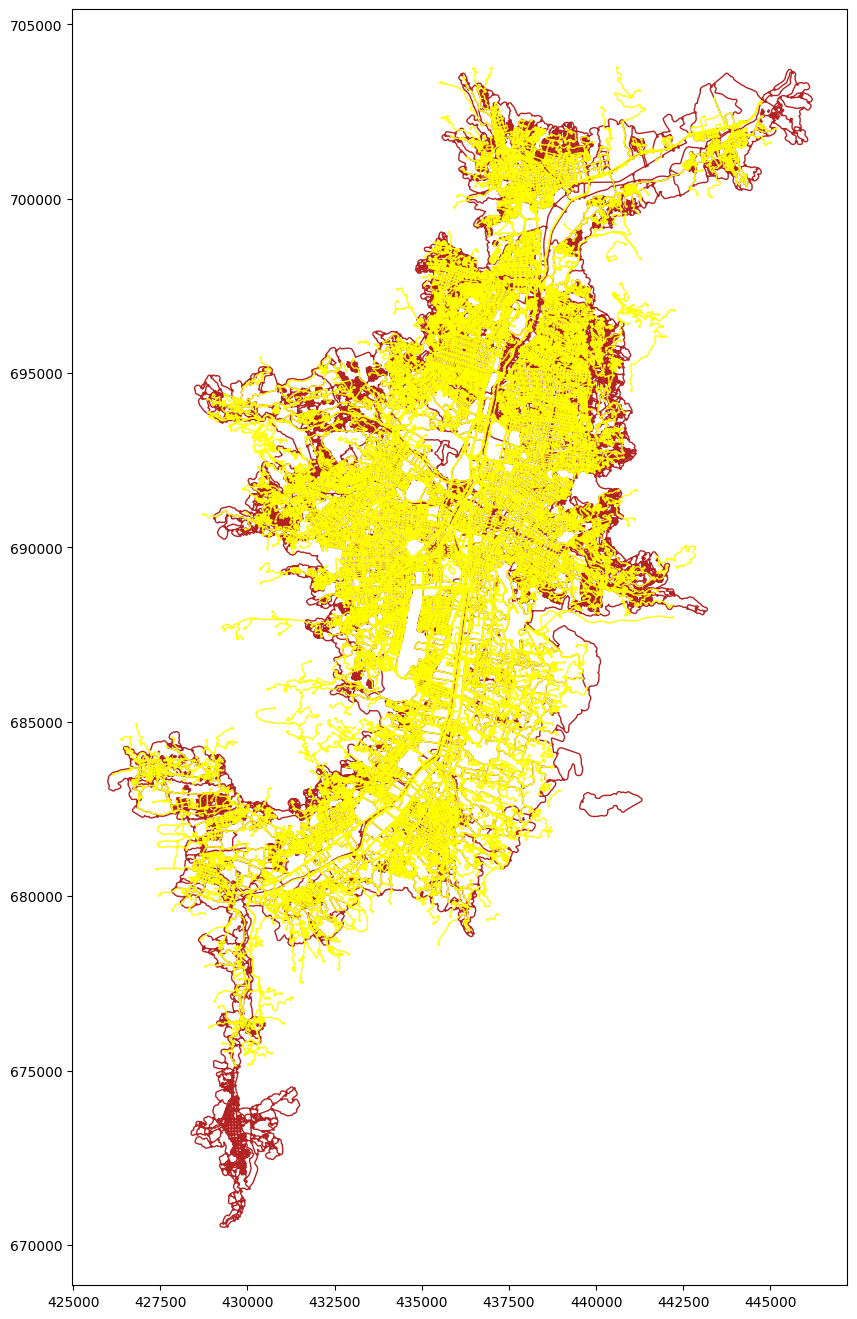

In [25]:
# Plot
fig,ax = plt.subplots(1,1,figsize=(10,20))

boeing_nodes.plot(ax=ax,zorder=3,color='yellow',markersize=1)
boeing_edges.plot(ax=ax,zorder=2,color='yellow',linewidth=1)
tess_nodes.plot(ax=ax,zorder=1,color='firebrick',markersize=1)
tess_edges.plot(ax=ax,zorder=0,color='firebrick',linewidth=1)

In [26]:
if localsave_01_01:
    # Current step output directory
    output_fold = output_dir + 'part01_step01_preprocess/'
    
    # Create folder if it doesn't exist
    if os.path.exists(output_fold) == False:
        os.mkdir(output_fold)
    
    # Save result
    boeing_nodes.to_file(output_fold + "boeing_nodes.gpkg")
    boeing_edges.to_file(output_fold + "boeing_edges.gpkg")
    tess_nodes.to_file(output_fold + "tess_nodes.gpkg")
    tess_edges.to_file(output_fold + "tess_edges.gpkg")

## __Part 01 - Step 02__ - Identify the parts of the Tessellations network that should be added to the Boeing network

This step identifies identifies the parts of the Tessellations network that should be added to the boeing network through the following steps:

base_network: boeing
complementary_network: tessellations

1. Extract the midpoint of each complementary edge
2. Create a contact-analysis buffer around mid_points
3. Find mid_points whose buffer does not intersect with any part of the base network
4. Select the complementary_nodes that connect to the uncovered edges found
5. Find the nodes that would be used to connect the uncovered part of the complementary network to the base network
6. Identify and shorten edges that extend into the base network and would be useful to create further connections

In [27]:
if load_datafor_part01_step02:
    boeing_nodes = gpd.read_file(output_dir + "part01_step01_preprocess/boeing_nodes.gpkg")
    boeing_edges = gpd.read_file(output_dir + "part01_step01_preprocess/boeing_edges.gpkg")
    tess_nodes = gpd.read_file(output_dir + "part01_step01_preprocess/tess_nodes.gpkg")
    tess_edges = gpd.read_file(output_dir + "part01_step01_preprocess/tess_edges.gpkg")

### __Part 01 - Step 02 -__ Identify the uncovered parts of the network and restore edges that were shortened from both sides

In [28]:
##### Time
time_1 = time.time()
##### Time

# Run identify_uncovered function
distance = 10
complementary_uncovered_nodes, complementary_uncovered_edges, contact_nodes, dropped_overlapping_edges = identify_uncovered(base_nodes = boeing_nodes,
                                                                                                                            base_edges = boeing_edges,
                                                                                                                            complementary_nodes = tess_nodes,
                                                                                                                            complementary_edges = tess_edges,
                                                                                                                            contact_analysis_dist = distance,
                                                                                                                            projected_crs = projected_crs)

##### Time
time_2 = time.time()
print(f"TIME: {time_2-time_1} seconds on identifying uncovered parts.")
##### Time

1.0 - Extracting mid_point point of each complementary edge.
2.0 - Creating contact-analysis buffer around each mid_point.
3.0 - Extracting complementary_uncovered_edges.
4.0 - Extracting complementary_uncovered_nodes.
5.0 - Extracting contact_nodes.
6.0 - Creating missing connections through complementary_edges that travel from the uncovered zone to the base network.
6.0 - Exploring osmids. 0% done.
6.0 - Exploring osmids. 5% done.
6.0 - Exploring osmids. 10% done.
6.0 - Exploring osmids. 15% done.
6.0 - Exploring osmids. 20% done.
6.0 - Exploring osmids. 25% done.
6.0 - Exploring osmids. 30% done.
6.0 - Exploring osmids. 35% done.
6.0 - Exploring osmids. 40% done.
6.0 - Exploring osmids. 45% done.
6.0 - Exploring osmids. 50% done.
6.0 - Exploring osmids. 55% done.
6.0 - Exploring osmids. 60% done.
6.0 - Exploring osmids. 65% done.
6.0 - Exploring osmids. 70% done.
6.0 - Exploring osmids. 75% done.
6.0 - Exploring osmids. 80% done.
6.0 - Exploring osmids. 85% done.
6.0 - Exploring osm

#### Restore edges that were shortened from both sides (u, v) to the original complete edge. (tmp fix)

In [29]:
# DOUBLE EDGE SHORTENING CANCELATION (TEMPORAL FIX) ### ### ### ### ### ### ### ### ### ### ### ###
# Edges that were shortened from both sides (u and v) are causing problems. 
# Due to the lack of time to adequately solve the problem, they are being dropped and replaced by the whole original edge.

### LOCATE THE EDGES THAT WERE CLIPPED FROM BOTH SIDES
# Drop NaNs in the output edges
double_clipping = complementary_uncovered_edges.replace({'original_edge_id': ''}, np.nan).dropna(subset=['original_edge_id']).copy()
# Look for duplicated original_edge_ids in the output edges
double_clipping = double_clipping.loc[double_clipping.duplicated('original_edge_id',keep=False)]

### FIND THE ORIGINAL EDGES FROM THE TESSELLATIONS NETWORK USING THE original_edge_id COLUMN
# Select original_edge_ids of interest
double_original_edge_ids = list(double_clipping.original_edge_id.unique())
# Create a unique edge_id in the tessellation edges (tess_edges)
tess_edges_tmp = src.create_unique_edge_id(tess_edges,order='uvkey')
# Find the original edges
double_original_edges = tess_edges_tmp.loc[tess_edges_tmp.edge_id.isin(double_original_edge_ids)].copy()

### REPLACE THOSE DOUBLE CLIPPED EDGES WITH THE WHOLE EDGE AND DROP THE CREATED NODES RESULTING FROM THE CLIPPING
## List of nodes to drop
# u and v values in currently clipped edges
unique_lst_clipped = list(set(double_clipping['u']).union(double_clipping['v']))
# u and v values in original edges
unique_lst_original = list(set(double_original_edges['u']).union(double_original_edges['v']))
# u and v values in clipped edges that are NOT in original edges
unique_in_clipped_not_original = list(set(unique_lst_clipped) - set(unique_lst_original))
## Drop those nodes
complementary_uncovered_nodes_clean = complementary_uncovered_nodes.loc[~complementary_uncovered_nodes.osmid.isin(unique_in_clipped_not_original)].copy()
contact_nodes_clean = contact_nodes.loc[~contact_nodes.osmid.isin(unique_in_clipped_not_original)].copy()

## Drop the double clipped edges and add the original edges
complementary_uncovered_edges_clean = complementary_uncovered_edges.loc[~complementary_uncovered_edges.original_edge_id.isin(double_original_edge_ids)].copy()
double_original_edges['clipping_i'] = 0
complementary_uncovered_edges_clean = pd.concat([complementary_uncovered_edges_clean, double_original_edges])

In [30]:
# Restore variable names for consistency with other steps and parts of the process
complementary_uncovered_nodes = complementary_uncovered_nodes_clean.copy()
complementary_uncovered_edges = complementary_uncovered_edges_clean.copy()
contact_nodes = contact_nodes_clean.copy()

del complementary_uncovered_nodes_clean
del complementary_uncovered_edges_clean
del contact_nodes_clean

In [31]:
if localsave_01_02:
    # Current step output directory
    output_fold = output_dir + 'part01_step02_identifyuncovered/'
    
    # Create folder if it doesn't exist
    if os.path.exists(output_fold) == False:
        os.mkdir(output_fold)
    
    # Save result
    complementary_uncovered_nodes.to_file(output_fold + "complementary_uncovered_nodes.gpkg")
    complementary_uncovered_edges.to_file(output_fold + "complementary_uncovered_edges.gpkg")
    contact_nodes.to_file(output_fold + "contact_nodes.gpkg")
    dropped_overlapping_edges.to_file(output_fold + "dropped_overlapping_edges.gpkg")

## __Part 02 - Step 01 -__ Networks intersection

This step __finds the intersection points existing__ between the base network and the uncovered parts of the complementary network, and then modifies both network in order to __incorporate the intersection points as new nodes__ on both networks.

In [32]:
if load_datafor_part02_step01:
    boeing_nodes = gpd.read_file(output_dir + "part01_step01_preprocess/boeing_nodes.gpkg")
    boeing_edges = gpd.read_file(output_dir + "part01_step01_preprocess/boeing_edges.gpkg")
    complementary_uncovered_nodes = gpd.read_file(output_dir + "part01_step02_identifyuncovered/complementary_uncovered_nodes.gpkg")
    complementary_uncovered_edges = gpd.read_file(output_dir + "part01_step02_identifyuncovered/complementary_uncovered_edges.gpkg")
    contact_nodes = gpd.read_file(output_dir + "part01_step02_identifyuncovered/contact_nodes.gpkg")

### __Part 02 - Step 01 -__ Find intersections between both networks

In [33]:
##### Time
time_1 = time.time()
##### Time

intersection_nodes = find_intersection_nodes(ntw_01_nodes = boeing_nodes,
                                             ntw_01_edges = boeing_edges,
                                             ntw_02_nodes = complementary_uncovered_nodes,
                                             ntw_02_edges = complementary_uncovered_edges,
                                             projected_crs = projected_crs)

##### Time
time_2 = time.time()
print(f"TIME: {time_2-time_1} seconds on finding all intersection nodes.")
##### Time

# Show
print(intersection_nodes.shape)
intersection_nodes.head(2)

Intersected networks and created intersection_points.
Set unique osmids to all intersection_points. Turned into intersection_nodes.
TIME: 15.206023931503296 seconds on finding all intersection nodes.
(4343, 8)


,u_1,v_1,key_1,u_2,v_2,key_2,geometry,osmid
0,4422701370153414,4421183170145994,0,4421618070148331,4421908970140404,0,POINT (442163.091 701478.227),0
1,4413540970133092,4413106170132302,0,4413394070131895,4413876970155506,0,POINT (441339.771 701328.324),2


In [34]:
# MULTIPLE INTERSECTIONs (Intersections where three or more lines cross at the same point)
mult_inters_nodes = intersection_nodes.loc[intersection_nodes.duplicated('osmid',keep=False)].copy()
print(f"Mult. int. osmids: {mult_inters_nodes.osmid.unique()}.")

# Save them (GIS Visualization)
save_mult_intrs_nodes = False
if save_mult_intrs_nodes:
    mult_inters_nodes.to_file(output_dir + "part02_step01_ntwsintersection/multiple_intersection_nodes.gpkg")
    
# Show
mult_inters_nodes

Mult. int. osmids: [].


,u_1,v_1,key_1,u_2,v_2,key_2,geometry,osmid


### __Part 02 - Step 01 -__ Update the base network with the new intersections

In [35]:
# Separate intersection_nodes in order to apply function network_intersections_update() for the base network
intersection_nodes_base = intersection_nodes[['osmid','u_1','v_1','key_1','geometry']].copy()
intersection_nodes_base.rename(columns={'u_1':'u',
                                        'v_1':'v',
                                        'key_1':'key'},inplace=True)
# Specify which edge to keep after spliting each edge with the intersection_nodes_base
# ('both' keeps both sides of split, 'u' or 'v' only keeps the side connected to that node.)
# ('both' activates 'return_all' in function edge_clipping())
intersection_nodes_base['retain_how'] = 'both'

##### Time
time_1 = time.time()
##### Time
# Apply network_intersections_update() function
base_nodes_i, base_edges_i = network_intersections_update(current_ntw_nodes = boeing_nodes,
                                                          current_ntw_edges = boeing_edges,
                                                          intersection_nodes = intersection_nodes_base,
                                                          projected_crs = projected_crs,
                                                          intersection_logs = False,
                                                          clipping_logs=False)
##### Time
time_2 = time.time()
print(f"TIME: {time_2-time_1} seconds on updating the network.")
##### Time

# MULTIPLE INTERSECTION ADAPTATION: drop duplicates
# Duplicated nodes and edges may occur when three or more lines cross at the same point.
# Regular .drop_duplicates() cannot be used since edges could be mirrored.
# Example:
#        Line 1: u=1, v=2, key=0, geom=((1,1),(2,1))
#        Line 2: u=2, v=1, key=0, geom=((2,1),(1,1))
# Drop nodes and edges duplicates
base_nodes_i,base_edges_i = drop_intersection_network_duplicates(base_nodes_i,base_edges_i)

##### Time
time_3 = time.time()
print(f"TIME: {time_3-time_2} seconds on dropping network duplicates.")
##### Time

# Show
print(base_nodes_i.shape)
base_nodes_i.head(2)

network_intersections_update(): Updating network...
network_intersections_update(): Starting iterating over each intersection_node.
network_intersections_update(): Iterating over intersection_nodes. 0% done.
network_intersections_update(): Iterating over intersection_nodes. 10% done.
network_intersections_update(): Iterating over intersection_nodes. 20% done.
network_intersections_update(): Iterating over intersection_nodes. 30% done.
network_intersections_update(): Iterating over intersection_nodes. 40% done.
network_intersections_update(): Iterating over intersection_nodes. 50% done.
network_intersections_update(): Iterating over intersection_nodes. 60% done.
network_intersections_update(): Iterating over intersection_nodes. 70% done.
network_intersections_update(): Iterating over intersection_nodes. 80% done.
network_intersections_update(): Iterating over intersection_nodes. 90% done.
Finished updating network.
TIME: 62.82252240180969 seconds on updating the network.
TIME: 0.2758088

,osmid,intersecting,geometry
0,4422701370153414,0,POINT (442270.137 701534.148)
1,4413540970133092,0,POINT (441354.098 701330.928)


In [36]:
# Show
print(base_edges_i.shape)
base_edges_i.head(2)

(37347, 5)


,u,v,key,intersecting,geometry
0,4422701370153414,4421875970152278,0,0,"LINESTRING (442270.137 701534.148, 442258.358 ..."
1,4426435970181999,4422701370153414,0,0,"LINESTRING (442643.594 701819.994, 442614.277 ..."


### __Part 02 - Step 01 -__ Update the complementary network with the new intersections

In [37]:
# Separate intersection_nodes in order to apply function network_intersections_update() for the complementary network.
intersection_nodes_comp = intersection_nodes[['osmid','u_2','v_2','key_2','geometry']].copy()
intersection_nodes_comp.rename(columns={'u_2':'u',
                                        'v_2':'v',
                                        'key_2':'key'},inplace=True)

# Specify which edge to keep after spliting each edge with the intersection_nodes_comp
# ('both' keeps both sides of split, 'u' or 'v' only keeps the side connected to that node.)
# ('both' activates 'return_all' in function edge_clipping())
intersection_nodes_comp['retain_how'] = 'both'

##### Time
time_1 = time.time()
##### Time

# Apply network_intersections_update() function
comp_nodes_i, comp_edges_i = network_intersections_update(current_ntw_nodes = complementary_uncovered_nodes,
                                                          current_ntw_edges = complementary_uncovered_edges,
                                                          intersection_nodes = intersection_nodes_comp,
                                                          projected_crs = projected_crs,
                                                          intersection_logs = False,
                                                          clipping_logs = False)

##### Time
time_2 = time.time()
print(f"TIME: {time_2-time_1} seconds on updating the network.")
##### Time

# MULTIPLE INTERSECTION ADAPTATION: drop duplicates
# Duplicated nodes and edges may occur when three or more lines cross at the same point.
# Regular .drop_duplicates() cannot be used since edges could be mirrored.
# Example:
#        Line 1: u=1, v=2, key=0, geom=((1,1),(2,1))
#        Line 2: u=2, v=1, key=0, geom=((2,1),(1,1))
# Drop nodes and edges duplicates
comp_nodes_i,comp_edges_i = drop_intersection_network_duplicates(comp_nodes_i,comp_edges_i)

##### Time
time_3 = time.time()
print(f"TIME: {time_3-time_2} seconds on dropping network duplicates.")
##### Time

# Show
print(comp_nodes_i.shape)
comp_nodes_i.head(2)

network_intersections_update(): Updating network...
network_intersections_update(): Starting iterating over each intersection_node.
network_intersections_update(): Iterating over intersection_nodes. 0% done.
network_intersections_update(): Iterating over intersection_nodes. 10% done.
network_intersections_update(): Iterating over intersection_nodes. 20% done.
network_intersections_update(): Iterating over intersection_nodes. 30% done.
network_intersections_update(): Iterating over intersection_nodes. 40% done.
network_intersections_update(): Iterating over intersection_nodes. 50% done.
network_intersections_update(): Iterating over intersection_nodes. 60% done.
network_intersections_update(): Iterating over intersection_nodes. 70% done.
network_intersections_update(): Iterating over intersection_nodes. 80% done.
network_intersections_update(): Iterating over intersection_nodes. 90% done.
Finished updating network.
TIME: 64.41456341743469 seconds on updating the network.
TIME: 0.5030193

,osmid,intersecting,geometry
0,4412182870168617,0,POINT (441218.29 701686.179)
1,4281962668347432,0,POINT (428196.267 683474.323)


In [38]:
print(comp_nodes_i.shape)
comp_nodes_i.head(2)

(25329, 3)


,osmid,intersecting,geometry
0,4412182870168617,0,POINT (441218.29 701686.179)
1,4281962668347432,0,POINT (428196.267 683474.323)


In [39]:
print(comp_edges_i.shape)
comp_edges_i.head(2)

(24514, 5)


,u,v,key,intersecting,geometry
0,4265806768335800,4266544168338172,0,0,"LINESTRING (426580.674 683358.007, 426581.531 ..."
1,4268400968272091,4265806768335800,0,0,"LINESTRING (426840.094 682720.918, 426837.562 ..."


In [40]:
if localsave_02_01:
    # Current step output directory
    output_fold = output_dir + 'part02_step01_ntwsintersection/'
    
    # Create folder if it doesn't exist
    if os.path.exists(output_fold) == False:
        os.mkdir(output_fold)
    
    # Save result
    intersection_nodes.to_file(output_fold + "networks_intersections.gpkg") 
    base_nodes_i.to_file(output_fold + "intersected_base_nodes.gpkg")
    base_edges_i.to_file(output_fold + "intersected_base_edges.gpkg")
    comp_nodes_i.to_file(output_fold + "intersected_comp_nodes.gpkg")
    comp_edges_i.to_file(output_fold + "intersected_comp_edges.gpkg")

## __Part 02 - Step 02 -__ Connection identification between networks

Through identifying the __nearest base_nodes_i and nearest base_edges_i to each contact_node__, this section creates a gdf that __stablishes the relationships__ between each contact_node (That all derive complementary network) and the node or edge on the boeing network were the connection will be later created.

If the connection is to be made __from contact_node to base_edge__, it identifies the best intersection point and saves the point with a new osmid in order to split the boeing_edge and __create a new base node__ there in an update network process.

In [41]:
if load_datafor_part02_step02:
    # From Part01 - Step02
    contact_nodes = gpd.read_file(output_dir + "part01_step02_identifyuncovered/contact_nodes.gpkg")
    # From Part02 - Step01
    base_nodes_i = gpd.read_file(output_dir + "part02_step01_ntwsintersection/intersected_base_nodes.gpkg")
    base_edges_i = gpd.read_file(output_dir + "part02_step01_ntwsintersection/intersected_base_edges.gpkg")
    comp_nodes_i = gpd.read_file(output_dir + "part02_step01_ntwsintersection/intersected_comp_nodes.gpkg")
    comp_edges_i = gpd.read_file(output_dir + "part02_step01_ntwsintersection/intersected_comp_edges.gpkg")

### __Part 02 - Step 02 -__ Find nearest base_nodes_i and nearest base_edges_i to each contact_node.

In [42]:
# Retrieve contact_nodes
print(contact_nodes.shape)
contact_nodes.head(2)

(11740, 6)


,osmid,geometry,streets_count,x,y,clipping_i
0,4281962668347432,POINT (428196.267 683474.323),3.0,428196.267415,683474.322981,0
1,4401128468849132,POINT (440112.846 688491.323),3.0,440112.845952,688491.323095,0


In [43]:
# Find nearest base_node to each contact_node
nearest_nodes = gpd.sjoin_nearest(contact_nodes, base_nodes_i, distance_col='node_distance')
# Merge nearest data
contact_nodes_1 = contact_nodes.merge(nearest_nodes[['osmid_right','node_distance']],left_index=True,right_index=True,how='outer')
# Save disk space
del nearest_nodes

# Show
print(contact_nodes_1.dtypes)
print(contact_nodes_1.shape)
contact_nodes_1.head(2)

osmid               int64
geometry         geometry
streets_count     float64
x                 float64
y                 float64
clipping_i          int64
osmid_right         int64
node_distance     float64
dtype: object
(11740, 8)


,osmid,geometry,streets_count,x,y,clipping_i,osmid_right,node_distance
0,4281962668347432,POINT (428196.267 683474.323),3.0,428196.267415,683474.322981,0,4282517468345678,58.184239
1,4401128468849132,POINT (440112.846 688491.323),3.0,440112.845952,688491.323095,0,4259,70.203571


In [44]:
# Find nearest base_edge to each contact_node
nearest_edges = gpd.sjoin_nearest(contact_nodes, base_edges_i, distance_col='edge_distance')
# It is unlikely that two edges are exacly at the same distance.
# If this happens it most likely means that are at the same distance because they meet at a node
# and the closest distance is exactly that point.
# --> Keep the first occurance
nearest_edges = nearest_edges.drop_duplicates(subset='osmid')

# Merge nearest data
contact_nodes_2 = contact_nodes_1.merge(nearest_edges[['u','v','key','edge_distance']],left_index=True,right_index=True,how='outer')
# Save disk space
del nearest_edges

# Show
print(contact_nodes_2.dtypes)
print(contact_nodes_2.shape)
contact_nodes_2.head(2)

osmid               int64
geometry         geometry
streets_count     float64
x                 float64
y                 float64
clipping_i          int64
osmid_right         int64
node_distance     float64
u                   int64
v                   int64
key                 int64
edge_distance     float64
dtype: object
(11740, 12)


,osmid,geometry,streets_count,x,y,clipping_i,osmid_right,node_distance,u,v,key,edge_distance
0,4281962668347432,POINT (428196.267 683474.323),3.0,428196.267415,683474.322981,0,4282517468345678,58.184239,4281183768347912,4282517468345678,0,9.141611
1,4401128468849132,POINT (440112.846 688491.323),3.0,440112.845952,688491.323095,0,4259,70.203571,4259,4401260468865659,0,7.902775


### __Part 02 - Step 02 -__ Define the best relation between networks for each contact_node.

In [45]:
# Find individual relations between contact_nodes_2 (renamed as connecting_nodes) and network 01 (base network).
# (Produces "connected_nodes" gdf, where these relations are saved, and also
# produces "intersection_nodes_2" gdf, which stores new nodes and edges to be split on network 01)

##### Time
time_1 = time.time()
##### Time

extended_logs = False # Used during Dev. Prints logs for each node.

# Rename gdfs to keep original (Used during Dev)
ntw_01_nodes = base_nodes_i.copy()
ntw_01_edges = base_edges_i.copy()
ntw_02_nodes = comp_nodes_i.copy()
ntw_02_edges = comp_edges_i.copy()
connecting_nodes = contact_nodes_2.copy()

# Reset produced osmids (Used in function produce_osmid())
previously_produced = 0

# List of nodes created by intersecting both networks
# (They are used to discard the creation of new intersections whenever 
#  nerby (20m) there's already an existing intersection between both networks)
intersecting_idx = ntw_01_nodes.intersecting==1
intersecting_osmids = list(ntw_01_nodes.loc[intersecting_idx].osmid.unique())

# Create connected_nodes, a DataFrame that will store the final defined connections between networks
# ----- OUTPUT DTYPES MANAGEMENT FOR connected_nodes DATAFRAME -----
# (e.g. node x from network 02 will be connecting to node y from network 01)
connected_nodes_cols = {"connecting_ntw02_osmid": "int64",
                        "connection_type": "string",
                        "connection_ntw01_osmid":"int64"
                       }
connected_nodes = pd.DataFrame(columns=connected_nodes_cols.keys()).astype(connected_nodes_cols)
# ----- OUTPUT DTYPES MANAGEMENT FOR connected_nodes DATAFRAME -----
i = 0 #Row count of the created df

# Create intersection_nodes_2, a GeoDataFrame that will be used in function network_intersections_update()
# to perform a second round of intersections on network_01 (after this process)
# ----- OUTPUT DTYPES MANAGEMENT FOR intersection_nodes_2 GEODATAFRAME -----
intersection_nodes_2_cols = {"osmid": "int64", # Node that is the intersection (clipping point)
                             "u": "int64", # Node that is the intersection (clipping point)
                             "v": "int64", # Edge that is intersected
                             "key": "int64", # Edge that is intersected
                             "edge_id": "string" # Edge id that is intersected (for 2.1 -- New nodes check)
                            }
intersection_nodes_2 = gpd.GeoDataFrame(columns=list(intersection_nodes_2_cols.keys()) + ["geometry"], crs=projected_crs).astype({**intersection_nodes_2_cols, "geometry": "geometry"})
# Reorder columns
intersection_nodes_2 = intersection_nodes_2[["osmid", "geometry", # Node to be created to serve as a connection point in ntw_01
                                             "u", "v", "key", "edge_id"]] # Edge from ntw_01 to be split by the created node
# ----- OUTPUT DTYPES MANAGEMENT FOR intersection_nodes_2 GEODATAFRAME -----
new_node_idx = 0 #Row count of the created gdf

# Iterate over each connecting_node (contact_nodes from identify_uncovered, with nearest_node from ntw_01 and nearest_edge from ntw_01 data)
for idx, node in connecting_nodes.iterrows():

    # Extract current connecting_node's data
    # Current connecting_node data [From ntw_02]
    cn_osmid = int(node.osmid)
    cn_geometry = node.geometry
    # nearest_node data [From ntw_01]
    cn_nearest_osmid = int(node.osmid_right)
    cn_node_distance = node.node_distance 
    # nearest_edge data [From ntw_01]
    cn_nearest_u = int(node.u)
    cn_nearest_v = int(node.v)
    cn_nearest_key = int(node.key)
    cn_edge_distance = node.edge_distance

    # Development checks -----------------------------------
    #osmid_checks = [89]
    #if cn_osmid not in osmid_checks:
    #    extended_logs=False
    #    previous_cn_osmid = cn_osmid
    #else:
    #    print(f"Previous cn_osmid: {previous_cn_osmid}.")
    #    print(f"Current cn_osmid: {cn_osmid}.")
    #    extended_logs=True
    # Development checks -----------------------------------
    
    # 1.0 --------------- CASE 1: Close intersection, discards connecting_node
    # ------------------- This case analyses the edges that connect to the current connecting_node.
    # ------------------- If there's already an intersection to the base network in 20 meters or less,
    # ------------------- assume this intersection could sustitute the connection that was going to be created.
    # ------------------- (Meaning, there's already a connection nearby, creating another would be redundant)
    # ------------------- --> ignore connecting_node (continue).

    # Identify the edges that connect to the current connecting_node
    connecting_node_edges = ntw_02_edges.loc[(ntw_02_edges.u==cn_osmid) | (ntw_02_edges.v==cn_osmid)].copy()
    # Extract the list of nodes ('u' and 'v') that those edges connect to
    connecting_node_osmids = set(list(connecting_node_edges.u.unique()) + list(connecting_node_edges.v.unique()))
    connecting_node_osmids.remove(cn_osmid) #Remove itself
    # From those connecting_node_osmids, extract those that are also intersecting_osmid (That intersect the network 01)    
    opposite_intersecting_osmid = [osmid for osmid in connecting_node_osmids if osmid in intersecting_osmids]
    # If they exist:
    if len(opposite_intersecting_osmid)>0:
        # Set connection to False until distance is verified
        existing_connection = False
        # Analyse the length of the edges connecting to the opposite_intersecting_osmids. 
        # For any edge connecting to an intersecting_node, if the length of that edge is less than 20 meters, 
        # register that there's already an existing connection nerby.
        edges_to_analyse = connecting_node_edges.loc[(connecting_node_edges.u.isin(opposite_intersecting_osmid)) | 
                                                     (connecting_node_edges.v.isin(opposite_intersecting_osmid))].copy()
        edges_to_analyse['length'] = edges_to_analyse.length
        for edge_length in list(edges_to_analyse.length.unique()):
            if edge_length < 20:
                existing_connection = True
                break
        # If the process found an existing connection, skip current connecting_node.
        # Else, goes to CASE 2.
        if existing_connection == True:
            # Connection registration
            # ----- OUTPUT REGISTRATION FOR connected_nodes DATAFRAME -----
            # Create temporary df with the current case's data
            df_temporal = pd.DataFrame({'connecting_ntw02_osmid': [int(cn_osmid)],
                                        'connection_type': ['existing'],
                                        'connection_ntw01_osmid': [int(0)], #Will not be connecting to network 01, just fills with 0
                                       })
            # Force all datatypes to match the datatypes of the df to where the data will be merged
            dtypes_dict = connected_nodes.dtypes.to_dict() #Dict with TARGET dtypes
            filtered_dtypes = {col: dtypes_dict[col] for col in df_temporal.columns if col in dtypes_dict} # Filters for cols in case of mismatch
            df_temporal = df_temporal.astype(filtered_dtypes) # Assigns those types
            # Concatenate to TARGET without altering original dtypes
            connected_nodes = pd.concat([connected_nodes, df_temporal], ignore_index=True)
            # ----- OUTPUT REGISTRATION FOR connected_nodes DATAFRAME -----
            i+=1
            if extended_logs:
                print(f"CASE 1: Connecting node {cn_osmid} already connects to an existing intersection in less than 20 meters.")
            continue # Next connecting_node
    
    # 2.0 --------------- CASE 2: Distance analysis
    # ------------------- If there's no existing intersection nerby, register connection to be created.
    
    # 2.1 --------------- New nodes check (If complies with a set of conditions, updates cn_nearest_osmid and cn_node_distance)
    # ------------------- The for loop iterating over connecting_nodes has a code section where new nodes can be created.
    # ------------------- This happens when a connection between a conecting_node and a ntw_01_edge is stablished.
    # ------------------- New nodes can also serve as a connection with between networks
    # ------------------- Considering them prevents multiple connections being created when an existing can be used.
    
    # Extract nearest edge's unique_id [From ntw_01]
    cn_edge_id = str(cn_nearest_u)+str(cn_nearest_v)+str(cn_nearest_key)
    # If there are already new_nodes registered, analyse distance to them. Else, skip.
    if new_node_idx > 0:
        # Check if this edge has already been used to stablish a connection with another connecting_node.
        # If so, a new_node will be created over this edge and that new_node could be used as a connection instead of creating another one.
        # So, if this edge is already registered in intersection_nodes_2, consider the new_node.
        intersected_edges = list(intersection_nodes_2['edge_id'].unique())
        if cn_edge_id in intersected_edges:
            # Obtain current conecting_node's coordinates [From ntw_02]
            conecting_nodes_coords = cn_geometry.coords[0]
            # Retrieve new_nodes (registered_nodes)
            registered_nodes = intersection_nodes_2.loc[intersection_nodes_2['edge_id'] == cn_edge_id].copy()
            registered_nodes.reset_index(inplace=True,drop=True)
            for node_idx in range(len(registered_nodes)):
                # Obtain registered node's coords [Of any new_node]
                registered_node = registered_nodes.iloc[node_idx]
                registered_node_coords = registered_node.geometry.coords[0]
                # Calculate distance between both nodes
                new_node_distance = distance_between_points(conecting_nodes_coords, registered_node_coords)
                # If new_node_distance is less than distance to current nearest node, update nearest node data
                if new_node_distance < cn_node_distance:
                    cn_nearest_osmid = registered_node.osmid
                    cn_node_distance = new_node_distance
    
    # 2.2 --------------- CASE 2a: Close node connection
    # If distance to nearest node is less or equal to 5 meters, register that connection (Ignores closest edge, takes closest node)
    if cn_node_distance<=5:
        # Connection registration
        # ----- OUTPUT REGISTRATION FOR connected_nodes DATAFRAME -----
        # Create temporary df with the current case's data
        df_temporal = pd.DataFrame({'connecting_ntw02_osmid': [int(cn_osmid)],
                                    'connection_type': ['node'],
                                    'connection_ntw01_osmid': [int(cn_nearest_osmid)],
                                   })
        # Force all datatypes to match the datatypes of the df to where the data will be merged
        dtypes_dict = connected_nodes.dtypes.to_dict() #Dict with TARGET dtypes
        filtered_dtypes = {col: dtypes_dict[col] for col in df_temporal.columns if col in dtypes_dict} # Filters for cols in case of mismatch
        df_temporal = df_temporal.astype(filtered_dtypes) # Assigns those types
        # Concatenate to TARGET without altering original dtypes
        connected_nodes = pd.concat([connected_nodes, df_temporal], ignore_index=True)
        # ----- OUTPUT REGISTRATION FOR connected_nodes DATAFRAME -----
        i+=1
        if extended_logs:
            print(f"CASE 2a: Connecting node {cn_osmid} connects to a node in less than 5 meters.")
        continue # Next connecting_node

    # If distance to nearest node is greater than 5 meters, analyse distance to edge
    elif cn_node_distance>5:
        
        # 2.3 --------------- CASE 2b: Edge connection
        # If the nearest_edge is closer than the (nearest_node-5 meters)
        # (Meaning, if the nearest_edge is closer even when we give 5 meter preference to the node over the edge) 
        # --> Create and register join with nearest_edge (nearest_edge gets split to create a node for the connection between networks)
        node_distance_pref = cn_node_distance-5
        if cn_edge_distance < node_distance_pref:

            # 2.3.1 ------------- Create new node's data
            # Extract the nearest edge's geometry (LineString)
            nearest_edge = ntw_01_edges.loc[(ntw_01_edges.u==cn_nearest_u) & 
                                            (ntw_01_edges.v==cn_nearest_v) &
                                            (ntw_01_edges.key==cn_nearest_key)].copy()
            nearest_edge.reset_index(inplace=True,drop=True)
            edge_geom = nearest_edge['geometry'].unique()[0]
            # Project current connecting_node into the edge's geometry
            projected_point = edge_geom.interpolate(edge_geom.project(cn_geometry))
            # Produce unique osmid
            produced_osmid = produce_osmid(ntw_01_nodes, ntw_02_nodes, previously_produced)
            # Since ntw_01_nodes and ntw_02_nodes are not being updated, next time (whenever another node falls in this case)
            # will try function produce_osmid() with next possible osmid.
            previously_produced = produced_osmid+1

            # 2.3.2 ------------- Register new_node's data and edge to be split by it.
            # ------------------- Will be used in function network_intersections_update()
            
            # ----- OUTPUT REGISTRATION FOR intersection_nodes_2 GEODATAFRAME -----
            # Create temporary df with the current case's data
            df_temporal = pd.DataFrame({'osmid': [int(produced_osmid)], # Node that is the intersection (clipping point)
                                        'geometry': [projected_point], # Node that is the intersection (clipping point)
                                        'u': [int(cn_nearest_u)], # Edge that is intersected
                                        'v':[int(cn_nearest_v)], # Edge that is intersected
                                        'key':[int(cn_nearest_key)], # Edge that is intersected
                                        'edge_id':[cn_edge_id] # Edge id that is intersected (for 2.1 -- New nodes check)
                                       }
                                      )
            if int(produced_osmid) == 17554:
                print(f"connecting_ntw02_osmid: {int(cn_osmid)}.")
                print(f"connection_ntw01_osmid: {int(produced_osmid)}.")
            
            gdf_temporal = gpd.GeoDataFrame(df_temporal, geometry='geometry', crs=projected_crs)
            # Force all datatypes to match the datatypes of the gdf to where the data will be merged
            dtypes_dict = connected_nodes.dtypes.to_dict() #Dict with TARGET dtypes
            filtered_dtypes = {col: dtypes_dict[col] for col in df_temporal.columns if col in dtypes_dict} # Filters for cols in case of mismatch
            gdf_temporal = gdf_temporal.astype(filtered_dtypes) # Assigns those types
            # Concatenate to TARGET without altering original dtypes
            intersection_nodes_2 = pd.concat([intersection_nodes_2, gdf_temporal], ignore_index=True)
            # ----- OUTPUT REGISTRATION FOR intersection_nodes_2 GEODATAFRAME -----
            new_node_idx+=1

            # 2.3.3 ------------- Connection registration
            # ----- OUTPUT REGISTRATION FOR connected_nodes DATAFRAME -----
            # Create temporary df with the current case's data
            df_temporal = pd.DataFrame({'connecting_ntw02_osmid': [int(cn_osmid)],
                                        'connection_type': ['node'],
                                        'connection_ntw01_osmid': [int(produced_osmid)],
                                       })
            # Force all datatypes to match the datatypes of the df to where the data will be merged
            dtypes_dict = connected_nodes.dtypes.to_dict() #Dict with TARGET dtypes
            filtered_dtypes = {col: dtypes_dict[col] for col in df_temporal.columns if col in dtypes_dict} # Filters for cols in case of mismatch
            df_temporal = df_temporal.astype(filtered_dtypes) # Assigns those types
            # Concatenate to TARGET without altering original dtypes
            connected_nodes = pd.concat([connected_nodes, df_temporal], ignore_index=True)
            # ----- OUTPUT REGISTRATION FOR connected_nodes DATAFRAME -----
            i+=1
            if extended_logs:
                print(f"CASE 2b: Connecting node {cn_osmid} produced a new node in an edge of the network 01.")
            continue # Next connecting_node

        # 2.4 --------------- CASE 2c: Node connection
        # If the (nearest_node-5 meters) is closer than the nearest_edge
        # --> Register node connection
        else:
            # Connection registration
            # ----- OUTPUT REGISTRATION FOR connected_nodes DATAFRAME -----
            # Create temporary df with the current case's data
            df_temporal = pd.DataFrame({'connecting_ntw02_osmid': [int(cn_osmid)],
                                        'connection_type': ['node'],
                                        'connection_ntw01_osmid': [int(cn_nearest_osmid)],
                                       })
            # Force all datatypes to match the datatypes of the df to where the data will be merged
            dtypes_dict = connected_nodes.dtypes.to_dict() #Dict with TARGET dtypes
            filtered_dtypes = {col: dtypes_dict[col] for col in df_temporal.columns if col in dtypes_dict} # Filters for cols in case of mismatch
            df_temporal = df_temporal.astype(filtered_dtypes) # Assigns those types
            # Concatenate to TARGET without altering original dtypes
            connected_nodes = pd.concat([connected_nodes, df_temporal], ignore_index=True)
            # ----- OUTPUT REGISTRATION FOR connected_nodes DATAFRAME -----
            i+=1
            if extended_logs:
                print(f"CASE 2c: Connecting node {cn_osmid} connects to a node in less than 5 meters.")
            continue # Next connecting_node

# Final format (Set unique identifiers to int) to connected_nodes's columns
no_longer_needed = """ [SOLVED USING OUTPUT DTYPES MANAGEMENT AND REGISTRATION]
connected_nodes['connecting_ntw02_osmid'] = connected_nodes['connecting_ntw02_osmid'].astype('int')
connected_nodes['connection_ntw01_osmid'].fillna(value=0, inplace=True)# Existing connections do not register osmid, set to 0
connected_nodes['connection_ntw01_osmid'] = connected_nodes['connection_ntw01_osmid'].astype('int')
# Final format (Set unique identifiers to int) to intersection_nodes_2's columns
intersection_nodes_2['osmid'] = intersection_nodes_2['osmid'].astype('int')
intersection_nodes_2['u'] = intersection_nodes_2['u'].astype('int')
intersection_nodes_2['v'] = intersection_nodes_2['v'].astype('int')
intersection_nodes_2['key'] = intersection_nodes_2['key'].astype('int')
"""

##### Time
time_2 = time.time()
print(f"TIME: {time_2-time_1} seconds on defining the best relations.")
##### Time

# Show
print(connected_nodes.dtypes)
print(connected_nodes.shape)
connected_nodes.head(2)

TIME: 54.715008020401 seconds on defining the best relations.
connecting_ntw02_osmid             int64
connection_type           string[python]
connection_ntw01_osmid             int64
dtype: object
(11740, 3)


,connecting_ntw02_osmid,connection_type,connection_ntw01_osmid
0,4281962668347432,node,6548
1,4401128468849132,node,6549


In [46]:
# Show gdf that will be used to update network 01 (base_network)
print(intersection_nodes_2.dtypes)
print(intersection_nodes_2.shape)

print("--"*30)
print("These intersections (A specific osmid crossing at a specific edge_id) should not have duplicates.")
print(f"INTERSECTIONS DUPLICATES: {len(intersection_nodes_2.loc[intersection_nodes_2.duplicated(subset=['osmid','edge_id'])])}.")
print("--"*30)
intersection_nodes_2.head(2)

osmid          int64
geometry    geometry
u              int64
v              int64
key            int64
edge_id       object
dtype: object
(5458, 6)
------------------------------------------------------------
These intersections (A specific osmid crossing at a specific edge_id) should not have duplicates.
INTERSECTIONS DUPLICATES: 0.
------------------------------------------------------------


,osmid,geometry,u,v,key,edge_id
0,6548,POINT (428194.585 683465.338),4281183768347912,4282517468345678,0,428118376834791242825174683456780
1,6549,POINT (440120.742 688491.653),4259,4401260468865659,0,425944012604688656590


In [47]:
if localsave_02_02:
    # Current step output directory
    output_fold = output_dir + 'part02_step02_connectidentif/'
    
    # Create folder if it doesn't exist
    if os.path.exists(output_fold) == False:
        os.mkdir(output_fold)
    
    # Save result
    connected_nodes.to_csv(output_fold + "connected_nodes_df.csv",index=False)
    intersection_nodes_2.to_file(output_fold + "intersection_nodes_2.gpkg")

## __Part 02 - Step 03 -__ Network concatenation

This step __updates the base network__ (In order to include the new nodes created in order to join a contact_node and a base_edge) and __joins (concatenates) both network's nodes and edges__ into a single gdf each.

In [48]:
if load_datafor_part02_step03:
    # From Part02 - Step01
    base_nodes_i = gpd.read_file(output_dir + "part02_step01_ntwsintersection/intersected_base_nodes.gpkg")
    base_edges_i = gpd.read_file(output_dir + "part02_step01_ntwsintersection/intersected_base_edges.gpkg")
    comp_nodes_i = gpd.read_file(output_dir + "part02_step01_ntwsintersection/intersected_comp_nodes.gpkg")
    comp_edges_i = gpd.read_file(output_dir + "part02_step01_ntwsintersection/intersected_comp_edges.gpkg")
    # From Part02 - Step02
    intersection_nodes_2 = gpd.read_file(output_dir + "part02_step02_connectidentif/intersection_nodes_2.gpkg")

### __Part 02 - Step 03 -__ Re-update the network 01 (Base network)

In [49]:
# Apply network_intersections_update() function

##### Time
time_1 = time.time()
##### Time

# Specify which edge to keep after spliting each edge with the intersection_nodes_2
# ('both' keeps both sides of split, 'u' or 'v' only keeps the side connected to that node.)
# ('both' activates 'return_all' in function edge_clipping())
intersection_nodes_2['retain_how'] = 'both'

# (Second round of intersections, derived from new nodes created from network_02 to edges on network_01)
base_nodes_i2, base_edges_i2 = network_intersections_update(current_ntw_nodes = base_nodes_i,
                                                            current_ntw_edges = base_edges_i,
                                                            intersection_nodes = intersection_nodes_2,
                                                            projected_crs = projected_crs,
                                                            intersection_logs = False,
                                                            clipping_logs=False)

# Nodes marked as "intersecting" on this round are nodes created specifically in order to connect the
# network_02 to an edge on network_01. Distinguish them (For GIS visualization)
base_nodes_i2.rename(columns={'intersecting':'ntw_join'},inplace=True)

##### Time
time_2 = time.time()
print(f"TIME: {time_2-time_1} seconds on re-updating the base network.")
##### Time

# Show
print(base_nodes_i2.dtypes)
print(base_nodes_i2.shape)
base_nodes_i2.head(2)

network_intersections_update(): Updating network...
network_intersections_update(): Starting iterating over each intersection_node.
network_intersections_update(): Iterating over intersection_nodes. 0% done.
network_intersections_update(): Iterating over intersection_nodes. 10% done.
network_intersections_update(): Iterating over intersection_nodes. 20% done.
network_intersections_update(): Iterating over intersection_nodes. 30% done.
network_intersections_update(): Iterating over intersection_nodes. 40% done.
network_intersections_update(): Iterating over intersection_nodes. 50% done.
network_intersections_update(): Iterating over intersection_nodes. 60% done.
network_intersections_update(): Iterating over intersection_nodes. 70% done.
network_intersections_update(): Iterating over intersection_nodes. 80% done.
network_intersections_update(): Iterating over intersection_nodes. 90% done.
Finished updating network.
TIME: 82.84900379180908 seconds on re-updating the base network.
osmid  

,osmid,ntw_join,geometry
0,4422701370153414,0,POINT (442270.137 701534.148)
1,4413540970133092,0,POINT (441354.098 701330.928)


In [50]:
# Show base_nodes tail detail
print("--"*30)
print(f"NODES DUPLICATES: {len(base_nodes_i2.loc[base_nodes_i2.duplicated(subset=['osmid'])])}.")
print("--"*30)
base_nodes_i2.tail(2)

------------------------------------------------------------
NODES DUPLICATES: 0.
------------------------------------------------------------


,osmid,ntw_join,geometry
32323,12004,1,POINT (429594.846 693683.416)
32324,12005,1,POINT (430223.404 694913.905)


In [51]:
# Show base_edges
print(base_edges_i2.dtypes)
base_edges_i2.head(2)

u                  int64
v                  int64
key                int64
intersecting       int64
geometry        geometry
dtype: object


,u,v,key,intersecting,geometry
0,4422701370153414,4421875970152278,0,0,"LINESTRING (442270.137 701534.148, 442258.358 ..."
1,4426435970181999,4422701370153414,0,0,"LINESTRING (442643.594 701819.994, 442614.277 ..."


In [52]:
# Show base_edges tail detail
test_base_edges_i2 = base_edges_i2.copy()
test_base_edges_i2 = src.create_unique_edge_id(test_base_edges_i2)
print("--"*30)
print(f"EDGES DUPLICATES: {len(test_base_edges_i2.loc[test_base_edges_i2.duplicated(subset=['edge_id'])])}.")
print("--"*30)
del test_base_edges_i2
base_edges_i2.tail(2)

------------------------------------------------------------
EDGES DUPLICATES: 0.
------------------------------------------------------------


,u,v,key,intersecting,geometry
42803,3895,12005,0,1,"LINESTRING (430419.705 695014.362, 430410.456 ..."
42804,12005,8141,0,1,"LINESTRING (430223.404 694913.905, 430222.813 ..."


In [53]:
# Show complementary_nodes
print(comp_nodes_i.dtypes)
print(comp_nodes_i.shape)
comp_nodes_i.head(2)

osmid              int64
intersecting       int64
geometry        geometry
dtype: object
(25329, 3)


,osmid,intersecting,geometry
0,4412182870168617,0,POINT (441218.29 701686.179)
1,4281962668347432,0,POINT (428196.267 683474.323)


In [54]:
# Show complementary_edges
print(comp_edges_i.dtypes)
print(comp_edges_i.shape)
comp_edges_i.head(2)

u                  int64
v                  int64
key                int64
intersecting       int64
geometry        geometry
dtype: object
(24514, 5)


,u,v,key,intersecting,geometry
0,4265806768335800,4266544168338172,0,0,"LINESTRING (426580.674 683358.007, 426581.531 ..."
1,4268400968272091,4265806768335800,0,0,"LINESTRING (426840.094 682720.918, 426837.562 ..."


### __Part 02 - Step 03 -__ Concatenate both networks (Not yet physically connected by edges)

In [55]:
# Concatenate nodes

# Prepare data for concatenation
ntw_01_nodes_prep = base_nodes_i2[['osmid','ntw_join','geometry']].copy()
ntw_02_nodes_prep = comp_nodes_i[['osmid','geometry']].copy()

# Add missing 'ntw_join' col to ntw_02_nodes_prep
ntw_02_nodes_prep['ntw_join'] = 0

# Differenciate networks's origin
ntw_01_nodes_prep['ntw_origin'] = 'ntw_01'
ntw_02_nodes_prep['ntw_origin'] = 'ntw_02'

# Concatenate nodes
concatenated_nodes = pd.concat([ntw_01_nodes_prep,ntw_02_nodes_prep])
node_count_1 = len(concatenated_nodes)

# Drop duplicated nodes
concatenated_nodes.drop_duplicates(subset=['osmid','geometry'],inplace=True)
node_count_2 = len(concatenated_nodes)
print(f"Both networks where sharing nodes where there is an intersection between networks. Duplicates were expected but no longer needed.")
print(f"Dropped {node_count_1-node_count_2} nodes duplicated when intersecting networks.")

# Reset index
concatenated_nodes.reset_index(inplace=True,drop=True)

# Show
print(concatenated_nodes.dtypes)
print(concatenated_nodes.shape)
concatenated_nodes.head(2)

Both networks where sharing nodes where there is an intersection between networks. Duplicates were expected but no longer needed.
Dropped 4343 nodes duplicated when intersecting networks.
osmid            int64
ntw_join         int64
geometry      geometry
ntw_origin      object
dtype: object
(53311, 4)


,osmid,ntw_join,geometry,ntw_origin
0,4422701370153414,0,POINT (442270.137 701534.148),ntw_01
1,4413540970133092,0,POINT (441354.098 701330.928),ntw_01


In [56]:
# Concatenate edges

# Prepare data for concatenation
ntw_01_edges_prep = base_edges_i2[['u','v','key','geometry']].copy()
ntw_02_edges_prep = comp_edges_i[['u','v','key','geometry']].copy()

# Add missing 'ntw_join' col to both gdfs
ntw_01_edges_prep['ntw_join'] = 0
ntw_02_edges_prep['ntw_join'] = 0

# Differenciate networks
ntw_01_edges_prep['ntw_origin'] = 'ntw_01'
ntw_02_edges_prep['ntw_origin'] = 'ntw_02'

# Concatenate edges
concatenated_edges = pd.concat([ntw_01_edges_prep,ntw_02_edges_prep])

# Drop duplicated edges ('u','v','key' and 'geometry' (There should be 0))
edge_count_1 = len(concatenated_edges)
concatenated_edges.drop_duplicates(subset=['u','v','key','geometry'],inplace=True)
edge_count_2 = len(concatenated_edges)
print(f"There should be 0 duplicated ('u','v','key','geometry') edges. Dropped {edge_count_1-edge_count_2}.")

# Fix shared edge_ids by re-assigning all 'key's for duplicated edges.
# An edge from network 01 might go from the same u to the same v as an edge from the network 02 if any (or both) of them were split by an intersection.
# If this happens, they would both have the same 'u', 'v' and 'key', but different paths (geometry).
print(f"After concatenating both networks, found {len(concatenated_edges.loc[concatenated_edges.duplicated(subset=['u','v','key'])])} edges with the same unique ID ('u', 'v' and 'key'). Fixing edge IDs")
# Calculate edges lentgh
concatenated_edges['length'] = concatenated_edges.to_crs(projected_crs).length
# Add key column, all zeros
concatenated_edges['key'] = 0
# Fix keys
concatenated_edges = src.resolve_duplicates_indexes(concatenated_edges, projected_crs)
print(f"Fixed edge IDs. Duplicates: {len(concatenated_edges.loc[concatenated_edges.duplicated(subset=['u','v','key'])])}.")

# Show
print(concatenated_edges.dtypes)
print(concatenated_edges.shape)
concatenated_edges.head(2)

There should be 0 duplicated ('u','v','key','geometry') edges. Dropped 0.
After concatenating both networks, found 105 edges with the same unique ID ('u', 'v' and 'key'). Fixing edge IDs
Fixed edge IDs. Duplicates: 0.
u                int64
v                int64
key              int64
geometry      geometry
ntw_join         int64
ntw_origin      object
length         float64
dtype: object
(67319, 7)


,u,v,key,geometry,ntw_join,ntw_origin,length
0,4422701370153414,4421875970152278,0,"LINESTRING (442270.137 701534.148, 442258.358 ...",0,ntw_01,83.859717
1,4426435970181999,4422701370153414,0,"LINESTRING (442643.594 701819.994, 442614.277 ...",0,ntw_01,470.675913


In [57]:
if localsave_02_03:
    # Current step output directory
    output_fold = output_dir + 'part02_step03_ntwsconcat/'
    
    # Create folder if it doesn't exist
    if os.path.exists(output_fold) == False:
        os.mkdir(output_fold)
    
    # Save result
    concatenated_nodes.to_file(output_fold + "concatenated_nodes.gpkg")
    concatenated_edges.to_file(output_fold + "concatenated_edges.gpkg")

## __Part 02 - Step 04 -__ Connect networks

Using the connected_nodes df (Created in Part 02 - Step 02), which stablishes the relations between conection_nodes (from network 02, complementary network) and nodes in network 01 (base network), in this step __new edges that connect both networks are drawn.__

After that __consequential intersections__ (Which occur when the drawn edge crosses another edge in its way to connect network 01 and 02) __are fixed__ according to its nature (CASE A, CASE B or CASE C).

In [58]:
if load_datafor_part02_step04:
    # From Part02 - Step02
    connected_nodes = pd.read_csv(output_dir + "part02_step02_connectidentif/connected_nodes_df.csv")
    # From Part02 - Step03
    concatenated_nodes = gpd.read_file(output_dir + "part02_step03_ntwsconcat/concatenated_nodes.gpkg")
    concatenated_edges = gpd.read_file(output_dir + "part02_step03_ntwsconcat/concatenated_edges.gpkg")

### __Part 02 - Step 04 -__ Draw new edges and identify consequential intersections

In [59]:
# Show
print(connected_nodes.info())
connected_nodes.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11740 entries, 0 to 11739
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   connecting_ntw02_osmid  11740 non-null  int64 
 1   connection_type         11740 non-null  string
 2   connection_ntw01_osmid  11740 non-null  int64 
dtypes: int64(2), string(1)
memory usage: 275.3 KB
None


,connecting_ntw02_osmid,connection_type,connection_ntw01_osmid
0,4281962668347432,node,6548
1,4401128468849132,node,6549


In [60]:
# Show
print(concatenated_nodes.info())
concatenated_nodes.head(2)

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 53311 entries, 0 to 53310
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   osmid       53311 non-null  int64   
 1   ntw_join    53311 non-null  int64   
 2   geometry    53311 non-null  geometry
 3   ntw_origin  53311 non-null  object  
dtypes: geometry(1), int64(2), object(1)
memory usage: 1.6+ MB
None


,osmid,ntw_join,geometry,ntw_origin
0,4422701370153414,0,POINT (442270.137 701534.148),ntw_01
1,4413540970133092,0,POINT (441354.098 701330.928),ntw_01


In [61]:
# Show
print(concatenated_edges.info())
concatenated_edges.head(2)

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 67319 entries, 0 to 57423
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   u           67319 non-null  int64   
 1   v           67319 non-null  int64   
 2   key         67319 non-null  int64   
 3   geometry    67319 non-null  geometry
 4   ntw_join    67319 non-null  int64   
 5   ntw_origin  67319 non-null  object  
 6   length      67319 non-null  float64 
dtypes: float64(1), geometry(1), int64(4), object(1)
memory usage: 4.1+ MB
None


,u,v,key,geometry,ntw_join,ntw_origin,length
0,4422701370153414,4421875970152278,0,"LINESTRING (442270.137 701534.148, 442258.358 ...",0,ntw_01,83.859717
1,4426435970181999,4422701370153414,0,"LINESTRING (442643.594 701819.994, 442614.277 ...",0,ntw_01,470.675913


In [62]:
casetype_logs = False

# Function that compares geometries (Points) considering a tolerance of 1mm 
def geometries_are_equal_with_tolerance(geom1, geom2, tolerance=0.001): 
    return geom1.equals(geom2) or geom1.distance(geom2) < tolerance

##### Time
time_1 = time.time()
##### Time

# Reset previously_produced osmids (Used in function produce_osmid())
previously_produced = 0

# Create intersection_nodes_3, a GeoDataFrame that will be used in function network_intersections_update()
# to perform a third round of intersections (Used to fix consequential intersections)
# ----- OUTPUT DTYPES MANAGEMENT FOR intersection_nodes_3 GEODATAFRAME -----
intersection_nodes_3_cols = {"osmid": "int64", # Node that is the intersection (clipping point)
                             "u": "int64", # Edge that is intersected
                             "v": "int64", # Edge that is intersected
                             "key": "int64", # Edge that is intersected
                             "retain_how":"string", #Stablishes which part of the split edge to keep
                             "edge_origin":"string", #Helps divide network_intersections_update() process
                             "case":"string" #Helps identify if an splitting case must not be repeated in an edge
                            }
intersection_nodes_3 = gpd.GeoDataFrame(columns=list(intersection_nodes_3_cols.keys()) + ["geometry"], crs=projected_crs).astype({**intersection_nodes_3_cols, "geometry": "geometry"})
# Reorder columns
intersection_nodes_3 = intersection_nodes_3[["osmid", "geometry", # Node to be created to serve as a connection point in ntw_01
                                             "u", "v", "key", # Edge from ntw_01 to be split by the created node
                                             "retain_how", "edge_origin","case"]] # Data about the split and division of splitting process
# ----- OUTPUT DTYPES MANAGEMENT FOR intersection_nodes_3 GEODATAFRAME -----

# Store the osmids and edge_ids created to join both networks (To identify them after the process)
all_join_osmids = []
ntw_join_edgeids = []

# Consequential_intersections and its three cases (A, B and C) explanation.
# The concatenated_edges are renamed joined_edges_concat.
# The following code iterates over the connected_nodes df (The dataframe with defined relations between networks) and
# draws the new needed edges (when needed). The new edges sometimes intersect other edges as a consequence of them being straight lines between
# nodes. These new intersections are called consequential_intersections.
# The first connected_node explores consequential_intersections with the existing concatenated_edges (renamed as joined_edges_concat), but
# since the new-drawn-edge gets added to joined_edges_concat, the following connected_node also explores consequential_intersections with any
# recently-drawn edge. This results in cases A, B and C explored at the end of the for loop.

print("Identifying edge_ids origin (ntw_01 or ntw_02).")
# Create joined_edges_concat with a column for edge_id
joined_edges_concat = src.create_unique_edge_id(concatenated_edges)
# Extract edge_ids that are known to be either ntw_01 or ntw_02
ntw01_edges_ids = set(joined_edges_concat.loc[joined_edges_concat.ntw_origin=='ntw_01'].edge_id.unique())
ntw02_edges_ids = set(joined_edges_concat.loc[joined_edges_concat.ntw_origin=='ntw_02'].edge_id.unique())

# LOG CODE - Progress logs
# Will create progress logs when progress reaches these percentages:
progress_logs = [0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100] # for log statistics
progress_count = 0
# LOG CODE - Progress logs

##### Time - Divided processes time measurements
edge_produced_intersections_time = 0
consequential_intersections_time = 0
##### Time - Divided processes time measurements

# Iterate over each relation stablished
print("Starting iteration over each relation stablished.")
for idx, connected_node in connected_nodes.iterrows():

    ##### Time
    time_a = time.time()
    ##### Time

    # LOG CODE - Progress logs
    # Measures current progress, prints if passed a checkpoint of progress_logs list.
    current_progress = (progress_count / len(connected_nodes))*100
    for checkpoint in progress_logs:
        if (current_progress >= checkpoint):
            print(f"Categorizing node relation types. {checkpoint}% done.")
            progress_logs.remove(checkpoint)
            break
    # LOG CODE - Progress logs
    
    # Development checks -----------------------------------
    #current_osmid = connected_node.connecting_ntw02_osmid
    #osmid_checks = [67074577229143110]
    #if current_osmid not in osmid_checks:
    #    continue
    #else:
    #    print(current_osmid)
    # Development checks -----------------------------------
    
    # Extract relation's data
    # The following words are used to refer to the origin of data:
    # 'connection' refers to the data from network 01,
    # 'connecting' referes to data from network 02.
    # The reasoning used is that network 02 (complementary) is ---connecting--> to network 01 (base)
    connection_ntw01_osmid = connected_node.connection_ntw01_osmid
    connection_type = connected_node.connection_type
    connecting_ntw02_osmid = connected_node.connecting_ntw02_osmid

    # If the connection for the current connecting_node was identified to already exist nearby (Part 02 - Step 02), --> skip (continue)
    if connection_type == 'existing':
        # LOG CODE - Progress logs
        progress_count+=1
        # LOG CODE - Progress logs
        continue # Next nodes_relation

    # Identify the node's coordinates on ntw_01 that's going to get connected to the node on ntw_02
    connection_node_gdf = concatenated_nodes.loc[concatenated_nodes.osmid==connection_ntw01_osmid].copy()
    # Safety check (in case a node failed in re-update of the network)
    if len(connection_node_gdf)<1:
        print("--"*30)
        print(f"WARNING: Skipping node not found. Connection (ntw01): {connection_ntw01_osmid}. Connecting (ntw02): {connecting_ntw02_osmid}.")
        print("--"*30)
        continue
    connection_node_geom = connection_node_gdf.geometry.unique()[0]
    connection_node_coords = connection_node_geom.coords[0]
    if casetype_logs:
        print(f"ntw_01 - connection_node_geom: {connection_node_geom}.") 
    
    # Identify the node's coordinates on ntw_02 that's going to get connected to the node on ntw_01
    connecting_node_gdf = concatenated_nodes.loc[concatenated_nodes.osmid==connecting_ntw02_osmid].copy()
    # Safety check (in case a node failed in re-update of the network)
    if len(connecting_node_gdf)<1:
        print("--"*30)
        print(f"WARNING: Skipping node not found. Connection (ntw01): {connection_ntw01_osmid}. Connecting (ntw02): {connecting_ntw02_osmid}.")
        print("--"*30)
        continue
    connecting_node_geom = connecting_node_gdf.geometry.unique()[0]
    connecting_node_coords = connecting_node_geom.coords[0]
    if casetype_logs:
        print(f"ntw_02 - connecting_node_geom: {connecting_node_geom}.") 

    # Create LineString between connection_node and connecting_node
    line_geom = LineString([[connection_node_coords[0],connection_node_coords[1]],[connecting_node_coords[0],connecting_node_coords[1]]])
    
    # Store new LineString to concat to joined_edges_concat and to analyse consequential_intersections
    # ----- OUTPUT REGISTRATION FOR new_edge IN joined_edges_concat GEODATAFRAME ----- [Concatenates after overlay]
    # Create temporary df with the current case's data
    df_temporal = pd.DataFrame({'u': [int(connecting_ntw02_osmid)], # Edge that is being created
                                'v': [int(connection_ntw01_osmid)], # Edge that is being created
                                'key': [int(0)], # Edge that is being created
                                'geometry':[line_geom], # Edge that is being created
                                'ntw_join':[int(1)], # Helps identify which edges were created to join both networks
                                'ntw_origin':['ntw_join'] # Has data of all origins, created edges get assigned "ntw_join"
                               }
                              )
    new_edge = gpd.GeoDataFrame(df_temporal, geometry='geometry', crs=projected_crs)
    # Force all datatypes to match the datatypes of the gdf to where the data will be merged
    dtypes_dict = joined_edges_concat.dtypes.to_dict() #Dict with TARGET dtypes
    filtered_dtypes = {col: dtypes_dict[col] for col in new_edge.columns if col in dtypes_dict} # Filters for cols in case of mismatch
    new_edge = new_edge.astype(filtered_dtypes) # Assigns those types
    if casetype_logs:
        print(f"Created edge between connection and connecting nodes.") 
    # ----- OUTPUT REGISTRATION FOR new_edge IN joined_edges_concat GEODATAFRAME ----- [Concatenates after overlay]
    
    # Create unique edge_id for new_edge (requires input ID cols as int)
    new_edge = src.create_unique_edge_id(new_edge)

    # Store the edge_ids created to join both networks (To identify them after the process)
    join_edge_ids = list(new_edge.edge_id.unique())
    ntw_join_edgeids = ntw_join_edgeids + join_edge_ids
    
    # Find all intersections that the new edge creates on the current network edges
    # (Used to search for consequential_intersections)
    produced_intersections = joined_edges_concat.overlay(new_edge,how='intersection',keep_geom_type=False)
    
    # Concatenate new_edge to joined_edges_concat gdf 
    # (It is after .overlay(), else the LineString intersects with itself)
    joined_edges_concat = pd.concat([joined_edges_concat,new_edge])
    joined_edges_concat.reset_index(inplace=True,drop=True)

    # CONSEQUENTIAL INTERSECTIONS ANALYSIS
    # Explode the produced_intersections (If the new edge intersected the same edge twice or more, it produces MultiPoints)
    produced_intersections = produced_intersections.explode(index_parts=False)
    produced_intersections.reset_index(inplace=True,drop=True)
    
    # Remove from the produced_intersections the nodes that are currently being joined (Obviously, the line that connects them intersects with them)
    joined_nodes_lst = [connection_node_geom,connecting_node_geom] #Starting and ending nodes of the connecting edge itself
    if casetype_logs:
        print(f"Looking for produced intersections. Dropping intersections with {joined_nodes_lst}.")
    # Compare produced_intersections with starting and ending nodes, and filter for those that are not them
    produced_intersections = produced_intersections.loc[ ~produced_intersections['geometry'].apply(
        lambda x: any(geometries_are_equal_with_tolerance(x, node_geom) for node_geom in joined_nodes_lst))].copy()
    # Previous way of comparing (Sometimes failed to identify when the line intersected it's own node)
    #produced_intersections = produced_intersections.loc[~produced_intersections['geometry'].isin(joined_nodes_lst)].copy()
    
    if casetype_logs:
        print(f"Found intersections at the following points: {produced_intersections['geometry'].unique()}.")

    ##### Time
    time_b = time.time()
    ##### Time
    
    # If there are any intersections remaining, they are consequential_intersections.
    # (Meaning, the drawn line is intersecting with other lines in an undesired way)
    if len(produced_intersections)>0:

        # Rename gdf as "consequential_intersections"
        consequential_intersections = produced_intersections.copy()
        consequential_intersections.reset_index(inplace=True,drop=True)
        del produced_intersections

        if len(consequential_intersections)>1:
            print(f"NOTE: Edge drawn between connection_ntw01_osmid {connection_ntw01_osmid} and connecting_ntw02_osmid {connecting_ntw02_osmid} produced {len(consequential_intersections)} consequential intersection.")
        if len(consequential_intersections)>10:
            print("--"*30)
            print(f"WARNING: Edge drawn between connection_ntw01_osmid {connection_ntw01_osmid} and connecting_ntw02_osmid {connecting_ntw02_osmid} produced {len(consequential_intersections)} consequential intersection.")
            print("--"*30)
        
        # Rename columns to distinguish network origin
        # (Overlay produced _1 for joined_edges_concat data and _2 for new_edge data)
        consequential_intersections.rename(columns={'edge_id_1':'intersected_edge_id',
                                                    'edge_id_2':'drawn_edge_id'},inplace=True)
        
        # Load any edges related to the connection [ntw_01] node
        connection_related_idx = (joined_edges_concat.u==connection_ntw01_osmid)|(joined_edges_concat.v==connection_ntw01_osmid)
        connection_related_edges = joined_edges_concat.loc[connection_related_idx].copy()
        connection_related_edges_ids = list(connection_related_edges['edge_id'].unique())
        
        # Load any edges related to the connecting [ntw_02] node
        connecting_related_idx = (joined_edges_concat.u==connecting_ntw02_osmid)|(joined_edges_concat.v==connecting_ntw02_osmid)
        connecting_related_edges = joined_edges_concat.loc[connecting_related_idx].copy()
        connecting_related_edges_ids = list(connecting_related_edges['edge_id'].unique())
        
        # Iterate over consequential_intersections:
        for idx,intersection in consequential_intersections.iterrows():
    
            # Extract intersection's data
            # Edge that was intersected
            intersected_u = int(intersection.u_1)
            intersected_v = int(intersection.v_1)
            intersected_key = intersection.key_1
            intersected_edge_id = intersection.intersected_edge_id
            # Find intersected edge's origin
            if intersected_edge_id in ntw01_edges_ids:
                intersected_edge_origin = 'ntw_01'
            elif intersected_edge_id in ntw02_edges_ids:
                intersected_edge_origin = 'ntw_02'
            elif intersected_edge_id in ntw_join_edgeids:
                print(f"NOTE: Intersected edge id {intersected_edge_id} found in ntw_join_edgeids while intersecting with drawn edge {drawn_edge_id}.")
                intersected_edge_origin = 'ntw_join'
            else:
                print(f"WARNING: Could not identify edge {intersected_edge_id}'s origin, intersecting with drawn edge {drawn_edge_id}. Assigning ntw_join.")
                intersected_edge_origin = 'ntw_join'
                
            # New (drawn) edge that is intersecting
            drawn_edge_u = int(intersection.u_2)
            drawn_edge_v = int(intersection.v_2)
            drawn_edge_key = intersection.key_2
            drawn_edge_id = intersection.drawn_edge_id

            # The intersection will most likely become a new node
            # Extract its geometry and produce a unique osmid
            intersectionpoint_geom = intersection.geometry
            produced_osmid = produce_osmid(concatenated_nodes, concatenated_nodes, previously_produced)
            # Since concatenated_nodes are not being updated, next time try with next possible osmid
            previously_produced = produced_osmid+1 
            # Store the osmids created to join both networks (To identify them after the process)
            all_join_osmids.append(produced_osmid)

            # Cases analysis
            # n.n --------------- CASE A
            if intersected_edge_id in connection_related_edges_ids:
                # CASE A: The new edge intersects an edge comming out of the node __TO__ where the connection was being performed.
                # --> CASE A will draw the connection from the connecting_node on ntw02 to the intersection point ONLY.
                # -->        because thats were there's already a known connection with ntw01.
                # -->        The connection_related_edge gets split to add a new node, keeping both sides of the edge.
                # -->        The drawn edge gets split at the intersection, keeping one side of the edge.
                case = 'CASE A'
                if casetype_logs:
                    print(f"CASE A: New edge from connecting node {connecting_ntw02_osmid} intersects an edge comming out of the node TO where the connection was being performed.")
                # Register how both edges will be clipped
                # ----- OUTPUT REGISTRATION FOR intersection_nodes_3 GEODATAFRAME -----
                # Create temporary df with the current case's data
                # (First element of each list is a network 01 or network 02 edge (intersected))
                # (Second element of each list is the new (drawn) edge)
                df_temporal = pd.DataFrame({'osmid': [int(produced_osmid), int(produced_osmid)],
                                            'geometry': [intersectionpoint_geom, intersectionpoint_geom], # Node that is the intersection (clipping point)
                                            'u': [int(intersected_u), int(drawn_edge_u)], # Edge that is intersected
                                            'v':[int(intersected_v), int(drawn_edge_v)], # Edge that is intersected
                                            'key':[int(intersected_key),int(drawn_edge_key)], # Edge that is intersected
                                            'retain_how':['both','u'], #Keeps both parts of the intersected edge, and just side comming from ntw02 ('u') of the drawn edge
                                            'edge_origin':[intersected_edge_origin,'ntw_join'], #Edge's origin
                                            "case":[case,case] #Data about the registered case
                                           }
                                          )
                gdf_temporal = gpd.GeoDataFrame(df_temporal, geometry='geometry', crs=projected_crs)
                # Force all datatypes to match the datatypes of the gdf to where the data will be merged
                dtypes_dict = intersection_nodes_3.dtypes.to_dict() #Dict with TARGET dtypes
                filtered_dtypes = {col: dtypes_dict[col] for col in gdf_temporal.columns if col in dtypes_dict} # Filters for cols in case of mismatch
                gdf_temporal = gdf_temporal.astype(filtered_dtypes) # Assigns those types
                # Concatenate to TARGET without altering original dtypes
                intersection_nodes_3 = pd.concat([intersection_nodes_3, gdf_temporal], ignore_index=True)
                # ----- OUTPUT REGISTRATION FOR intersection_nodes_3 GEODATAFRAME -----                

            # n.n --------------- CASE B
            elif intersected_edge_id in connecting_related_edges_ids:
                # CASE B: The new edge intersects an edge comming out of the node __FROM__ where the connection was being performed.
                # --> CASE B will draw the connection from the intersection point to the connection_node on ntw_01 ONLY.
                # -->        because the rest (from intersection point to ntw02) is redundant.
                # -->        The connecting_related_edge gets split to add a new node, keeping both sides of the edge.
                # -->        The drawn edge gets split at the intersection, keeping one side of the edge.
                case = 'CASE B'
                if casetype_logs:
                    print(f"CASE B: New edge from connecting node {connecting_ntw02_osmid} intersects an edge comming out of the node FROM where the connection was being performed.")
                # Register how both edges will be clipped
                # ----- OUTPUT REGISTRATION FOR intersection_nodes_3 GEODATAFRAME -----
                # Create temporary df with the current case's data
                # (First element of each list is a network 01 or network 02 edge (intersected))
                # (Second element of each list is the new (drawn) edge)
                df_temporal = pd.DataFrame({'osmid': [int(produced_osmid), int(produced_osmid)],
                                            'geometry': [intersectionpoint_geom, intersectionpoint_geom], # Node that is the intersection (clipping point)
                                            'u': [int(intersected_u), int(drawn_edge_u)], # Edge that is intersected
                                            'v':[int(intersected_v), int(drawn_edge_v)], # Edge that is intersected
                                            'key':[int(intersected_key),int(drawn_edge_key)], # Edge that is intersected
                                            'retain_how':['both','v'], #Keeps both parts of the intersected edge, and just side comming from ntw01 ('v') of the drawn edge
                                            'edge_origin':[intersected_edge_origin,'ntw_join'], #Edge's origin
                                            "case":[case,case] #Data about the registered case
                                           }
                                          )
                gdf_temporal = gpd.GeoDataFrame(df_temporal, geometry='geometry', crs=projected_crs)
                # Force all datatypes to match the datatypes of the gdf to where the data will be merged
                dtypes_dict = intersection_nodes_3.dtypes.to_dict() #Dict with TARGET dtypes
                filtered_dtypes = {col: dtypes_dict[col] for col in gdf_temporal.columns if col in dtypes_dict} # Filters for cols in case of mismatch
                gdf_temporal = gdf_temporal.astype(filtered_dtypes) # Assigns those types
                # Concatenate to TARGET without altering original dtypes
                intersection_nodes_3 = pd.concat([intersection_nodes_3, gdf_temporal], ignore_index=True)
                # ----- OUTPUT REGISTRATION FOR intersection_nodes_3 GEODATAFRAME ----- 
            
            # n.n --------------- CASE C
            else:
                # CASE C: The new edge intersects with either network 01 or network 02 at an UNRELATED edge.
                #         (Or at a related ntw02 edge, but one that shouldn't be cut)
                # --> CASE C will draw only create a new node on the intersection and split the edges, 
                # -->        keeping both sides on both split edges.
                # -->        ntw01 or ntw02 edge gets split to add a new node, keeping both sides of the edge.
                # -->        drawn edge gets split at the intersection, keeping both sides of the edge.
                case = 'CASE C'
                if casetype_logs:
                    print(f"CASE C: New edge from connecting node {connecting_ntw02_osmid} intersects with either network 01 or network 02 at an UNRELATED edge.")
                # Register how both edges will be clipped
                # ----- OUTPUT REGISTRATION FOR intersection_nodes_3 GEODATAFRAME -----
                # Create temporary df with the current case's data
                # (First element of each list is a network 01 or network 02 edge (intersected))
                # (Second element of each list is the new (drawn) edge)
                df_temporal = pd.DataFrame({'osmid': [int(produced_osmid), int(produced_osmid)],
                                            'geometry': [intersectionpoint_geom, intersectionpoint_geom], # Node that is the intersection (clipping point)
                                            'u': [int(intersected_u), int(drawn_edge_u)], # Edge that is intersected
                                            'v':[int(intersected_v), int(drawn_edge_v)], # Edge that is intersected
                                            'key':[int(intersected_key),int(drawn_edge_key)], # Edge that is intersected
                                            'retain_how':['both','both'], #Keeps both parts of the intersected edge, and both parts of the drawn edge
                                            'edge_origin':[intersected_edge_origin,'ntw_join'], #Edge's origin
                                            "case":[case,case] #Data about the registered case
                                           }
                                          )
                gdf_temporal = gpd.GeoDataFrame(df_temporal, geometry='geometry', crs=projected_crs)
                # Force all datatypes to match the datatypes of the gdf to where the data will be merged
                dtypes_dict = intersection_nodes_3.dtypes.to_dict() #Dict with TARGET dtypes
                filtered_dtypes = {col: dtypes_dict[col] for col in gdf_temporal.columns if col in dtypes_dict} # Filters for cols in case of mismatch
                gdf_temporal = gdf_temporal.astype(filtered_dtypes) # Assigns those types
                # Concatenate to TARGET without altering original dtypes
                intersection_nodes_3 = pd.concat([intersection_nodes_3, gdf_temporal], ignore_index=True)
                # ----- OUTPUT REGISTRATION FOR intersection_nodes_3 GEODATAFRAME ----- 
    
    # LOG CODE - Progress logs
    # Finished reviewing current osmid. Continue with next osmid in non_contact_osmids.
    progress_count+=1
    # LOG CODE - Progress logs
    
    ##### Time
    time_c = time.time()
    edge_produced_intersections_time = edge_produced_intersections_time + (time_b - time_a)
    consequential_intersections_time = consequential_intersections_time + (time_c - time_b)
    ##### Time

# Create a edge_id col for the intersected edges registered for each intersection on intersection_nodes_3 gdf
intersection_nodes_3 = src.create_unique_edge_id(intersection_nodes_3)

##### Time
time_2 = time.time()
print(f"TIME: {time_2-time_1} seconds on drawing edges and identifying consequential intersections.")
print(f"Of that TIME, {edge_produced_intersections_time} seconds on stablishing the edge and finding all produced intersections.")
print(f"Of that TIME, {consequential_intersections_time} seconds dealing with consequential intersections.")
##### Time

# Show
print(joined_edges_concat.shape)
print(f"Duplicates: {len(joined_edges_concat.loc[joined_edges_concat.duplicated('edge_id')])}.")
joined_edges_concat.tail(2)

Identifying edge_ids origin (ntw_01 or ntw_02).
Starting iteration over each relation stablished.
Categorizing node relation types. 0% done.
Categorizing node relation types. 5% done.
Categorizing node relation types. 10% done.
Categorizing node relation types. 15% done.
Categorizing node relation types. 20% done.
Categorizing node relation types. 25% done.
Categorizing node relation types. 30% done.
Categorizing node relation types. 35% done.
Categorizing node relation types. 40% done.
Categorizing node relation types. 45% done.
Categorizing node relation types. 50% done.
Categorizing node relation types. 55% done.
NOTE: Edge drawn between connection_ntw01_osmid 4392809069682093 and connecting_ntw02_osmid 4392874669682219 produced 2 consequential intersection.
Categorizing node relation types. 60% done.
Categorizing node relation types. 65% done.
Categorizing node relation types. 70% done.
NOTE: Edge drawn between connection_ntw01_osmid 5698 and connecting_ntw02_osmid 4306127369089098

,u,v,key,geometry,ntw_join,ntw_origin,length,edge_id
75861,2428,12004,0,"LINESTRING (429594.846 693683.416, 429597.756 ...",1,ntw_join,NaN,2428120040
75862,2429,12005,0,"LINESTRING (430223.404 694913.905, 430218.166 ...",1,ntw_join,NaN,2429120050


In [63]:
# Show
print(intersection_nodes_3.shape)
print(f"Duplicates: {len(intersection_nodes_3.loc[intersection_nodes_3.duplicated(['osmid','edge_id'])])}.")
intersection_nodes_3.head(2)

(108, 9)
Duplicates: 0.


,osmid,geometry,u,v,key,retain_how,edge_origin,case,edge_id
0,12006,POINT (435587.458 696786.999),4355897369679999,3505,0,both,ntw_01,CASE A,435589736967999935050
1,12006,POINT (435587.458 696786.999),4355871369679158,3505,0,u,ntw_join,CASE A,435587136967915835050


In [65]:
# Save sub-step (Not final Part 02 Step 04 result)
if localsave_02_04:
    
    # Current sub-step output directory
    output_fold = output_dir + 'part02_step04_ntwsconnect/'
    
    # Create folder if it doesn't exist
    if os.path.exists(output_fold) == False:
        os.mkdir(output_fold)
    
    # Save result
    joined_edges_concat.to_file(output_fold + "tmp_joined_edges_concat.gpkg")
    intersection_nodes_3.to_file(output_fold + "tmp_intersection_nodes_3.gpkg")

### __Part 02 - Step 04 -__ Fix consequential_intersections

In [66]:
if load_datafor_substep_part02_step04:
    # From Part02 - Step03
    concatenated_nodes = gpd.read_file(output_dir + "part02_step03_ntwsconcat/concatenated_nodes.gpkg")
    # From previous substep (Draw new edges and identify consequential intersections)
    joined_edges_concat = gpd.read_file(output_dir + "part02_step04_ntwsconnect/tmp_joined_edges_concat.gpkg")
    intersection_nodes_3 = gpd.read_file(output_dir + "part02_step04_ntwsconnect/tmp_intersection_nodes_3.gpkg")

In [67]:
concatenated_nodes.head(1)

,osmid,ntw_join,geometry,ntw_origin
0,4422701370153414,0,POINT (442270.137 701534.148),ntw_01


In [68]:
joined_edges_concat.head(1)

,u,v,key,geometry,ntw_join,ntw_origin,length,edge_id
0,4422701370153414,4421875970152278,0,"LINESTRING (442270.137 701534.148, 442258.358 ...",0,ntw_01,83.859717,442270137015341444218759701522780


In [69]:
intersection_nodes_3.head(1)

,osmid,geometry,u,v,key,retain_how,edge_origin,case,edge_id
0,12006,POINT (435587.458 696786.999),4355897369679999,3505,0,both,ntw_01,CASE A,435589736967999935050


In [70]:
##### Time
time_1 = time.time()
##### Time

# Apply network_intersections_update() function
joined_nodes_fix, joined_edges_fix = network_intersections_update(current_ntw_nodes = concatenated_nodes,
                                                                  current_ntw_edges = joined_edges_concat,
                                                                  intersection_nodes = intersection_nodes_3,
                                                                  projected_crs = projected_crs,
                                                                  consider_ntw_origin = True,
                                                                  intersection_logs = False,
                                                                  clipping_logs=False)
##### Time
time_2 = time.time()
print(f"TIME: {time_2-time_1} seconds on updating the network.")
##### Time

# MULTIPLE INTERSECTION ADAPTATION: drop duplicates
# Duplicated nodes and edges may occur when three or more lines cross at the same point.
# Regular .drop_duplicates() cannot be used since edges could be mirrored.
# Example:
#        Line 1: u=1, v=2, key=0, geom=((1,1),(2,1))
#        Line 2: u=2, v=1, key=0, geom=((2,1),(1,1))
# Drop nodes and edges duplicates
joined_nodes_fix,joined_edges_fix = drop_intersection_network_duplicates(joined_nodes_fix,joined_edges_fix)

##### Time
time_3 = time.time()
print(f"TIME: {time_3-time_2} seconds on dropping intersection duplicates.")
##### Time

# Create unique edge_id to simplify edge identification
joined_edges_fix = src.create_unique_edge_id(joined_edges_fix)
# Identify edges created during current intersection
no_longer_in_use = """ [Substituted by adding 'consider_ntw_origin' to function network_intersections_update()]
join_idx = joined_edges_fix.intersecting==1
edge_ids_lst = list(joined_edges_fix.loc[join_idx].edge_id.unique())
all_join_edgeids = all_join_edgeids + edge_ids_lst
"""

# Final format (Drop cols 'intersecting' and reset indexes)
joined_nodes_fix.drop(columns=['intersecting'],inplace=True)
joined_edges_fix.drop(columns=['intersecting'],inplace=True)
joined_nodes_fix.reset_index(inplace=True,drop=True)
joined_edges_fix.reset_index(inplace=True,drop=True)

# Show
print(joined_nodes_fix.shape)
joined_nodes_fix.head(2)

network_intersections_update(): Updating network...
network_intersections_update(): Registering all edge_ids by origin...
network_intersections_update(): Starting iterating over each intersection_node.
network_intersections_update(): Iterating over intersection_nodes. 0% done.
network_intersections_update(): Iterating over intersection_nodes. 10% done.
network_intersections_update(): Iterating over intersection_nodes. 20% done.
network_intersections_update(): Iterating over intersection_nodes. 30% done.
network_intersections_update(): Iterating over intersection_nodes. 40% done.

                    Error on intersection_node 12029:
                    Could not select intersected_edge after looking at 0 edges while searching for substitute for original edge 430612736908909856980.
                    ERROR: Printing filtered edges found near intersection_node (edge_data=0) and returning current_ntw_nodes and current_ntw_edges.
                    Empty GeoDataFrame
Columns: [geometry, 

,osmid,ntw_origin,geometry
0,4422701370153414,ntw_01,POINT (442270.137 701534.148)
1,4413540970133092,ntw_01,POINT (441354.098 701330.928)


In [71]:
# Show
print(joined_edges_fix.shape)
joined_edges_fix.head(2)

(75933, 6)


,u,v,key,ntw_origin,geometry,edge_id
0,4422701370153414,4421875970152278,0,ntw_01,"LINESTRING (442270.137 701534.148, 442258.358 ...",442270137015341444218759701522780
1,4426435970181999,4422701370153414,0,ntw_01,"LINESTRING (442643.594 701819.994, 442614.277 ...",442643597018199944227013701534140


### __Part 02 - Step 04 -__ Retrieve origin data

In [72]:
no_longer_in_use = """ [Substituted by adding 'consider_ntw_origin' to function network_intersections_update()]
# Nodes from ntw_01
ntw01_nodes_osmid = list(concatenated_nodes.loc[concatenated_nodes.ntw_origin=='ntw_01'].osmid.unique())
join_idx = joined_nodes_fix.osmid.isin(ntw01_nodes_osmid)
joined_nodes_fix.loc[join_idx,'ntw_origin'] = 'ntw_01'

# Nodes from ntw_02
ntw02_nodes_osmid = list(concatenated_nodes.loc[concatenated_nodes.ntw_origin=='ntw_02'].osmid.unique())
join_idx = joined_nodes_fix.osmid.isin(ntw02_nodes_osmid)
joined_nodes_fix.loc[join_idx,'ntw_origin'] = 'ntw_02'

# Nodes used to join both networks (all_join_osmids)
join_idx = joined_nodes_fix.osmid.isin(all_join_osmids)
joined_nodes_fix.loc[join_idx,'ntw_origin'] = 'ntw_join'
"""

# Origin assignment test
len_ntw01_nodes = len(joined_nodes_fix.loc[joined_nodes_fix.ntw_origin=='ntw_01'])
len_ntw02_nodes = len(joined_nodes_fix.loc[joined_nodes_fix.ntw_origin=='ntw_02'])
len_ntwjoin_nodes = len(joined_nodes_fix.loc[joined_nodes_fix.ntw_origin=='ntw_join'])
print(f"Identified origin of {len_ntw01_nodes + len_ntw02_nodes + len_ntwjoin_nodes} nodes.")

# Show
print(joined_nodes_fix.shape)
joined_nodes_fix.head(2)

Identified origin of 53365 nodes.
(53365, 3)


,osmid,ntw_origin,geometry
0,4422701370153414,ntw_01,POINT (442270.137 701534.148)
1,4413540970133092,ntw_01,POINT (441354.098 701330.928)


In [73]:
# Show detail
print(joined_nodes_fix.crs)
print(joined_nodes_fix.dtypes)
joined_nodes_fix.tail(10)

EPSG:32618
osmid            int64
ntw_origin      object
geometry      geometry
dtype: object


,osmid,ntw_origin,geometry
53355,12050,ntw_join,POINT (435824.086 698245.86)
53356,12051,ntw_join,POINT (440470.459 691318.506)
53357,12052,ntw_join,POINT (440405.58 690799.794)
53358,12053,ntw_join,POINT (437073.962 681285.116)
53359,12054,ntw_join,POINT (439387.883 693128.866)
53360,12055,ntw_join,POINT (436083.138 691647.749)
53361,12056,ntw_join,POINT (437291.472 693772.849)
53362,12057,ntw_join,POINT (436382.913 688263.356)
53363,12058,ntw_join,POINT (440069.395 692966.45)
53364,12059,ntw_join,POINT (439455.107 690144.892)


In [74]:
no_longer_in_use = """ [Substituted by adding 'consider_ntw_origin' to function network_intersections_update()]
# Edges from ntw_01
ntw01_edges_ids = list(joined_edges_concat.loc[joined_edges_concat.ntw_origin=='ntw_01'].edge_id.unique())
join_idx = joined_edges_fix.edge_id.isin(ntw01_edges_ids)
joined_edges_fix.loc[join_idx,'ntw_origin'] = 'ntw_01'

# Edges from ntw_02
ntw02_edges_ids = list(joined_edges_concat.loc[joined_edges_concat.ntw_origin=='ntw_02'].edge_id.unique())
join_idx = joined_edges_fix.edge_id.isin(ntw02_edges_ids)
joined_edges_fix.loc[join_idx,'ntw_origin'] = 'ntw_02'

# Edges used to join both networks (all_join_edgeids)
join_idx = joined_edges_fix.edge_id.isin(all_join_edgeids)
joined_edges_fix.loc[join_idx,'ntw_origin'] = 'ntw_join'
"""

# Origin assignment test
len_ntw01_edges = len(joined_edges_fix.loc[joined_edges_fix.ntw_origin=='ntw_01'])
len_ntw02_edges = len(joined_edges_fix.loc[joined_edges_fix.ntw_origin=='ntw_02'])
len_ntwjoin_edges = len(joined_edges_fix.loc[joined_edges_fix.ntw_origin=='ntw_join'])
print(f"Identified origin of {len_ntw01_edges + len_ntw02_edges + len_ntwjoin_edges} edges.")

# Show
print(joined_edges_fix.shape)
joined_edges_fix.head(2)

Identified origin of 75933 edges.
(75933, 6)


,u,v,key,ntw_origin,geometry,edge_id
0,4422701370153414,4421875970152278,0,ntw_01,"LINESTRING (442270.137 701534.148, 442258.358 ...",442270137015341444218759701522780
1,4426435970181999,4422701370153414,0,ntw_01,"LINESTRING (442643.594 701819.994, 442614.277 ...",442643597018199944227013701534140


In [75]:
# Show detail
print(joined_edges_fix.crs)
print(joined_edges_fix.dtypes)
joined_edges_fix.tail(10)

EPSG:32618
u                int64
v                int64
key              int64
ntw_origin      object
geometry      geometry
edge_id         object
dtype: object


,u,v,key,ntw_origin,geometry,edge_id
75923,2386,12057,0,ntw_join,"LINESTRING (436382.913 688263.356, 436383.141 ...",2386120570
75924,12057,6313,0,ntw_join,"LINESTRING (436379.711 688250.086, 436382.913 ...",1205763130
75925,4400808969292048,12058,0,ntw_02,"LINESTRING (440080.89 692920.484, 440080.89 69...",4400808969292048120580
75926,12058,4400695069296877,0,ntw_02,"LINESTRING (440069.395 692966.45, 440069.431 6...",1205844006950692968770
75927,2425,12058,0,ntw_join,"LINESTRING (440069.395 692966.45, 440075.667 6...",2425120580
75928,12058,4400665569296561,0,ntw_join,"LINESTRING (440066.551 692965.613, 440069.395 ...",1205844006655692965610
75929,4394556469014558,12059,0,ntw_02,"LINESTRING (439455.647 690145.582, 439455.107 ...",4394556469014558120590
75930,12059,4394462369009468,0,ntw_02,"LINESTRING (439455.107 690144.892, 439447.078 ...",1205943944623690094680
75931,2426,12059,0,ntw_join,"LINESTRING (439455.107 690144.892, 439451.471 ...",2426120590
75932,12059,4394585769014166,0,ntw_join,"LINESTRING (439458.57 690141.668, 439455.107 6...",1205943945857690141660


In [76]:
if localsave_02_04:
    # Current step output directory
    output_fold = output_dir + 'part02_step04_ntwsconnect/'
    
    # Create folder if it doesn't exist
    if os.path.exists(output_fold) == False:
        os.mkdir(output_fold)
    
    # Save result
    joined_nodes_fix.to_file(output_fold + "joined_nodes_fix.gpkg")
    joined_edges_fix.to_file(output_fold + "joined_edges_fix.gpkg")

## __Part 02 - Step 05 -__ Network cleaning

This step cleans the joined network (nodes and edges) by analysing the number of edges that use each node (osmid).

1. Osmids that recieve __0 edges__ should be __deleted__. They are unconnected.
2. Osmids that recieve __1 edge__ will be __deleted__ (Along with that edge) __IF__ their ntw origin is __not ntw_01.__ (ntw_01 is the 'reliable' base_network, deleting osmids and edges this way would remove dead end streets).
3. Osmids that recieve __2 edges__ will be __joined__ (Shouldn't be an intersection, but a continous edge).
4. Osmids that recieve __3 or more edges__ are regular intersections. Nothing is done with them.

In [77]:
if load_datafor_part02_step05:
    # From Part02 - Step04
    joined_nodes_fix = gpd.read_file(output_dir + "part02_step04_ntwsconnect/joined_nodes_fix.gpkg")
    joined_edges_fix = gpd.read_file(output_dir + "part02_step04_ntwsconnect/joined_edges_fix.gpkg")

### __Part 02 - Step 05 -__ Data preparation

In [78]:
joined_nodes_cleaning = joined_nodes_fix.copy()
joined_edges_cleaning = joined_edges_fix.copy()

In [79]:
# No duplicates in osmid check
print(joined_nodes_cleaning.shape)
test = joined_nodes_cleaning.copy()
test.drop_duplicates(subset='osmid',inplace=True)
print(test.shape)
# Geometry revision (Should be all points)
print(f"GEOMETRIES: ---> {joined_nodes_cleaning.geom_type.value_counts()}.")
joined_nodes_cleaning.head(2)

(53365, 3)
(53365, 3)
GEOMETRIES: ---> Point    53365
Name: count, dtype: int64.


,osmid,ntw_origin,geometry
0,4422701370153414,ntw_01,POINT (442270.137 701534.148)
1,4413540970133092,ntw_01,POINT (441354.098 701330.928)


In [80]:
# No duplicates in 'u', 'v', 'key' check
print(joined_edges_cleaning.shape)
test = joined_edges_cleaning.copy()
test.drop_duplicates(subset=['u','v','key'],inplace=True)
print(test.shape)
# Geometry revision (Should be all LineStrings)
print(f"GEOMETRIES: ---> {joined_edges_cleaning.geom_type.value_counts()}.")
joined_edges_cleaning.head(2)

(75933, 6)
(75933, 6)
GEOMETRIES: ---> LineString    75933
Name: count, dtype: int64.


,u,v,key,ntw_origin,geometry,edge_id
0,4422701370153414,4421875970152278,0,ntw_01,"LINESTRING (442270.137 701534.148, 442258.358 ...",442270137015341444218759701522780
1,4426435970181999,4422701370153414,0,ntw_01,"LINESTRING (442643.594 701819.994, 442614.277 ...",442643597018199944227013701534140


### __Part 02 - Step 05 -__ Identify the number of edges that use each node ('streets_count')

In [81]:
u_list = list(joined_edges_cleaning.u)
v_list = list(joined_edges_cleaning.v)

old_way = """
# NOTE: It takes about 546s (9mins) in a city the size of Medellín, Colombia. Could optimize process.
# NOTE: For Guadalajara it took +1400s (23 min)
# Find the number of edges that reach that osmid
for osmid in list(joined_nodes_cleaning.osmid.unique()):
    # Total times = Times where that osmid is an edges 'u' + Times where that osmid is an edges 'v'
    streets_count = u_list.count(osmid) + v_list.count(osmid)
    # Data registration
    idx = joined_nodes_cleaning.osmid == osmid
    joined_nodes_cleaning.loc[idx,'streets_count'] = streets_count
"""
# OPTIMIZED WAY:
# Count osmid occurrences and store as a pd.Series (fillna as 0s if a given osmid is misssing from 'u' or 'v')
u_counts = pd.Series(u_list).value_counts().fillna(0)
v_counts = pd.Series(v_list).value_counts().fillna(0)

# Add counts from both series 
streets_count_series = (u_counts.add(v_counts, fill_value=0)).astype(int)

# Assign values to joined_nodes_cleaning using map
joined_nodes_cleaning['streets_count'] = joined_nodes_cleaning['osmid'].map(streets_count_series).fillna(0).astype(int)

# Show
print(joined_nodes_cleaning.shape)
joined_nodes_cleaning.head(2)

(53365, 4)


,osmid,ntw_origin,geometry,streets_count
0,4422701370153414,ntw_01,POINT (442270.137 701534.148),3
1,4413540970133092,ntw_01,POINT (441354.098 701330.928),3


### __Part 02 - Step 05 -__ Osmids that recieve __0 edges__ should be __deleted__. They are unconnected.

__Show__

In [82]:
find_idx = joined_nodes_cleaning.streets_count==0
zero_edge_osmids = joined_nodes_cleaning.loc[find_idx]
# Show
print(len(zero_edge_osmids))
zero_edge_osmids.head(2)

0


,osmid,ntw_origin,geometry,streets_count


__Remove__

In [83]:
joined_nodes_cleaning_0 = joined_nodes_cleaning.copy()
keep_idx = joined_nodes_cleaning_0.streets_count>0
joined_nodes_cleaning_0 = joined_nodes_cleaning_0.loc[keep_idx].copy()
print(f"Deleted {len(joined_nodes_cleaning)-len(joined_nodes_cleaning_0)} nodes with 0 edges attatched.")

Deleted 0 nodes with 0 edges attatched.


### __Part 02 - Step 05 -__ Osmids that recieve __1 edge__ will be __deleted (Along with that edge)__ IF their ntw origin is __not ntw_01.__

__Show__

In [84]:
find_idx = (joined_nodes_cleaning.streets_count==1)&(joined_nodes_cleaning.ntw_origin!='ntw_01')
one_edge_osmids = joined_nodes_cleaning.loc[find_idx]
# Show
print(len(one_edge_osmids))
one_edge_osmids.head(2)

2832


,osmid,ntw_origin,geometry,streets_count
32335,4376851769045877,ntw_02,POINT (437685.173 690458.77),1
32352,4316952768224879,ntw_02,POINT (431695.27 682248.792),1


__Remove nodes__

In [85]:
joined_nodes_cleaning_1 = joined_nodes_cleaning_0.copy()
drop_idx = (joined_nodes_cleaning.streets_count==1)&(joined_nodes_cleaning.ntw_origin!='ntw_01')
joined_nodes_cleaning_1 = joined_nodes_cleaning_1.loc[~drop_idx].copy()
print(f"Deleted {len(joined_nodes_cleaning_0)-len(joined_nodes_cleaning_1)} nodes with 1 edge attatched.")

Deleted 2832 nodes with 1 edge attatched.


In [86]:
# Geometry revision (Should be all points)
print(f"GEOMETRIES: ---> {joined_nodes_cleaning_1.geom_type.value_counts()}.")

GEOMETRIES: ---> Point    50533
Name: count, dtype: int64.


__Remove edges__

In [87]:
# Locate the osmids that were dropped
drop_idx = (joined_nodes_cleaning.streets_count==1)&(joined_nodes_cleaning.ntw_origin!='ntw_01')
dropped_osmids = list(joined_nodes_cleaning_0.loc[drop_idx].osmid.unique())
# Delete the edges that are related to those osmids
joined_edges_cleaning_1 = joined_edges_cleaning.copy()
drop_edge_idx = (joined_edges_cleaning_1.u.isin(dropped_osmids))|(joined_edges_cleaning_1.v.isin(dropped_osmids))
joined_edges_cleaning_1 = joined_edges_cleaning_1.loc[~drop_edge_idx]
print(f"Deleted {len(joined_edges_cleaning)-len(joined_edges_cleaning_1)} edges (not from ntw_01).")

Deleted 2832 edges (not from ntw_01).


In [88]:
# Geometry revision (Should be all LineStrings)
print(f"GEOMETRIES: ---> {joined_edges_cleaning_1.geom_type.value_counts()}.")

GEOMETRIES: ---> LineString    73101
Name: count, dtype: int64.


### __Part 02 - Step 05 -__ Osmids that recieve __2 edges__ will be __joined__ (Shouldn't be an intersection, but a continous edge).

__Show__

In [89]:
replaced_by_functions = """
find_idx = joined_nodes_cleaning.streets_count==2
two_edge_osmids = joined_nodes_cleaning.loc[find_idx].copy()
# Show
print(len(two_edge_osmids))
two_edge_osmids.head(2)
"""

__Remove -__ Dissolve edges from two_edge_osmids into one edge (MultiLineString) and try to convert it to LineString.

In [90]:
replaced_by_functions = """
joined_nodes_cleaning_2 = joined_nodes_cleaning_1.copy()
joined_edges_cleaning_2 = joined_edges_cleaning_1.copy()

multilinestring_fail_lst = []

for osmid in list(two_edge_osmids.osmid.unique()):

    try:

        #print("--"*10)
        #print(f"OSMID OF INTEREST: {osmid}.")
        
        # Find edges that use that osmid
        found_in_u = joined_edges_cleaning_2.loc[joined_edges_cleaning_2.u == osmid].copy()
        found_in_v = joined_edges_cleaning_2.loc[joined_edges_cleaning_2.v == osmid].copy()
        found_edges = pd.concat([found_in_u,found_in_v])
        #print(found_edges)
        
        # Find the other osmids those edges connect with
        u_v_list = list(found_edges.u.unique()) + list(found_edges.v.unique())
        # Remove itself
        u_v_list = [i for i in u_v_list if i != osmid]
        # If both edges connect to the same osmid (It is a loop road split in two)
        # Double that osmid
        if len(u_v_list) == 1:
            u_v_list.append(u_v_list[0])
        
        # Dissolve lines (Creates MultiLineString, will convert to LineString)
        flattened_edge = found_edges.dissolve()
    
        # Add data to new edge
        flattened_edge['u'] = u_v_list[0]
        flattened_edge['v'] = u_v_list[1]
        flattened_edge['key'] = 0
        flattened_edge['ntw_origin'] = 'ntw_cleaning'
        flattened_edge = src.create_unique_edge_id(flattened_edge)
    
        # Convert MultiLineStrings to LineStrings
        flattened_edge = flattened_edge.apply(src.multilinestring_to_linestring,axis=1)
        # If conversion fails, flattened edge_id gets added to global list multilinestring_fail_lst.
        flattened_edge_id = flattened_edge.edge_id.unique()[0]
        if flattened_edge_id not in multilinestring_fail_lst:
            # Delete useless node and previous edges, concat new flattened edge.
            joined_nodes_cleaning_2 = joined_nodes_cleaning_2.loc[joined_nodes_cleaning_2.osmid != osmid].copy()
            joined_edges_cleaning_2 = joined_edges_cleaning_2.loc[(joined_edges_cleaning_2.u != osmid)&(joined_edges_cleaning_2.v != osmid)].copy()
            joined_edges_cleaning_2 = pd.concat([joined_edges_cleaning_2,flattened_edge])
        else:
            print(f"Not dissolving edges reaching node {osmid}.")

    except:
        print(osmid)
        print(u_v_list)

# Final format
joined_edges_cleaning_2.reset_index(inplace=True,drop=True)
joined_nodes_cleaning_2.reset_index(inplace=True,drop=True)

# Show
print(joined_edges_cleaning_2.shape)
joined_edges_cleaning_2.tail(5)
"""

In [91]:
# Initial network
print("--"*30)
print(f"Entering nodes: {joined_nodes_cleaning_1.shape[0]}.")
print(f"Entering edges: {joined_edges_cleaning_1.shape[0]}.")
print("--"*30)

##### Time
time_1 = time.time()
##### Time

# Re-create network
# ---> Substitutes created osmids with coordinate osmids
# ---> Removes two_edge_osmids using function remove_redundant_nodes()
# ---> Fixes all keys using resolve_duplicates_indexes()
print('Transforming network...')
project_nodes, project_edges = src.network_entities(joined_nodes_cleaning_1,
                                                    joined_edges_cleaning_1,
                                                    projected_crs,
                                                    expand_coords=(True,100))

##### Time
time_2 = time.time()
print(f"TIME: {time_2-time_1} seconds on transforming the network.")
##### Time

# Show result
print(f"Transformed nodes: {project_nodes.shape[0]}.")
print(f"Transformed edges: {project_edges.shape[0]}.")
print("--"*30)

------------------------------------------------------------
Entering nodes: 50533.
Entering edges: 73101.
------------------------------------------------------------
Transforming network...
Creating unique ids (osmid) for nodes based on coordinates...
Creating unique ids (u,v) for edges based on coordinates...
Removing redundant nodes...
Resolving indexes u, v, key...
TIME: 343.62458753585815 seconds on transforming the network.
Transformed nodes: 41370.
Transformed edges: 63946.
------------------------------------------------------------


In [93]:
# Geometry revision (Should be all points)
print(f"GEOMETRIES: ---> {project_nodes.geom_type.value_counts()}.")
# Geometry revision (Should be all LineStrings)
print(f"GEOMETRIES: ---> {project_edges.geom_type.value_counts()}.")

GEOMETRIES: ---> Point    41370
Name: count, dtype: int64.
GEOMETRIES: ---> LineString         63933
MultiLineString       13
Name: count, dtype: int64.


### __Part 02 - Step 05 -__ Save result

In [94]:
# Nodes final format
if 'osmid' not in project_nodes.columns:
    project_nodes.reset_index(inplace=True)
project_nodes['osmid'] = project_nodes.osmid.astype(int)

# Edges final format
if 'u' not in project_edges.columns:
    project_edges.reset_index(inplace=True)
project_edges = src.create_unique_edge_id(project_edges)
project_edges['u'] = project_edges.u.astype(int)
project_edges['v'] = project_edges.v.astype(int)

# Set projected crs
project_nodes = project_nodes.to_crs(projected_crs)
project_edges = project_edges.to_crs(projected_crs)

In [95]:
# Show detail
print(project_nodes.crs)
print(project_nodes.dtypes)
project_nodes.head(2)

EPSG:32618
osmid               int64
ntw_origin         object
geometry         geometry
streets_count       int64
x                 float64
y                 float64
dtype: object


,osmid,ntw_origin,geometry,streets_count,x,y
0,4422701370153414,ntw_01,POINT (442270.137 701534.148),3,442270.136562,701534.148209
1,4413540970133092,ntw_01,POINT (441354.098 701330.928),3,441354.097857,701330.928369


In [96]:
# Show detail
print(project_edges.crs)
print(project_edges.dtypes)
project_edges.head(2)

EPSG:32618
u                int64
v                int64
key              int64
ntw_origin      object
geometry      geometry
edge_id         object
length         float64
dtype: object


,u,v,key,ntw_origin,geometry,edge_id,length
0,4422701370153414,4421875970152278,0,ntw_01,"LINESTRING (442270.137 701534.148, 442258.358 ...",442270137015341444218759701522780,83.859717
1,4426435970181999,4422701370153414,0,ntw_01,"LINESTRING (442643.594 701819.994, 442614.277 ...",442643597018199944227013701534140,470.675913


In [97]:
if localsave_02_05:
    # Current step output directory
    output_fold = output_dir + 'part02_step05_ntwsclean/'
    
    # Create folder if it doesn't exist
    if os.path.exists(output_fold) == False:
        os.mkdir(output_fold)
    
    # Save result
    project_nodes.to_file(output_fold + f"{city}_nodes_proj_net_final.gpkg")
    project_edges.to_file(output_fold + f"{city}_edges_proj_net_final.gpkg")

## __Part 02 - Step 06 -__ Network consolidation

In [98]:
if load_datafor_part02_step06:
    # From Part02 - Step05
    project_nodes = gpd.read_file(output_dir + f"part02_step05_ntwsclean/{city}_nodes_proj_net_final.gpkg")
    project_edges = gpd.read_file(output_dir + f"part02_step05_ntwsclean/{city}_edges_proj_net_final.gpkg")

### __Part 02 - Step 06 -__ Missing nodes for certain edges fix and MultiLineStrings fix

__Remove all edges whose 'u' or 'v' cannot be found in 'osmid'__ (Temporary fix, must fix remove_redundant_nodes() function)

In [99]:
# All 'osmid' in project_nodes
node_ids = set(project_nodes['osmid'])

# All 'u's or 'v's that cannot be found in 'osmid'
missing_u = list(project_edges[~project_edges['u'].isin(node_ids)]['u'].unique())
missing_v = list(project_edges[~project_edges['v'].isin(node_ids)]['v'].unique())

# Drop (if they exist)
drop_these_edges = missing_u+missing_v
if len(drop_these_edges)>0:
    
    # Show
    print(f"Found {len(drop_these_edges)} existing 'u's or 'v's without osmid.")
    print("Nodos faltantes en u:", missing_u)
    print("Nodos faltantes en v:", missing_v)

    # Remove
    missing_osmid_idx = (project_edges.u.isin(drop_these_edges))|(project_edges.v.isin(drop_these_edges))
    original_len = len(project_edges)
    project_edges = project_edges.loc[~missing_osmid_idx].copy()
    updated_len = len(project_edges)

    # Show
    print(f"Dropped {original_len-updated_len} edges.")

__Make sure geometries in edges are LineStrings__ (Has temporary fix that eliminates MultiLineStrings if could not turn them into LineStrings)

In [100]:
# Geometry revision (Should be all LineStrings, but there are MultiLineStrings)
print(f"GEOMETRIES: ---> {project_edges.geom_type.value_counts()}.")

line_types = list(project_edges.geom_type.value_counts().keys())
if 'MultiLineString' in line_types:
    print("There are MultiLineStrings in project_edges. Converting single lines to LineStrings.")
    # Convert MultiLineStrings to LineString if they have one line only
    project_edges["geometry"] = project_edges["geometry"].apply(lambda geom: geom if geom.geom_type == "LineString" #Keeps LineStrings
                                                                else LineString(geom.geoms[0]) if len(geom.geoms) == 1 #Turns to LineString if there's one line only
                                                                else geom) # Keeps MultiLineString if there's more than one line

line_types = list(project_edges.geom_type.value_counts().keys())
if 'MultiLineString' in line_types:
    print("There are still MultiLineStrings in project_edges. Forcing to sigle lines.")
    # Filter for remaining MultiLineStrings
    multilinestring_edges = project_edges[project_edges.geometry.geom_type == "MultiLineString"].copy()
    # Apply shapely's ops.linemerge
    multilinestring_edges["geometry"] = multilinestring_edges["geometry"].apply(ops.linemerge)
    # Re-join with project_edges
    project_edges = pd.concat([project_edges[project_edges.geometry.geom_type == "LineString"], # Edges that are already LineStrings
                               multilinestring_edges  # Forced MuLtiLineStrings to LineStrings
                              ])

line_types = list(project_edges.geom_type.value_counts().keys())
if 'MultiLineString' in line_types:
    print("There are still MultiLineStrings in project_edges. Eliminating them (Procedure to dismantle and recreating lines is a work in progress).")
    # Filter for remaining MultiLineStrings
    multilinestring_edges = project_edges[project_edges.geometry.geom_type == "MultiLineString"].copy()
    print(f"DELETING {len(multilinestring_edges)} EDGES.")
    # Save them for solution development
    multilinestring_edges.to_file(output_dir + "part02_step05_ntwsclean/multilines_debug.gpkg", driver="GPKG")

    # Keep LineStrings only
    project_edges = project_edges[project_edges.geometry.geom_type == "LineString"].copy()
    # Make sure there are no problems by exploding the edges
    original_len = len(project_edges)
    project_edges = project_edges.explode()
    exploded_len = len(project_edges)
    print(f"Exploded edges and created {exploded_len-original_len} edges.")
    
print(f"GEOMETRIES: ---> {project_edges.geom_type.value_counts()}.")
project_edges.head(2)

GEOMETRIES: ---> LineString         63933
MultiLineString       13
Name: count, dtype: int64.
There are MultiLineStrings in project_edges. Converting single lines to LineStrings.
There are still MultiLineStrings in project_edges. Forcing to sigle lines.
There are still MultiLineStrings in project_edges. Eliminating them (Procedure to dismantle and recreating lines is a work in progress).
DELETING 13 EDGES.
Exploded edges and created 0 edges.
GEOMETRIES: ---> LineString    63933
Name: count, dtype: int64.


,u,v,key,ntw_origin,edge_id,length,geometry
0,4422701370153414,4421875970152278,0,ntw_01,442270137015341444218759701522780,83.859717,"LINESTRING (442270.137 701534.148, 442258.358 ..."
1,4426435970181999,4422701370153414,0,ntw_01,442643597018199944227013701534140,470.675913,"LINESTRING (442643.594 701819.994, 442614.277 ..."


### __Part 02 - Step 06 -__ Fix network's edges orientation before consolidation

In [101]:
# EXPLANATION:
# When consolidating the network, nodes get grouped in "clusters" whenever a node is -consolidation_distance- meters from another. (e.g. 5m).
# An edge 'u' value indicates the starting point of an edge, while an edge 'v' value indicates the ending point of an edge.
# When this is not taken into account (As it was in this process hehe) the consolidation of the network creates unwanted modifications in the edges.

# tl;dr: All edge's direction must be reviewed and fixed for the consolidation to produce adequate edge modifications.

# Function that fixes all edge's orientation
def fix_edge_orientation(nodes,edges):

    # ----- OUTPUT DTYPES MANAGEMENT FOR fixed_edges GEODATAFRAME -----
    fixed_edges_cols = {"u": "int64",
                        "v": "int64",
                        "key": "int64",
                        "length":"float"
                       }
    fixed_edges = gpd.GeoDataFrame(columns=list(fixed_edges_cols.keys()) + ["geometry"], crs=projected_crs).astype({**fixed_edges_cols, "geometry": "geometry"})
    # ----- OUTPUT DTYPES MANAGEMENT FOR fixed_edges GEODATAFRAME -----

    
    count_fix = 0

    # Merge nodes coordinates with edges to avoid repeated searching
    edges = edges.merge(nodes[['osmid', 'x', 'y']], left_on='u', right_on='osmid', suffixes=('', '_u'))
    edges = edges.merge(nodes[['osmid', 'x', 'y']], left_on='v', right_on='osmid', suffixes=('_u', '_v'))
    
    for idx, row in edges.iterrows():
        # Edge data
        u = row['u']
        v = row['v']
        key = row['key']
        length = row['length']
        geom = row['geometry']

        # Get coordinates for u and v
        u_coords = (row['x_u'], row['y_u'])
        v_coords = (row['x_v'], row['y_v'])

        # Edge's starting and ending points
        start_coords = (geom.coords[0][0], geom.coords[0][1])  # Edge's starting point
        end_coords = (geom.coords[-1][0], geom.coords[-1][1])  # Edge's ending point

        # If 'u' or 'v' are not similar, fix
        tolerance = 1e-5 # 1e-5 tolerance = 0.00001 meters
        if abs(u_coords[0] - start_coords[0]) > tolerance or abs(u_coords[1] - start_coords[1]) > tolerance:
            df_temporal = pd.DataFrame({'u': [int(v)], #----> Inverts order
                                        'v': [int(u)], #----> Inverts order
                                        'key': [int(key)],
                                        'length':[length],
                                        'geometry': [geom],
                                       })
            gdf_temporal = gpd.GeoDataFrame(df_temporal, geometry='geometry', crs=projected_crs)
            # Force all datatypes to match the datatypes of the gdf to where the data will be merged
            dtypes_dict = fixed_edges.dtypes.to_dict() #Dict with current_ntw_edges dtypes
            filtered_dtypes = {col: dtypes_dict[col] for col in gdf_temporal.columns if col in dtypes_dict} # Filters for cols in gdf_temporal
            gdf_temporal = gdf_temporal.astype(filtered_dtypes) # Assigns those types to gdf_temporal
            # Merge to output
            fixed_edges = pd.concat([fixed_edges,gdf_temporal])
            count_fix += 1  # Increment count when an edge is fixed
            
        else:
            df_temporal = pd.DataFrame({'u': [int(u)], #----> Keeps order
                                        'v': [int(v)], #----> Keeps order
                                        'key': [int(key)],
                                        'length':[length],
                                        'geometry': [geom],
                                       })
            gdf_temporal = gpd.GeoDataFrame(df_temporal, geometry='geometry', crs=projected_crs)
            # Force all datatypes to match the datatypes of the gdf to where the data will be merged
            dtypes_dict = fixed_edges.dtypes.to_dict() #Dict with current_ntw_edges dtypes
            filtered_dtypes = {col: dtypes_dict[col] for col in gdf_temporal.columns if col in dtypes_dict} # Filters for cols in gdf_temporal
            gdf_temporal = gdf_temporal.astype(filtered_dtypes) # Assigns those types to gdf_temporal
            # Merge to output
            fixed_edges = pd.concat([fixed_edges,gdf_temporal])
    
    print(f"Fixed {count_fix} edge's orientation.")

    return fixed_edges

##### Time
time_1 = time.time()
##### Time

# Fix edge orientation
project_edges = project_edges[['u','v','key','length','geometry']].copy()
project_edges = fix_edge_orientation(project_nodes, project_edges)

##### Time
time_2 = time.time()
print(f"TIME: {time_2-time_1} seconds on fixing the network's orientation.")
##### Time

Fixed 1251 edge's orientation.
TIME: 114.09143424034119 seconds on fixing the network's orientation.


In [102]:
# EXPLANATION: Since 'u' and 'v' values changed, keys must be reviewed

##### Time
time_1 = time.time()
##### Time

print('Resolving indexes u, v, key...')
project_edges = src.resolve_duplicates_indexes(project_edges, projected_crs)

##### Time
time_2 = time.time()
print(f"TIME: {time_2-time_1} seconds on resolving 'key' indexes.")
##### Time

Resolving indexes u, v, key...
TIME: 1.3008639812469482 seconds on resolving 'key' indexes.


### __Part 02 - Step 06 -__ Save edges that form a loop before consolidation [Further explanation in network rebuilding section]
##### __ox.consolidate_intersections() fails to do a good job when consolidating a node that has a loop edge.__ 

In [103]:
# Isolate and save loop_roads
loop_roads = project_edges[project_edges["u"] == project_edges["v"]].copy()
loop_roads = loop_roads.reset_index(drop=True)

# Show
print(loop_roads.shape)
loop_roads.head(2)

(53, 5)


,u,v,key,length,geometry
0,4372179269898039,4372179269898039,0,63.724070,"LINESTRING (437217.927 698980.393, 437214.808 ..."
1,4355196969177874,4355196969177874,0,65.409254,"LINESTRING (435519.697 691778.746, 435521.963 ..."


In [104]:
project_nodes.head(2)

,osmid,ntw_origin,geometry,streets_count,x,y
0,4422701370153414,ntw_01,POINT (442270.137 701534.148),3,442270.136562,701534.148209
1,4413540970133092,ntw_01,POINT (441354.098 701330.928),3,441354.097857,701330.928369


In [105]:
project_edges.head(2)

,u,v,key,length,geometry
0,4422701370153414,4421875970152278,0,83.859717,"LINESTRING (442270.137 701534.148, 442258.358 ..."
1,4426435970181999,4422701370153414,0,470.675913,"LINESTRING (442643.594 701819.994, 442614.277 ..."


In [106]:
# DEVELOPMENT SAVE - Saves the state of the network right before consolidation and the loop roads found before consolidation (for posterior consolidation fix)
if localsave_02_06:
    # Current step output directory
    output_fold = output_dir + 'part02_step06_ntwsconsolidate/'
    
    # Create folder if it doesn't exist
    if os.path.exists(output_fold) == False:
        os.mkdir(output_fold)
    
    # Save result
    project_nodes.to_file(output_fold + f"dev_nodes_before_consolidation.gpkg")
    project_edges.to_file(output_fold + f"dev_edges_before_consolidation.gpkg")
    loop_roads.to_file(output_fold + f"dev_loop_roads_before_consolidation.gpkg")

### __Part 02 - Step 06 -__ Network consolidation

In [107]:
# Set node's index again before consolidation
if 'osmid' in project_nodes.columns:
    original_len = len(project_nodes)
    project_nodes = project_nodes.drop_duplicates(subset=['osmid'])
    new_len = len(project_nodes)
    project_nodes.set_index('osmid',inplace=True)
    print(f"Dropped {new_len-original_len} nodes to set osmid as nodes index.")

# Set edge's index again before consolidation
if 'u' in project_edges.columns:
    original_len = len(project_edges)
    project_edges = project_edges.drop_duplicates(subset=['u','v','key'])
    new_len = len(project_edges)
    project_edges.set_index(['u','v','key'],inplace=True)
    print(f"Dropped {new_len-original_len} edges to set 'u','v' and 'key' as nodes index.")

Dropped 0 nodes to set osmid as nodes index.
Dropped -2 edges to set 'u','v' and 'key' as nodes index.


In [108]:
##### Time
time_1 = time.time()
##### Time

print('Creating graph...')
G = ox.graph_from_gdfs(project_nodes, project_edges)
print(f'Consolidating graph using tolerance of 5 meters...')
# consolidate graph
G2 = ox.consolidate_intersections(G, rebuild_graph=True, tolerance=5, dead_ends=True)
# Extract nodes and edges from consolidated graph
cons_nodes, cons_edges = ox.graph_to_gdfs(G2)
del G2 #Save space

##### Time
time_2 = time.time()
print(f"TIME: {time_2-time_1} seconds on consolidating the network.")
##### Time

# Show
cons_nodes.head(2)

Creating graph...
Consolidating graph using tolerance of 5 meters...
TIME: 13.010685443878174 seconds on consolidating the network.


,osmid_original,ntw_origin,streets_count,x,y,street_count,cluster,geometry
osmid,,,,,,,,
0,4422701370153414,ntw_01,3,442270.136562,701534.148209,3,NaN,POINT (442270.137 701534.148)
1,4421875970152278,ntw_01,3,442187.593762,701522.789653,3,NaN,POINT (442187.594 701522.79)


In [109]:
cons_edges.head(2)

length                                           geometry  \
u v     key                                                                  
0 1     0     83.859717  LINESTRING (442270.137 701534.148, 442258.358 ...   
  19599 0    120.911689  LINESTRING (442270.137 701534.148, 442241.905 ...   

                   u_original        v_original  
u v     key                                      
0 1     0    4422701370153414  4421875970152278  
  19599 0    4422701370153414  4421630970147822

In [110]:
# Format nodes
print('Formating nodes...')
cons_nodes = cons_nodes.reset_index()
cons_nodes = cons_nodes.drop(columns=['osmid'])
cons_nodes = cons_nodes.rename(columns={'osmid_original':'osmid'})
cons_nodes = cons_nodes.set_index('osmid')

# Drop column 'index' if present
if 'index' in cons_nodes.columns:
    cons_nodes = cons_nodes.drop(columns=['index'])
    
# Show
print(cons_nodes.crs)
print(cons_nodes.info())
cons_nodes.head(2)

Formating nodes...
EPSG:32618
<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 37247 entries, 4422701370153414 to 4384804568424068
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   ntw_origin     37247 non-null  object  
 1   streets_count  37247 non-null  object  
 2   x              37247 non-null  float64 
 3   y              37247 non-null  float64 
 4   street_count   37247 non-null  int64   
 5   cluster        3535 non-null   float64 
 6   geometry       37247 non-null  geometry
dtypes: float64(3), geometry(1), int64(1), object(2)
memory usage: 2.3+ MB
None


,ntw_origin,streets_count,x,y,street_count,cluster,geometry
osmid,,,,,,,
4422701370153414,ntw_01,3,442270.136562,701534.148209,3,NaN,POINT (442270.137 701534.148)
4421875970152278,ntw_01,3,442187.593762,701522.789653,3,NaN,POINT (442187.594 701522.79)


In [111]:
# Format edges
print('Formating edges...')
cons_edges = cons_edges.reset_index()
cons_edges = cons_edges.drop(columns=['u','v'])
cons_edges = cons_edges.rename(columns={'u_original':'u',
                                        'v_original':'v'})
cons_edges = cons_edges.set_index(['u','v','key'])
if 'index' in cons_edges.columns:
    cons_edges = cons_edges.drop(columns=['index'])

# Show
print(cons_edges.crs)
print(cons_edges.info())
cons_edges.head(2)

Formating edges...
EPSG:32618
<class 'geopandas.geodataframe.GeoDataFrame'>
MultiIndex: 59538 entries, (np.int64(4422701370153414), np.int64(4421875970152278), np.int64(0)) to (np.int64(4384804568424068), np.int64(4386654068437370), np.int64(0))
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   length    59538 non-null  float64 
 1   geometry  59538 non-null  geometry
dtypes: float64(1), geometry(1)
memory usage: 4.0 MB
None


length  \
u                v                key               
4422701370153414 4421875970152278 0     83.859717   
                 4421630970147822 0    120.911689   

                                                                                geometry  
u                v                key                                                     
4422701370153414 4421875970152278 0    LINESTRING (442270.137 701534.148, 442258.358 ...  
                 4421630970147822 0    LINESTRING (442270.137 701534.148, 442241.905 ...

In [112]:
# Isolate and save clustered_nodes
clustered_nodes = cons_nodes.loc[~cons_nodes.cluster.isna()].copy()
clustered_nodes.head(2)

,ntw_origin,streets_count,x,y,street_count,cluster,geometry
osmid,,,,,,,
"[4410080770118097, 4410100570118219]",ntw_01,"[3, 4]",441009.064978,701181.584351,5,7.0,POINT (441009.065 701181.584)
"[4370778268644855, 4370841168644613]",ntw_01,4,437080.969357,686447.342427,6,18.0,POINT (437080.969 686447.342)


### __Part 02 - Step 06 -__ Save network consolidation

In [113]:
if localsave_02_06:
    # Current step output directory
    output_fold = output_dir + 'part02_step06_ntwsconsolidate/'
    
    # Create folder if it doesn't exist
    if os.path.exists(output_fold) == False:
        os.mkdir(output_fold)
    
    # Save result
    clustered_nodes.to_file(output_fold + f"clustered_nodes.gpkg")
    cons_nodes.to_file(output_fold + f"{city}_nodes_proj_net_consolidated5m.gpkg")
    cons_edges.to_file(output_fold + f"{city}_edges_proj_net_consolidated5m.gpkg")

## __Part 02 - Step 07 -__ Network rebuilding

This step __rebuilds the network__ using function __src.network_entities()__

Rebuilding the network is desirable because consolidating the network creates osmid in the form of [osmid_1, osmid_2, (...) osmid_n]
For example, if node __67636596229115605__ and node __67636388229116380__ are -consolidation_distance- meters or less from each other, they get consolidated into one node. The edges that used either node will now use node with __osmid '[67636596229115605, 67636388229116380]'__. However, the 'u' and 'v' values of those edges remain 67636596229115605 or 67636388229116380.

__Rebuilding the network creates coordinate-based IDs (osmid, u, v).__

In [114]:
if load_datafor_part02_step07:
    # From Part02 - Step06
    cons_nodes = gpd.read_file(output_dir + f"part02_step06_ntwsconsolidate/{city}_nodes_proj_net_consolidated5m.gpkg")
    cons_edges = gpd.read_file(output_dir + f"part02_step06_ntwsconsolidate/{city}_edges_proj_net_consolidated5m.gpkg")

### __Part 02 - Step 07 -__ Network rebuilding before fixing for consolidated loop-roads

In [115]:
# Initial network
print("--"*30)
print(f"Entering nodes: {cons_nodes.shape[0]}.")
print(f"Entering edges: {cons_edges.shape[0]}.")
print("--"*30)

##### Time
time_1 = time.time()
##### Time

# Reset indexes if necessary
if "osmid" not in cons_nodes.columns:
    cons_nodes.reset_index(inplace=True)
if "u" not in cons_edges.columns:
    cons_edges.reset_index(inplace=True)

# --- Re-create network
# ---> Substitutes created osmids with coordinate osmids
# ---> Removes two_edge_osmids using function remove_redundant_nodes()
# ---> Fixes all keys using resolve_duplicates_indexes()
print('Transforming network...')
rebuilt_nodes, rebuilt_edges = src.network_entities(cons_nodes,
                                                    cons_edges,
                                                    projected_crs,
                                                    expand_coords=(True,100))

##### Time
time_2 = time.time()
print(f"TIME: {time_2-time_1} seconds on transforming the network.")
##### Time

# --- Restore nodes and edges final format
# Nodes final format
if 'osmid' not in rebuilt_nodes.columns:
    rebuilt_nodes.reset_index(inplace=True)
rebuilt_nodes['osmid'] = rebuilt_nodes.osmid.astype(int)
# Edges final format
if 'u' not in rebuilt_edges.columns:
    rebuilt_edges.reset_index(inplace=True)
rebuilt_edges = src.create_unique_edge_id(rebuilt_edges)
rebuilt_edges['u'] = rebuilt_edges.u.astype(int)
rebuilt_edges['v'] = rebuilt_edges.v.astype(int)

# Set projected crs
rebuilt_nodes = rebuilt_nodes.to_crs(projected_crs)
rebuilt_edges = rebuilt_edges.to_crs(projected_crs)

# --- Check for missing u/v values
# All osmids
node_ids = set(rebuilt_nodes['osmid'])
# Filter for 'u' and 'v' values that are not in node's 'osmid' column
missing_u = rebuilt_edges[~rebuilt_edges['u'].isin(node_ids)]['u'].unique()
missing_v = rebuilt_edges[~rebuilt_edges['v'].isin(node_ids)]['v'].unique()
# Mostrar los nodos faltantes en u y v
if len(missing_u)>0:
    print(f"WARNING: Missing {len(missing_u)} u nodes", missing_u)
    print("--"*30)
if len(missing_v)>0:
    print(f"WARNING: Missing {len(missing_v)} v nodes:", missing_v)
    print("--"*30)

# Show result
print(f"Transformed nodes: {rebuilt_nodes.shape[0]}.")
print(f"Transformed edges: {rebuilt_edges.shape[0]}.")
print("--"*30)

------------------------------------------------------------
Entering nodes: 37247.
Entering edges: 59538.
------------------------------------------------------------
Transforming network...
Creating unique ids (osmid) for nodes based on coordinates...
Creating unique ids (u,v) for edges based on coordinates...
Removing redundant nodes...
Resolving indexes u, v, key...
TIME: 9.412430047988892 seconds on transforming the network.
------------------------------------------------------------
 4298607467233495]
------------------------------------------------------------
Transformed nodes: 37188.
Transformed edges: 59479.
------------------------------------------------------------


In [116]:
rebuilt_nodes.head(2)

,osmid,ntw_origin,streets_count,x,y,street_count,cluster,geometry
0,4422701370153414,ntw_01,3,442270.136562,701534.148209,3,NaN,POINT (442270.137 701534.148)
1,4421875970152278,ntw_01,3,442187.593762,701522.789653,3,NaN,POINT (442187.594 701522.79)


In [117]:
rebuilt_edges.head(2)

,u,v,key,length,geometry,edge_id
0,4422701370153414,4421875970152278,0,83.859717,"LINESTRING (442270.137 701534.148, 442258.358 ...",442270137015341444218759701522780
1,4422701370153414,4421630970147822,0,120.911689,"LINESTRING (442270.137 701534.148, 442241.905 ...",442270137015341444216309701478220


### __Part 02 - Step 07 -__ Fixing for consolidated loop-roads
EXPLANATION WITH EXAMPLE:
NORMAL CASE:
* Take a normal edge (u=50, v=51).
* Suppose that the node with osmid=50 is very close to a node with osmid=40. Both are to be consolidated into a __new_node__.
* Now that normal edge goes from __u=new_node__ to v=51.
* The geometry of the normal edge gets edited so that the starting point (u) of the edge is now the __new_node__.

LOOP-EDGES:
* Take a loop-edge (u=54, v=54) connecting to the rest of the network (Through node with osmid=54 to an edge u=54, v=55).
* Suppose that nodes 54 and 55 are to be consolidated due to the small distance between them.
* When consolidation occurs, a __new_node__ emerges, but __the loop-edge gets partially edited__. Only one side of the edge (starting_point or ending_point) gets "pulled" into the __new_node__.
* The other (starting_point or ending_point) is kept where the original osmid=54 was located. Therefore, the loop-road has now (__u=new_node__ but v=54) or (u=54 but __v=new_node__).

In [118]:
# Retrieve all missing osmids in a list to analyse them
missing_nodes_osmids = list(set(list(missing_u)+list(missing_v)))

# Retrieve all IDs (u or v) that formed loop-roads before consolidation
loop_ids = list(set(loop_roads.u.unique()))

# Set a column to distinguish fixed loop-roads from the rest
rebuilt_edges['fixed_loop'] = 0

for missing_node_osmid in missing_nodes_osmids:
    if missing_node_osmid in loop_ids:
        # This osmid is missing from the re-built network's nodes, but is present in its edges.
        # Also, this osmid was used in a loop-road before consolidation occured.
        print(missing_node_osmid)

        # Find the new_node that this loop-road now connects to
        new_loop_edge = rebuilt_edges.loc[(rebuilt_edges.u==missing_node_osmid)|(rebuilt_edges.v==missing_node_osmid)].copy()
        # Find the new_node's osmid
        new_loop_u = new_loop_edge['u'].unique()[0]
        new_loop_v = new_loop_edge['v'].unique()[0]
        if new_loop_u == missing_node_osmid:
            # This means that the loop road was fixed from the v ending_point, but not from the u starting_point.
            # --> Fix the loop's STARTING_POINT
            print("Fixing the loop's starting_point.")
            # Extract the current loop-edge's coordinates
            current_loop_coords = list(new_loop_edge['geometry'].unique()[0].coords)
            # Find the new_node's coordinates
            new_loop_node = rebuilt_nodes.loc[rebuilt_nodes.osmid==new_loop_v].copy() #---> The new node is located in 'v'
            new_loop_node_coords = new_loop_node.geometry.unique()[0].coords[0]
            print(new_loop_node_coords)
            # Append the new_node's coordinates as the new loop-road STARTING_POINT
            current_loop_coords.insert(new_loop_node_coords) # ---> The point coord get INSERTED (INITIAL POSITION)
            print(current_loop_coords)
            # Edit the current loop's data on rebuilt_edges
            idx = rebuilt_edges.v==missing_node_osmid
            rebuilt_edges.loc[idx,'v'] = new_loop_u
            rebuilt_edges.loc[idx,'geometry'] = LineString(current_loop_coords)
            rebuilt_edges.loc[idx,'fixed_loop'] = 1

        elif new_loop_v == missing_node_osmid:
            # This means that the loop road was fixed from the u starting_point, but not from the v ending_point.
            # --> Fix the loop's ENDING_POINT
            print("Fixing the loop's ending_point.")
            # Extract the current loop-edge's coordinates
            current_loop_coords = list(new_loop_edge['geometry'].unique()[0].coords)
            # Find the new_node's coordinates
            new_loop_node = rebuilt_nodes.loc[rebuilt_nodes.osmid==new_loop_u].copy() #---> The new node is located in 'u'
            new_loop_node_coords = new_loop_node.geometry.unique()[0].coords[0]
            # Append the new_node's coordinates as the new loop-road ENDING_POINT
            current_loop_coords.append(new_loop_node_coords) # ---> The point coord get APPENDED (FINAL POSITION)
            # Edit the current loop's data on rebuilt_edges
            idx = rebuilt_edges.v==missing_node_osmid
            rebuilt_edges.loc[idx,'v'] = new_loop_u
            rebuilt_edges.loc[idx,'geometry'] = LineString(current_loop_coords)
            rebuilt_edges.loc[idx,'fixed_loop'] = 1
        
# Show
rebuilt_edges.loc[rebuilt_edges.fixed_loop==1]

4373022268496776
Fixing the loop's ending_point.
4387563469302775
Fixing the loop's ending_point.
4330112268826806
Fixing the loop's ending_point.


,u,v,key,length,geometry,edge_id,fixed_loop
19292,4330149868826926,4330149868826926,0,7.354867,"LINESTRING (433014.988 688269.268, 433011.23 6...",433014986882692643301122688268060,1
24602,4373063268496498,4373063268496498,0,4.956662,"LINESTRING (437306.327 684964.987, 437302.222 ...",437306326849649843730222684967760,1
41493,4387556269302403,4387556269302403,0,3.794793,"LINESTRING (438755.621 693024.036, 438756.343 ...",438755626930240343875634693027750,1


__Remove all edges whose 'u' or 'v' cannot be found in 'osmid'__ (Temporary fix, must fix remove_redundant_nodes() function)

In [119]:
# All 'osmid' in rebuilt_nodes
node_ids = set(rebuilt_nodes['osmid'])

# All 'u's or 'v's that cannot be found in 'osmid'
missing_u = list(rebuilt_edges[~rebuilt_edges['u'].isin(node_ids)]['u'].unique())
missing_v = list(rebuilt_edges[~rebuilt_edges['v'].isin(node_ids)]['v'].unique())

# Drop (if they exist)
drop_these_edges = missing_u+missing_v
if len(drop_these_edges)>0:
    
    # Show
    print(f"Found {len(drop_these_edges)} existing 'u's or 'v's without osmid.")
    print("Nodos faltantes en u:", missing_u)
    print("Nodos faltantes en v:", missing_v)

    # Remove
    missing_osmid_idx = (rebuilt_edges.u.isin(drop_these_edges))|(rebuilt_edges.v.isin(drop_these_edges))
    original_len = len(rebuilt_edges)
    rebuilt_edges = rebuilt_edges.loc[~missing_osmid_idx].copy()
    updated_len = len(rebuilt_edges)

    # Show
    print(f"Dropped {original_len-updated_len} edges.")

Found 3 existing 'u's or 'v's without osmid.
Nodos faltantes en u: [np.int64(4387563469302775)]
Nodos faltantes en v: [np.int64(4298264469371334), np.int64(4298607467233495)]
Dropped 3 edges.


In [120]:
# --- Check for missing u/v values
# All osmids
node_ids = set(rebuilt_nodes['osmid'])
# Filter for 'u' and 'v' values that are not in node's 'osmid' column
missing_u = rebuilt_edges[~rebuilt_edges['u'].isin(node_ids)]['u'].unique()
missing_v = rebuilt_edges[~rebuilt_edges['v'].isin(node_ids)]['v'].unique()
# Mostrar los nodos faltantes en u y v
if len(missing_u)>0:
    print(f"WARNING: Missing {len(missing_u)} u nodes", missing_u)
    print("--"*30)
if len(missing_v)>0:
    print(f"WARNING: Missing {len(missing_v)} v nodes:", missing_v)
    print("--"*30)

### __Part 02 - Step 07 -__ Save

In [121]:
if localsave_02_07:
    # Current step output directory
    output_fold = output_dir + 'part02_step07_ntwsrebuild/'
    
    # Create folder if it doesn't exist
    if os.path.exists(output_fold) == False:
        os.mkdir(output_fold)
    
    # Save result
    rebuilt_nodes.to_file(output_fold + f"{city}_nodes_proj_net_rebuilt.gpkg")
    rebuilt_edges.to_file(output_fold + f"{city}_edges_proj_net_rebuilt.gpkg")